In [1]:
import numpy as np
import scipy
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42

import bbi
import pybedtools as pbt
import pickle
import cooler
from copy import deepcopy
import itertools 

import sys
sys.path.append("./code")

from tad_functions import *
from treg_functions import *
from hic_zscore_functions import *
from plotting_functions import *
from aux_functions import *
from init_tss_annotations import *
gpath = './annotations/chromsizes'
import statsmodels.stats
import statsmodels.stats.multitest


import matplotlib.pyplot as plt

plt.rcParams['axes.axisbelow'] = True

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
ACOMPARTMENT_CUTOFF = .7
ACOMPARTMENT_CUTOFF_LOOSE = 0

In [4]:
%load_ext autoreload
%autoreload
import scanpy as sc

sc.settings.set_figure_params(dpi=80, color_map='coolwarm', frameon=True)
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({"axes.grid.axis" : 'both'})
plt.rcParams.update({"axes.grid" : True})

plt.rcParams.update({
    'axes.labelsize': 14,       # x and y labels' font size
    'xtick.labelsize': 8,      # x tick labels' font size
    'ytick.labelsize': 8,      # y tick labels' font size
    'axes.titlesize': 14,        # Axes title font size
    'patch.linewidth' : .35,
    'lines.linewidth' : .5,
    'legend.fontsize': 6,      # Legend font size
})
plt.rcParams['pdf.fonttype'] = 42

plt.rcParams.update({
    'axes.labelsize': 8,       # x and y labels' font size
    'xtick.labelsize': 6,      # x tick labels' font size
    'ytick.labelsize': 6,      # y tick labels' font size
    'axes.titlesize': 10,        # Axes title font size
    'patch.linewidth' : .35,
    'lines.linewidth' : .5,
    'xtick.major.pad' : 2,
    'ytick.major.pad' : 2,

})
plt.rcParams['axes.linewidth'] = .25
plt.rcParams['xtick.major.width'] = .25
plt.rcParams['ytick.major.width'] = .25
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['grid.linewidth'] = .25

plt.rcParams['axes.facecolor'] = 'none' # Or any suitable colour...
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'none'

plt.rcParams['axes.facecolor'] = 'none' # Or any suitable colour...
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'none'

In [5]:
import cooler
from importlib import reload
import sys
sys.path.append("./code")

import pandas as pd
from ast import literal_eval
import treg_functions

In [6]:
import matplotlib.image as mpimg
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import scipy, scipy.stats
from hic_zscore_functions import *
from treg_functions import *
from old_make_figures import *
from tad_functions import *


Make loop anchors

In [7]:
import process_loops_from_mustache
from process_loops_from_mustache import *
import glob


def load_mustache_loops_separate():
    dfs = {}
    init_dfs = {}
    
    keysoi = [
        'final_loop_call_for_paper_supplement_Merged_all', 'final_loop_call_for_paper_supplement_Treg_all', 
        'final_loop_call_for_paper_supplement_Treg_rep1_MAPQ30_raw_5000', 'final_loop_call_for_paper_supplement_Treg_rep2_MAPQ30_raw_5000', 
        'final_loop_call_for_paper_supplement_Treg_rep3_MAPQ30_raw_5000', 'final_loop_call_for_paper_supplement_Tconv_all', 
        'final_loop_call_for_paper_supplement_Tn_rep1_MAPQ30_raw_5000', 'final_loop_call_for_paper_supplement_Tn_rep2_MAPQ30_raw_5000', 
        'final_loop_call_for_paper_supplement_Tn_rep3_MAPQ30_raw_5000',
    ]
    for key in keysoi:
        if '_all' in key:
            file = f'./call_loops/output/{key}.mcool/5000__0.05__0.85__1.2/loops.tsv'
        else:
            file = f'./call_loops/output/{key}.cool/5000__0.05__0.85__1.2/loops.tsv'
        init_df = pd.read_csv(file, sep='\t')
        newloopset, anc_mapping, mustache_loop_df = filter_raw_mustache_loops(init_df.copy())
        name = file.split("/")[-3].split(".")[-2]
        
        dfs[name] = mustache_loop_df
        init_dfs[name] = init_df
    
    j = []
    for key in keysoi:
        j.append(dfs[key])
    full_loop_df = pd.concat(j, axis=0)
    print("Original # loops:", len(full_loop_df))
    newloops, anc_mapping, df = filter_raw_mustache_loops(full_loop_df)
    
    new_dfs = []
    for key in keysoi:
        bt = loops_from_df(dfs[key])
        loopset = remap_ancs(bt, anc_mapping)
        grange_list = loopset_to_granges(loopset)
        tmpdf = pd.DataFrame(index=grange_list)
        tmpdf[key] = True
        new_dfs.append(tmpdf)
        
    all_loops = pd.concat(new_dfs, axis=1)
    all_loops = all_loops.fillna(False)
    all_loops = all_loops.astype(int)
    print("Final # loops:", len(all_loops))

    return all_loops, init_dfs

all_loops_df, init_dfs = load_mustache_loops_separate()
all_loops = add_chr_to_bedtool(pbt.BedTool('final_loops/processed_DESEQ/thresh=0/all_loops.csv'))

Original # loops: 59175
Final # loops: 18438


In [8]:
from process_loops_from_mustache import *
v_merged = init_dfs['final_loop_call_for_paper_supplement_Merged_all']
v_treg = init_dfs['final_loop_call_for_paper_supplement_Treg_all']
v_tcon = init_dfs['final_loop_call_for_paper_supplement_Tconv_all']

v_merged = v_merged[v_merged['FDR'] < .02]
v_treg = v_treg[v_treg['FDR'] < .02]
v_tcon = v_tcon[v_tcon['FDR'] < .02]

treg_and_tcon, tcon_mapped_to_treg = add_loops_to_reference(v_treg, v_tcon, res=5000, d = 2)
merged_all_tcon, tcon_mapped_to_all = add_loops_to_reference(v_merged, tcon_mapped_to_treg, res=5000, d = 2)
merged_all_tcon_treg, treg_mapped_to_all = add_loops_to_reference(merged_all_tcon, v_treg, res=5000, d = 2)

In [10]:
import process_loops_from_mustache
from process_loops_from_mustache import *

import glob
dfs = {}
init_dfs = {}
for file in glob.glob('./call_loops/output/*/5000__0.05__0.85__1.2/*'):
    init_df = pd.read_csv(file, sep='\t')
    newloopset, anc_mapping, mustache_loop_df = filter_raw_mustache_loops(init_df.copy())
    name = file.split("/")[-3].split(".")[-2]
    dfs[name] = mustache_loop_df
    init_dfs[name] = init_df

In [11]:

all_color_dict = {
    'gray' : '#63666A',
    'lightblue' : 'lightblue'
}

In [12]:
treg_250kb = cooler.Cooler('./Treg_all.mcool::/resolutions/250000')
tcon_250kb = cooler.Cooler('./Tconv_all.mcool::/resolutions/250000')


treg_50kb = cooler.Cooler('./Treg_all.mcool::/resolutions/50000')
tcon_50kb = cooler.Cooler('./Tconv_all.mcool::/resolutions/50000')

treg_cool_5kb = cooler.Cooler('./Treg_all.mcool::/resolutions/5000')
tcon_cool_5kb = cooler.Cooler('./Tconv_all.mcool::/resolutions/5000')
merged_cool_5kb = cooler.Cooler('./Merged_all.mcool::/resolutions/5000')


In [13]:
cooldict_5kb = {
    'treg' : treg_cool_5kb,
    'tcon' : tcon_cool_5kb,
    'merged' : merged_cool_5kb,
}

cooldict_250kb = {
    'treg' : treg_250kb,
    'tcon' : tcon_250kb,
}

replicate_cooldict = {
    'Treg rep1' : cooler.Cooler('./coolfiles/Treg_rep1_MAPQ30_raw_50000.cool'),
    'Treg rep2' : cooler.Cooler('./coolfiles/Treg_rep2_MAPQ30_raw_50000.cool'),
    'Treg rep3' : cooler.Cooler('./coolfiles/Treg_rep3_MAPQ30_raw_50000.cool'),
}

In [14]:
resting_gene_bedtool = pbt.BedTool('./peaks/Treg_rest_vs_Tcon_rest_thresh=0.25.csv.narrowPeak')
resting_gene_bedtool = resting_gene_bedtool.filter(lambda x: float(x[8]) > 4).saveas()

ATAC peaks

In [15]:
atac_peaks = pbt.BedTool('./atac/processed/Treg_rest_vs_Tcon_rest_thresh=0.csv')

Load TF annotations

In [16]:
tfs = pd.read_csv('/Genomics/argo/users/gdolsten/pritlab/jupys/tregs/rudensky_scrna/prelim-analysis/tfdb/Mus_musculus_TF', sep='\t')
tfnames = tfs['Symbol']

Load Compartments

In [17]:
my_treg_comp = np.load('intermediate_files/my_treg_comp.npy')
my_tcon_comp = np.load('intermediate_files/my_tcon_comp.npy')

my_treg_comp_50kb = np.load('intermediate_files/my_treg_comp_50kb.npy')
my_tcon_comp_50kb = np.load('intermediate_files/my_tcon_comp_50kb.npy')

Load self object

In [18]:
from make_figure4 import *
import pickle


row_colors = ['lightgreen', 'green', 'orange']

columns_to_names = {
    0 : 'Constitutive',
    4 : 'Dynamic',
    18 : 'Repressive',
}

row_colors_dict = {
'Constitutive' : 'lightgreen',
'Dynamic' : 'green',
'Repressive' : 'orange',
}

self = pickle.load(open('./intermediate_files/self_object', 'rb'))

In [19]:
from initialize import *

(chromsizes, parsed_chroms, region_to_inds, 
    all_region_to_ind, inds_to_region, all_ind_to_region, 
    chrom_to_start, chrom_to_end) = initialize_helper_vars(treg_250kb)


(_, _, region_to_inds_50kb, all_region_to_ind_50kb, 
    inds_to_region_50kb, all_ind_to_region_50kb,
    chrom_to_start_50kb, chrom_to_end_50kb) = initialize_helper_vars(treg_50kb)

Load Gene Expression

In [22]:
def make_250kb_annotations():
    n = np.arange(len(my_treg_comp))
    
    _250kb_hub_annotations = pd.DataFrame(index = n)
    _250kb_hub_annotations['Hub'] = "Others"
    
    active_hub_a_comp = np.nanmean(my_treg_comp[self.goodinds[(self.clustdict['all'] == 0) | (self.clustdict['all'] == 4)]])
    n = n[~np.isin(n, self.goodinds[(self.merged_clustdict['all'] == 0) | (self.merged_clustdict['all'] == 4)])]
    o = np.argsort(-my_treg_comp[n])
    vals = my_treg_comp[n][o]
    for i in np.arange(len(vals)):
        if np.nanmean(vals[:i]) < active_hub_a_comp:
            break
    print(i)
    _250kb_hub_annotations['Hub'].loc[n[o][:i]] = 'matched_A compartment'
    
    for u in [0, 4, 18]:
        _250kb_hub_annotations.loc[self.goodinds[self.merged_clustdict['all']==u], 'Hub'] = columns_to_names[u]
    return _250kb_hub_annotations
    
_250kb_hub_annotations =  make_250kb_annotations()
# _250kb_hub_annotations.to_csv('./annotations/_250kb_hub_annotations.tsv', sep='\t')

1776


/tmp/ipykernel_2161003/596490531.py:12: RuntimeWarning: Mean of empty slice
  if np.nanmean(vals[:i]) < active_hub_a_comp:


In [24]:
from gtf_functions import make_tss_df

gtf_file = pbt.BedTool('./rudensky_scrna/prelim-analysis/bulk_rna_data/annotations/gencode.vM23.annotation.gtf')
transcripts_file = gtf_file.filter(lambda b: b[2] == 'transcript').saveas()
exons = gtf_file.filter(lambda b: b[2] == 'exon').saveas()
my_tss_df, my_transcript_df = make_tss_df(transcripts_file, {'chr' + x for x in PARSED_CHROMS_nochr})

my_tss_df = my_tss_df.loc[~(my_tss_df['support_level'] == 'NA') & (my_tss_df['transcript_type'] == 'protein_coding')]
my_tss_df['support_level'] = my_tss_df['support_level'].astype(int)
my_tss_df = my_tss_df.sort_values("support_level").drop_duplicates("gene_name")


my_tss_df = my_tss_df[my_tss_df['chrom'].isin(add_chr_to_list(parsed_chroms))]
my_tss_df['ind'] = my_tss_df['start']//250_000 + my_tss_df['chrom'].apply(lambda x: chrom_to_start[x[3:]])
my_tss_df['cluster'] = -1
my_tss_df['cluster'] = my_tss_df['cluster'].astype(object)
my_tss_df['hub'] = "none"
for u in _250kb_hub_annotations['Hub'].unique():
    inds = _250kb_hub_annotations.index[_250kb_hub_annotations['Hub'] == u]
    my_tss_df.loc[my_tss_df['ind'].isin(inds), 'hub'] = u

my_tss_df['hub'] = my_tss_df['hub'].astype(object)

for u in np.unique(self.clustdict['all']):
    inds_in_cluster = self.goodinds[self.clustdict['all']==u]
    my_tss_df.loc[my_tss_df['ind'].isin(inds_in_cluster), 'cluster'] = u
# my_tss_df.to_csv('./annotations/full_tss_df.csv', sep=',')


import pandas as pd
from config import load_bulkrna

geneLengths = pd.read_csv('./gene_expression/gene_lengths.txt', sep='\t', skiprows=1,).set_index("Geneid")
geneLengths = geneLengths['Length']

gene_dict = load_bulkrna(my_tss_df, geneLengths)

my_tss_df = my_tss_df[my_tss_df['gene_name'].isin(gene_dict['Resting'].index)]
# my_tss_df.to_csv('./annotations/my_tss_df.csv', sep=',')
# my_tss_df = pd.read_csv('./annotations/my_tss_df.csv', index_col = 0)
# gene_dict['Resting'].to_csv('./annotations/resting_gene_dict.csv', sep='\t')

In [25]:
import initialize
from initialize import *

gene_to_ind, ind_to_gene = initialize_genes(all_ind_to_region, all_region_to_ind)

for x, y in ind_to_gene.items():
    ind_to_gene[x] = [_ for _ in y if _ in gene_dict['Resting'].index]


_gene_to_ind, unfiltered_ind_to_gene = initialize_genes(all_ind_to_region, all_region_to_ind)

In [26]:
gene_to_ind_50kb, ind_to_gene_50kb = initialize_genes(all_ind_to_region_50kb, all_region_to_ind_50kb)

for x, y in ind_to_gene.items():
    ind_to_gene_50kb[x] = [_ for _ in y if _ in gene_dict['Resting'].index]

Make TSS DF

In [27]:
pco = .05
new_diff_stat = pbt.BedTool('../../snakemake_sras/differential/new_stat5/processed/stat5_Treg_periphery_vs_Tconv_periphery_thresh=0.csv')
new_treg_stat = add_chr_to_bedtool(new_diff_stat.filter(lambda x: (float(x[-1]) < pco) & (float(x[-2]) > 0)).saveas())

Load SEs

In [28]:
SEs = pbt.BedTool('superenhancers/common_SE_liftover.bed')
SE_treg = pbt.BedTool('superenhancers/Treg_SE_liftover.bed')
SE_tn = pbt.BedTool('superenhancers/Tn_SE_liftover.bed')
SEs_all = SEs.cat(SE_treg).cat(SE_tn)
SE_count = get_col(pbt.BedTool(add_chr_to_bedtool(all_ind_to_region)).intersect(SEs_all, c=True), -1).astype(int)

SE_treg_count = get_col(pbt.BedTool(add_chr_to_bedtool(all_ind_to_region)).intersect(SE_treg, c=True), -1).astype(int)
SE_tcon_count = get_col(pbt.BedTool(add_chr_to_bedtool(all_ind_to_region)).intersect(SE_tn, c=True), -1).astype(int)
SE_common_count = get_col(pbt.BedTool(add_chr_to_bedtool(all_ind_to_region)).intersect(SEs, c=True), -1).astype(int)

In [29]:
bw_val_df_all_50kb = pd.read_csv('./intermediate_files/bw_vals_50kb.csv')
bw_val_df_all_250kb = pd.read_csv('./intermediate_files/bw_vals_250kb.csv')
deseq_effect_mat = np.load('./intermediate_files/deseq_effect_mat.npy')
deseq_lfc_mat = np.load('./intermediate_files/deseq_lfc_mat.npy')
deseq_pval_mat = np.load('./intermediate_files/deseq_pval_mat.npy')

Load loops

In [30]:
loopdict = {
    'NS' : pbt.BedTool('./final_loops/processed_DESEQ/thresh=0/ns_loops.csv'),
    'Tcon' : pbt.BedTool('./final_loops/processed_DESEQ/thresh=0/Tcon_loops.csv'),
    'Treg' : pbt.BedTool('./final_loops/processed_DESEQ/thresh=0/Treg_loops.csv'),
}

anchordict = {
    'All' : pbt.BedTool('./final_loops/processed_DESEQ/thresh=0/all_ancs.csv'),
    'NS' : pbt.BedTool('./final_loops/processed_DESEQ/thresh=0/ns_ancs.csv'),
    'Tcon' : pbt.BedTool('./final_loops/processed_DESEQ/thresh=0/Tcon_ancs.csv'),
    'Treg' : pbt.BedTool('./final_loops/processed_DESEQ/thresh=0/Treg_ancs.csv'),
}

anchordict_thresh_025 = {
    'All' : pbt.BedTool('./final_loops/processed_DESEQ/thresh=0.25/all_ancs.csv'),
    'NS' : pbt.BedTool('./final_loops/processed_DESEQ/thresh=0.25/ns_ancs.csv'),
    'Tcon' : pbt.BedTool('./final_loops/processed_DESEQ/thresh=0.25/Tcon_ancs.csv'),
    'Treg' : pbt.BedTool('./final_loops/processed_DESEQ/thresh=0.25/Treg_ancs.csv'),
}

loop_colordict = {
    'NS' : 'lightgray',
    'Tcon' : 'blue',
    'Treg' : 'red',
}

Load TADs

In [31]:
insu_pref = '/Genomics/argo/users/gdolsten/pritlab/mega_tcell_dataset/insulations/'
res = 5000
d = 16
insu_df_treg = pd.read_csv(insu_pref + f'Rename_Treg_all_no_chrM_res={res}_pixels={d}.bw', sep='\t')
insu_df_tcon = pd.read_csv(insu_pref + f'Rename_Tconv_all_no_chrM_res={res}_pixels={d}.bw', sep='\t')

insu_df_tcon['is_boundary_strict'] = insu_df_tcon[f'boundary_strength_{d*res}'] > .4
insu_df_treg['is_boundary_strict'] = insu_df_treg[f'boundary_strength_{d*res}'] > .4

inds_tcon = insu_df_tcon[insu_df_tcon['is_boundary_strict'] | insu_df_treg['is_boundary_strict']]
inds_treg = insu_df_treg[insu_df_tcon['is_boundary_strict'] | insu_df_treg['is_boundary_strict']]


all_boundary_info = pd.concat([inds_tcon[['chrom', 'start', 'end']],
           inds_tcon[['boundary_strength_80000', 'log2_insulation_score_80000', 'is_boundary_strict']].add_prefix("tcon_"),
           inds_treg[['boundary_strength_80000', 'log2_insulation_score_80000', 'is_boundary_strict']].add_prefix("treg_")
           ], axis=1)

all_boundary_info['tcon_boundary_strength_80000'] = all_boundary_info['tcon_boundary_strength_80000'].fillna(-100)
all_boundary_info['tcon_log2_insulation_score_80000'] = all_boundary_info['tcon_log2_insulation_score_80000'].fillna(100)
all_boundary_info['tcon_is_boundary_strict'] = all_boundary_info['tcon_is_boundary_strict'].fillna(-100)
all_boundary_info['treg_boundary_strength_80000'] = all_boundary_info['treg_boundary_strength_80000'].fillna(-100)
all_boundary_info['treg_log2_insulation_score_80000'] = all_boundary_info['treg_log2_insulation_score_80000'].fillna(100)

all_boundary_info['treg_is_boundary_strict'] = all_boundary_info['treg_is_boundary_strict'].astype(int)
all_boundary_info['tcon_is_boundary_strict'] = all_boundary_info['tcon_is_boundary_strict'].astype(int)

tad_boundaries = add_chr_to_bedtool(pbt.BedTool.from_dataframe(all_boundary_info).slop(b=10_000, genome='mm10')).merge(
    c=[4,5,6,7,8,9],
    o=['max', 'min', 'max', 'max', 'min', 'max']
)

tad_boundaries = tad_boundaries.to_dataframe()
tad_boundaries[tad_boundaries==100] = np.nan
tad_boundaries[tad_boundaries==-100] = np.nan

tad_boundary_df = tad_boundaries.copy()
tad_boundary_df.columns = all_boundary_info.columns

tad_boundaries = pbt.BedTool.from_dataframe(tad_boundaries)

In [32]:
tad_boundary_df.columns = tad_boundary_df.columns.str.replace('tcon_is_boundary_strict', 'is_boundary_tcon')
tad_boundary_df.columns = tad_boundary_df.columns.str.replace('treg_is_boundary_strict', 'is_boundary_treg')
tad_boundary_df.columns = tad_boundary_df.columns.str.replace('80000', 'wsz=80000')

Load Metadomains

In [33]:
all_intra_treg_metadomains = np.load('intermediate_files/all_intra_treg_metadomains.npy')>0
all_intra_tcon_metadomains = np.load('intermediate_files/all_intra_tcon_metadomains.npy')>0
all_inter_treg_metadomains = np.load('./intermediate_files/all_inter_treg_metadomains.npy')>0
all_inter_tcon_metadomains = np.load('./intermediate_files/all_inter_tcon_metadomains.npy')>0

all_intra_metadomains = (all_intra_treg_metadomains + all_intra_tcon_metadomains > 0)
all_inter_metadomains = (all_inter_treg_metadomains + all_inter_tcon_metadomains > 0)

inter_and_intra_metadomains_tcon = all_intra_tcon_metadomains + all_inter_tcon_metadomains
inter_and_intra_metadomains_treg = all_intra_treg_metadomains + all_inter_treg_metadomains

inter_and_intra_metadomains = inter_and_intra_metadomains_tcon + inter_and_intra_metadomains_treg > 0

Load Log O/E matrices

In [34]:
from construct_oe_mat import construct_oe_mat_dict
treg_tcon_oe_mat = construct_oe_mat_dict(cooldict_250kb, all_ind_to_region, parsed_chroms, 
                      chrom_to_start, chrom_to_end, verbose=True, pc=1e-4, log=True)

sep_oe_mat_treg = treg_tcon_oe_mat['treg']
sep_oe_mat_tcon = treg_tcon_oe_mat['tcon']

/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))


Done with treg
Done with tcon


Load differential hub DFs

In [36]:
newline = '\n'

# hub_pileup_stat_df_250kb = pd.read_csv('./diff_ms_dfs/stat_df.csv', index_col = 0)
# hub_pileup_pval_df_250kb = pd.read_csv('./diff_ms_dfs/pval_df.csv', index_col = 0)

# hub_pileup_stat_df_250kb.columns = hub_pileup_stat_df_250kb.columns.astype(int)
# hub_pileup_pval_df_250kb.columns = hub_pileup_pval_df_250kb.columns.astype(int)


hub_pileup_stat_df_250kb = pd.read_csv('./diff_ms_dfs/stat_df.csv', index_col = 0)
hub_pileup_pval_df_250kb = pd.read_csv('./diff_ms_dfs/pval_df.csv', index_col = 0)

hub_pileup_stat_df_250kb.columns = hub_pileup_stat_df_250kb.columns.astype(int)
hub_pileup_pval_df_250kb.columns = hub_pileup_pval_df_250kb.columns.astype(int)

HIC_PCO = .01
HIC_STATCO = 1.5

In [37]:
def make_metadomain_hub_freq_df():
    metadomain_mat_dict = {
            'Treg' : (inter_and_intra_metadomains_tcon == 0) & (inter_and_intra_metadomains_treg > 0),
            'Both' : (inter_and_intra_metadomains_tcon > 0) & (inter_and_intra_metadomains_treg > 0),
            'Tcon' : (inter_and_intra_metadomains_tcon > 0) & (inter_and_intra_metadomains_treg == 0),
            'Neither' : (inter_and_intra_metadomains_tcon == 0) & (inter_and_intra_metadomains_treg == 0),
    
    }
    
    metadomain_hub_freq_df = pd.DataFrame()
    for key, metadomain_mat in metadomain_mat_dict.items():
        data = []
        us = [0, 4, 18]
        for u in us:
            inds = self.goodinds[self.merged_clustdict['all']==u]
            data.append(np.sum(metadomain_mat[inds, :][:, inds]))
        series_data = pd.Series(data, index=us)
        metadomain_hub_freq_df[key] = series_data
    metadomain_hub_freq_df.index = [columns_to_names.get(x, "Other") for x in metadomain_hub_freq_df.index]
    metadomain_hub_freq_df = (metadomain_hub_freq_df.T / metadomain_hub_freq_df.sum(axis=1)).T
    metadomain_hub_freq_df = metadomain_hub_freq_df.drop("Neither", axis=1)    
    return metadomain_hub_freq_df

In [38]:
metadomain_hub_freq_df = make_metadomain_hub_freq_df()

Load Motifs

In [39]:
%autoreload 2
from config import get_motif_counts
from motif_metadata_functions import get_motif_metadata

meme_motif_df, motif_id_to_name_dict = get_motif_counts(bedtool_to_index(add_chr_to_bedtool(atac_peaks)))
motif_metadata = get_motif_metadata(motif_id_to_name_dict)

2 2303 93417 91114


/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/pyjaspar/__init__.py:338: BiopythonWarning: Failed to fetch internal database ID for JASPAR motif with matrix ID 'MA1621.1'. No JASPAR motif with this matrix ID appears to exist.
  warnings.warn(


Load H3K27ac

In [40]:
from config import get_h3k27ac_motif_counts

h3k27ac_motif_df, _ = get_h3k27ac_motif_counts()

In [231]:
all_h3k27ac_peaks = add_chr_to_bedtool(pbt.BedTool('peaks/differential/all_threshold_27ac.csv')).to_dataframe()
all_h3k27ac_peaks.index = bedtool_to_index(add_chr_to_bedtool(pbt.BedTool('peaks/differential/all_threshold_27ac.csv')))
all_h3k27ac_peaks['score'] = -all_h3k27ac_peaks['score']
# all_h3k27ac_peaks = all_h3k27ac_peaks[(all_h3k27ac_peaks['name'] < 400) | (all_h3k27ac_peaks['name'] > 10)]
# all_h3k27ac_peaks.to_csv('./annotations/final_h3k27ac.csv'

Load scRNA correlations

In [42]:
from config import load_scrna
treg_precursor_rna_corr, tregs_rna_corr = load_scrna()

Load metaloop anchors dataframe

In [43]:
metaloop_anchors = add_chr_to_bedtool(pbt.BedTool('./final_loops/metaloops/refined_metaloops/refined_metaloop_anchors.bed'))

In [44]:
metaloops = pbt.BedTool('./final_loops/metaloops/refined_metaloops/refined_metaloops.bed')

Load ChIP Compendium

In [45]:
adata = sc.read_h5ad('./final_chipseq_adata/FINAL_adata_updated')

#### Table S1

In [46]:
from supp_figures_plotting_functions import make_table_s1

!mkdir -p plots/paper/tables
table_s1 = make_table_s1(adata)

Imported plotting functions


#### Table S2

In [47]:
from supp_figures_plotting_functions import make_table_s2

tables_s2 = make_table_s2(all_loops, tad_boundary_df)

#### Table S3

Deseq2

In [48]:
all_data = []
rows, cols = np.where(np.triu(deseq_pval_mat < .05))
for row, col in zip(rows, cols):
    data = (list(all_ind_to_region[row]) + list(all_ind_to_region[col])
            + [inter_and_intra_metadomains_treg[row, col] > 0]
            + [inter_and_intra_metadomains_tcon[row, col] > 0]
            + [deseq_effect_mat[row, col]]
            + [deseq_pval_mat[row, col]]
            + [deseq_lfc_mat[row, col]]
            + ['; '.join(ind_to_gene.get(row, []))]
            + ['; '.join(ind_to_gene.get(col, []))]
           )
    all_data.append(data)

In [49]:
intra_deseq_values = pd.DataFrame(all_data,
                          columns = ['chrom1', 's1', 'e1',
                                    'chrom2', 's2', 'e2',
                                    'treg_metadomain',
                                     'tcon_metadomain',
                                    'Wald Statistic',
                                     'FDR',
                                     'DESeq2_LFC Treg / Tcon',
                                     'genes_anchor_1',
                                     'genes_anchor_2'])
intra_deseq_values.to_excel('./plots/paper/tables/table_s3_differential_interactions.xlsx', index=False)

#### Table S4

Metadomains

In [54]:
from supp_figures_plotting_functions import make_table_s4

make_table_s4(all_intra_metadomains, all_inter_metadomains, inter_and_intra_metadomains_treg, 
                  inter_and_intra_metadomains_tcon, all_ind_to_region, deseq_effect_mat, deseq_pval_mat, 
                  deseq_lfc_mat, ind_to_gene, all_region_to_ind_50kb,
                  PARSED_CHROMS_nochr, chrom_to_start, chrom_to_end, all_ind_to_region_50kb, ind_to_gene_50kb,
                  _250kb_hub_annotations, bw_val_df_all_250kb, SE_treg_count, SE_tcon_count, SE_common_count)

#### Table S5 (Metaloops)

In [55]:
from supp_figures_plotting_functions import make_table_s5

In [56]:
make_table_s5()

#### Figure S1

A. Reads in Dataset

In [57]:
import logging
logging.getLogger().setLevel(logging.WARNING)

Imported plotting functions


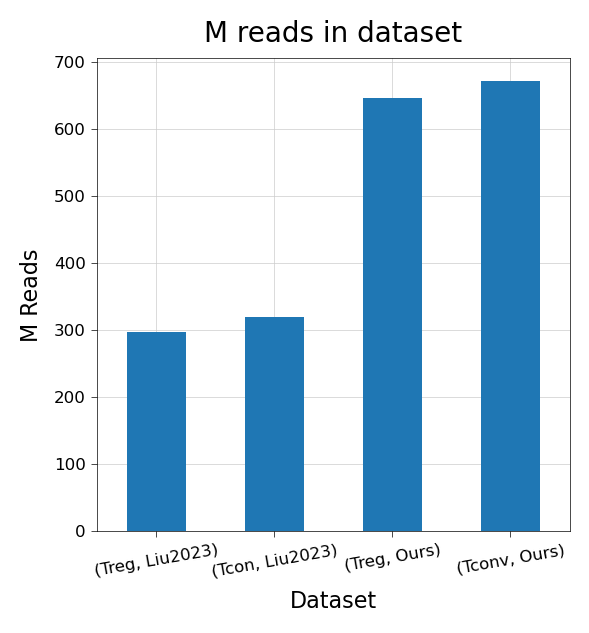

In [58]:
%autoreload 2

from supp_figures_plotting_functions import make_hic_liu23_readcount_barplot

fig = make_hic_liu23_readcount_barplot()
fig.savefig('./plots/paper/s1/loop_manhattan.pdf', bbox_inches='tight')

B. Reproducibility

/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/hic_zscore_functions.py:148: RuntimeWarning: Mean of empty slice
  m = np.nanmean(np.diag(balanced_mat, k=off_diag_k))
/Genomics/

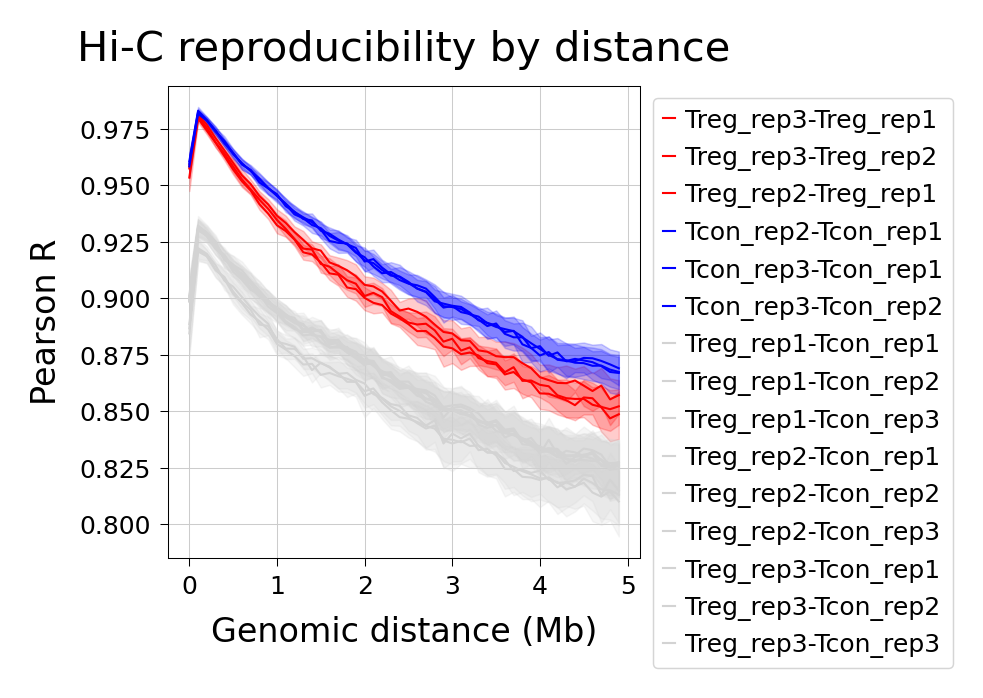

In [60]:
from aux_functions import *
from make_figure4 import normalize_raw_intra
from supp_figures_plotting_functions import hic_reproducibility_by_distance

hic_reproducibility_by_distance()

#### Figure S2

A. Looping venn diagram

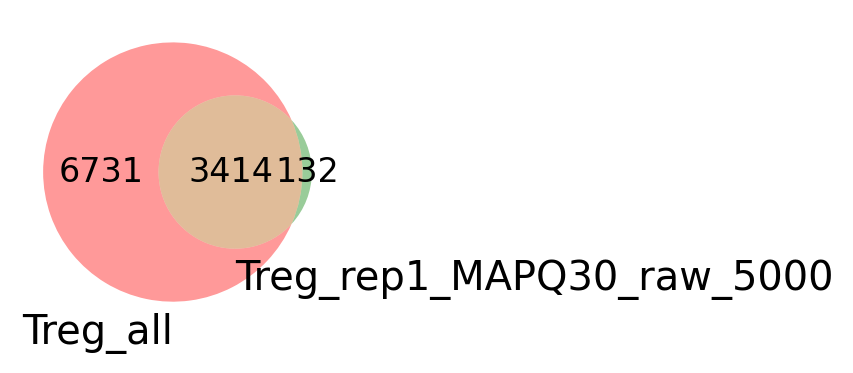

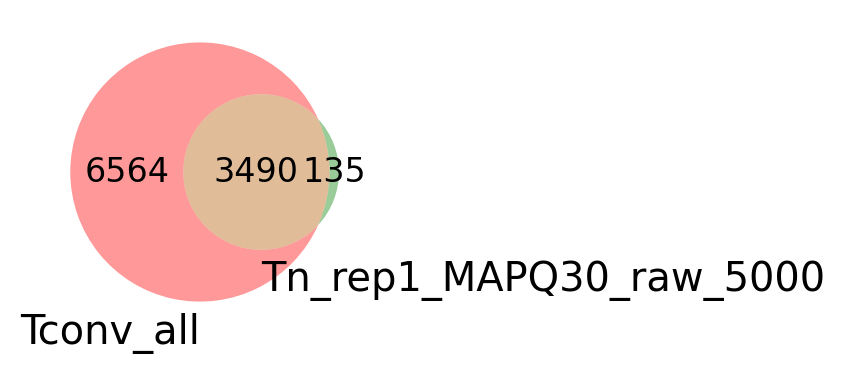

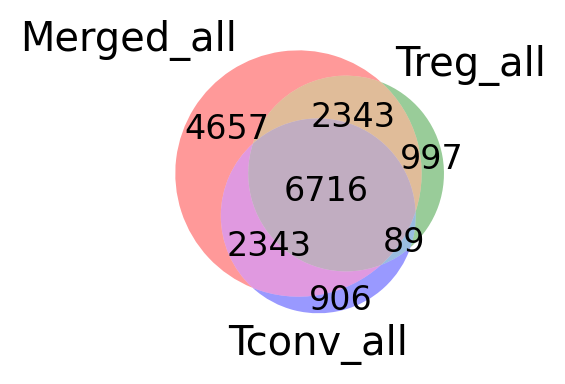

In [61]:
from supp_figures_plotting_functions import make_venn_diagrams

fig_treg, fig_tcon, fig_merged = make_venn_diagrams(all_loops_df)
# fig_treg.savefig("./plots/paper/s2/loop_venn_treg.pdf", bbox_inches='tight')
# fig_tcon.savefig("./plots/paper/s2/loop_venn_tcon.pdf", bbox_inches='tight')
# fig_merged.savefig("./plots/paper/s2/loop_venn_merged.pdf", bbox_inches='tight')

B. Jaccard looping

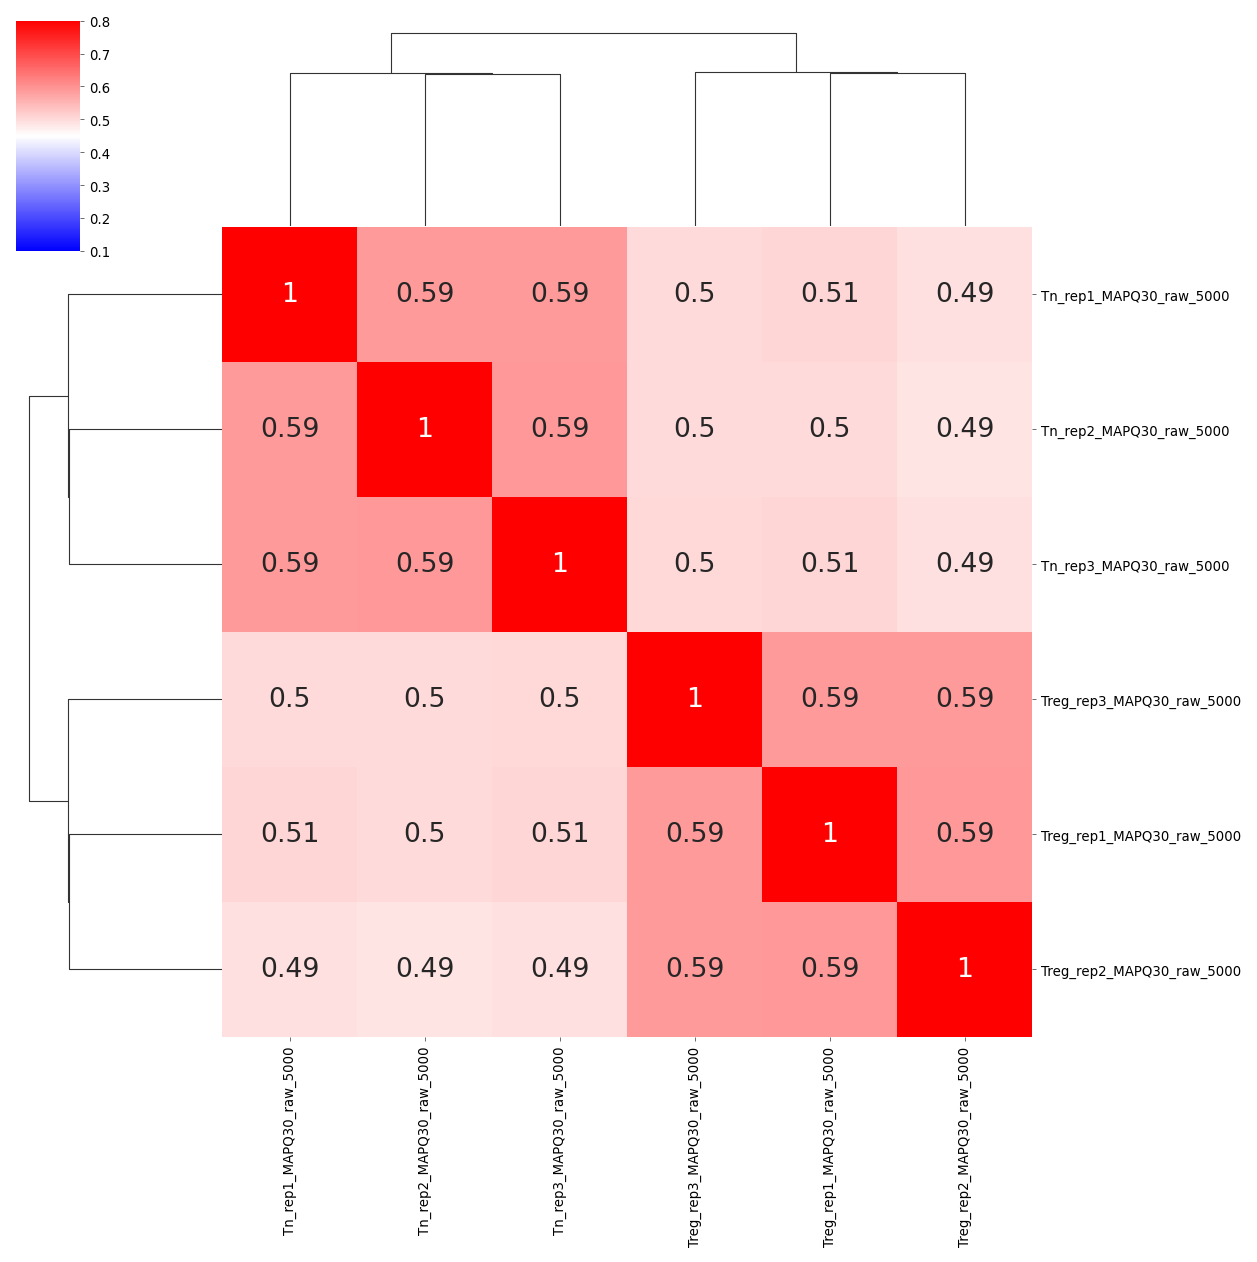

In [62]:
%autoreload 2
from supp_figures_plotting_functions import make_jaccard_clustermap

fig_jacc, df_jacc = make_jaccard_clustermap(all_loops_df)
fig_jacc.savefig("./plots/paper/s2/loop_jacc.pdf", bbox_inches='tight')

C. Mustache FDRs

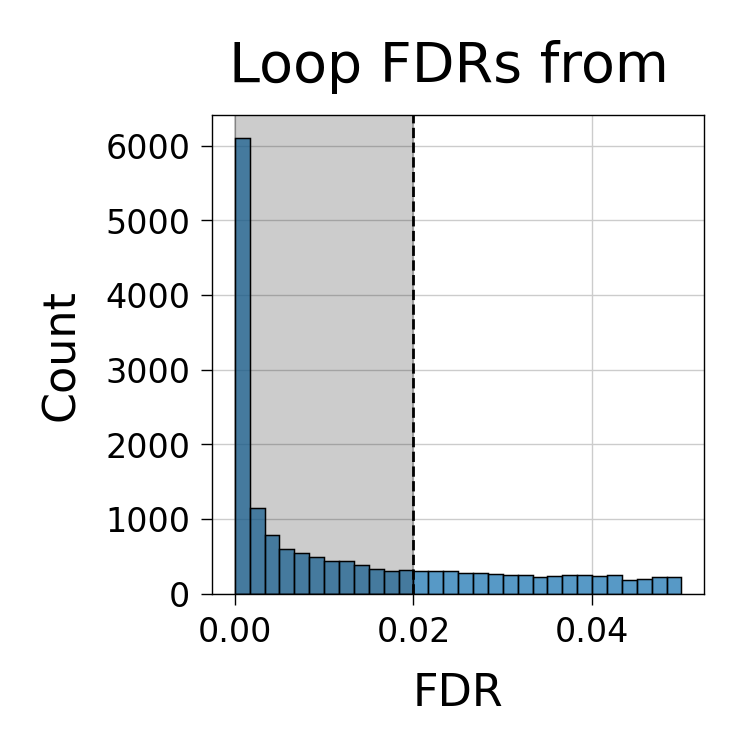

In [63]:
from supp_figures_plotting_functions import make_fdr_histogram

fig = make_fdr_histogram(init_dfs)
fig.savefig("./plots/paper/s2/loop_fdrs.pdf", bbox_inches='tight')

D1. Random examples

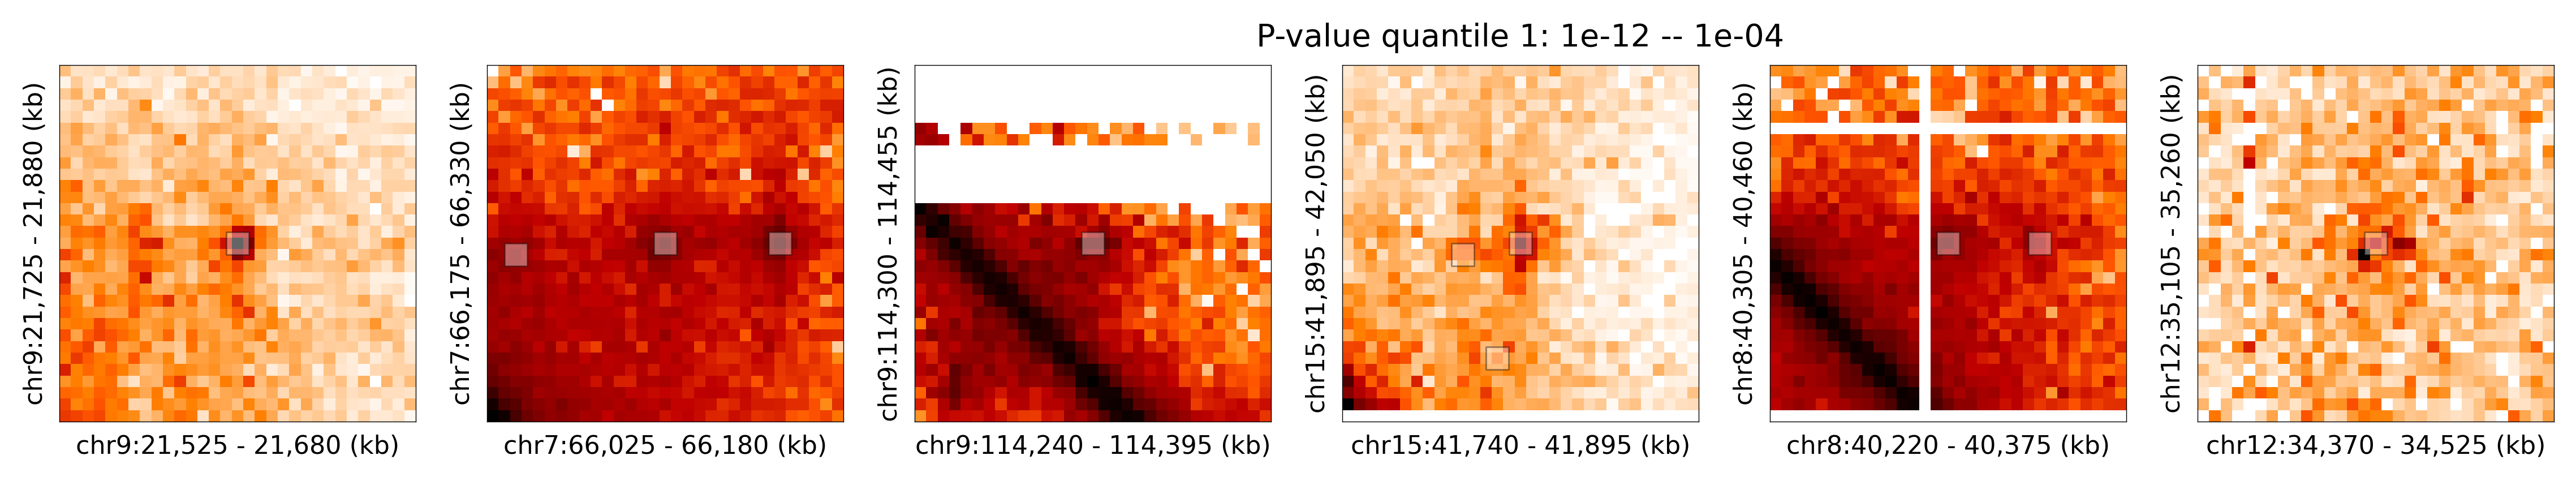

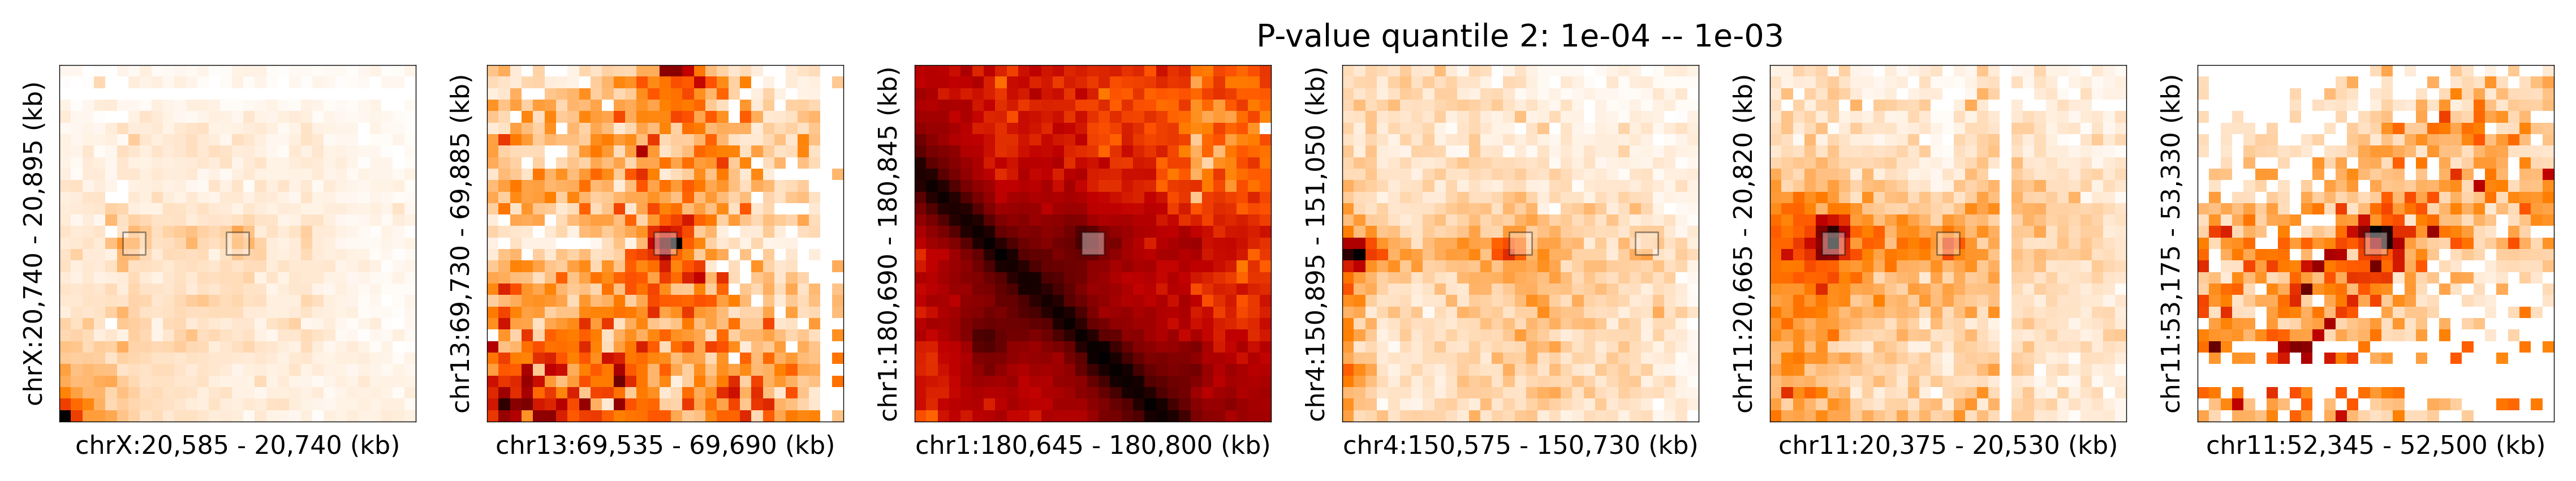

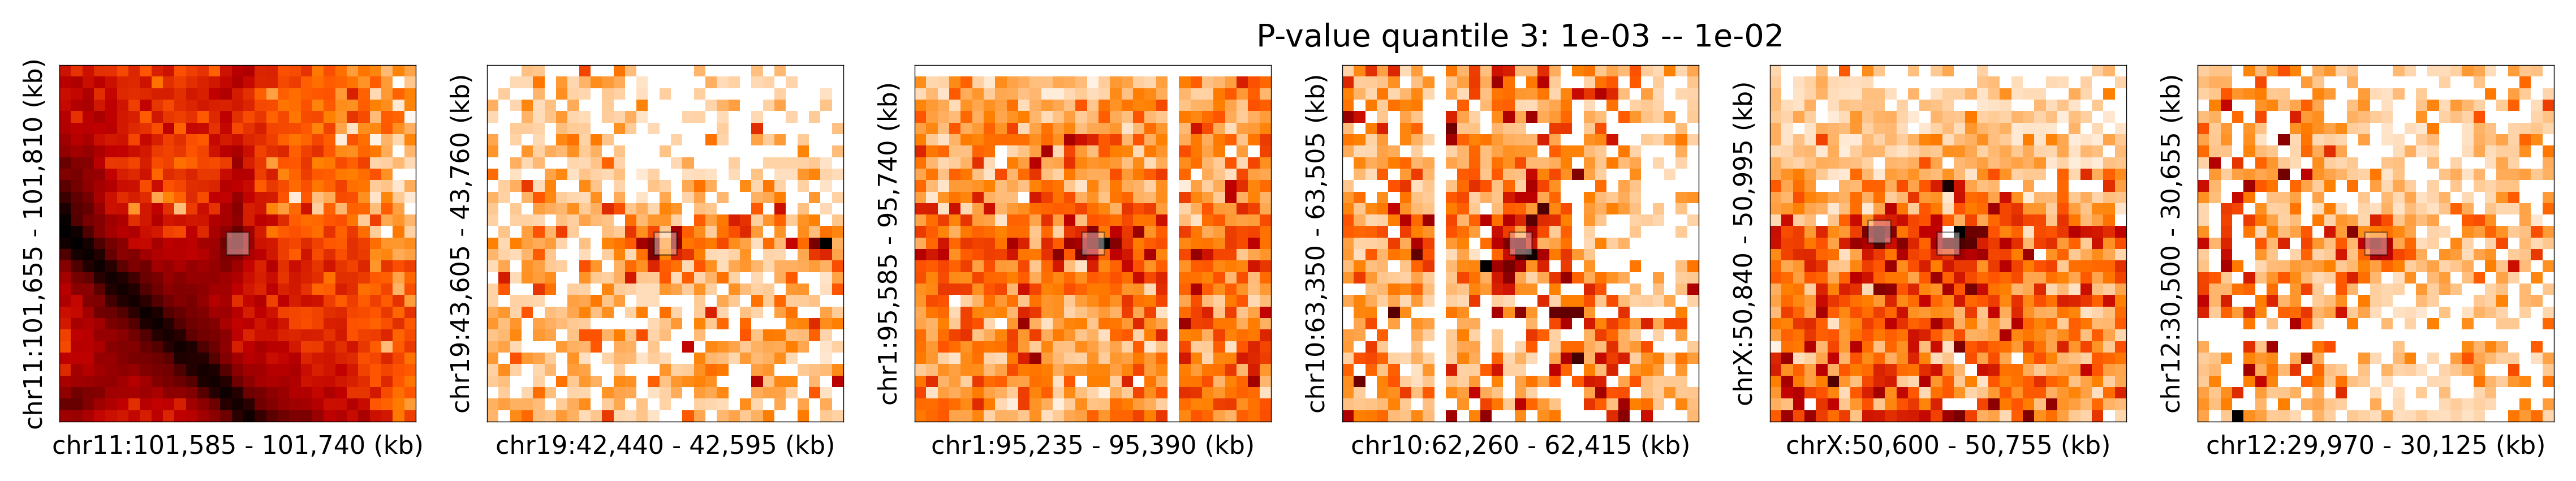

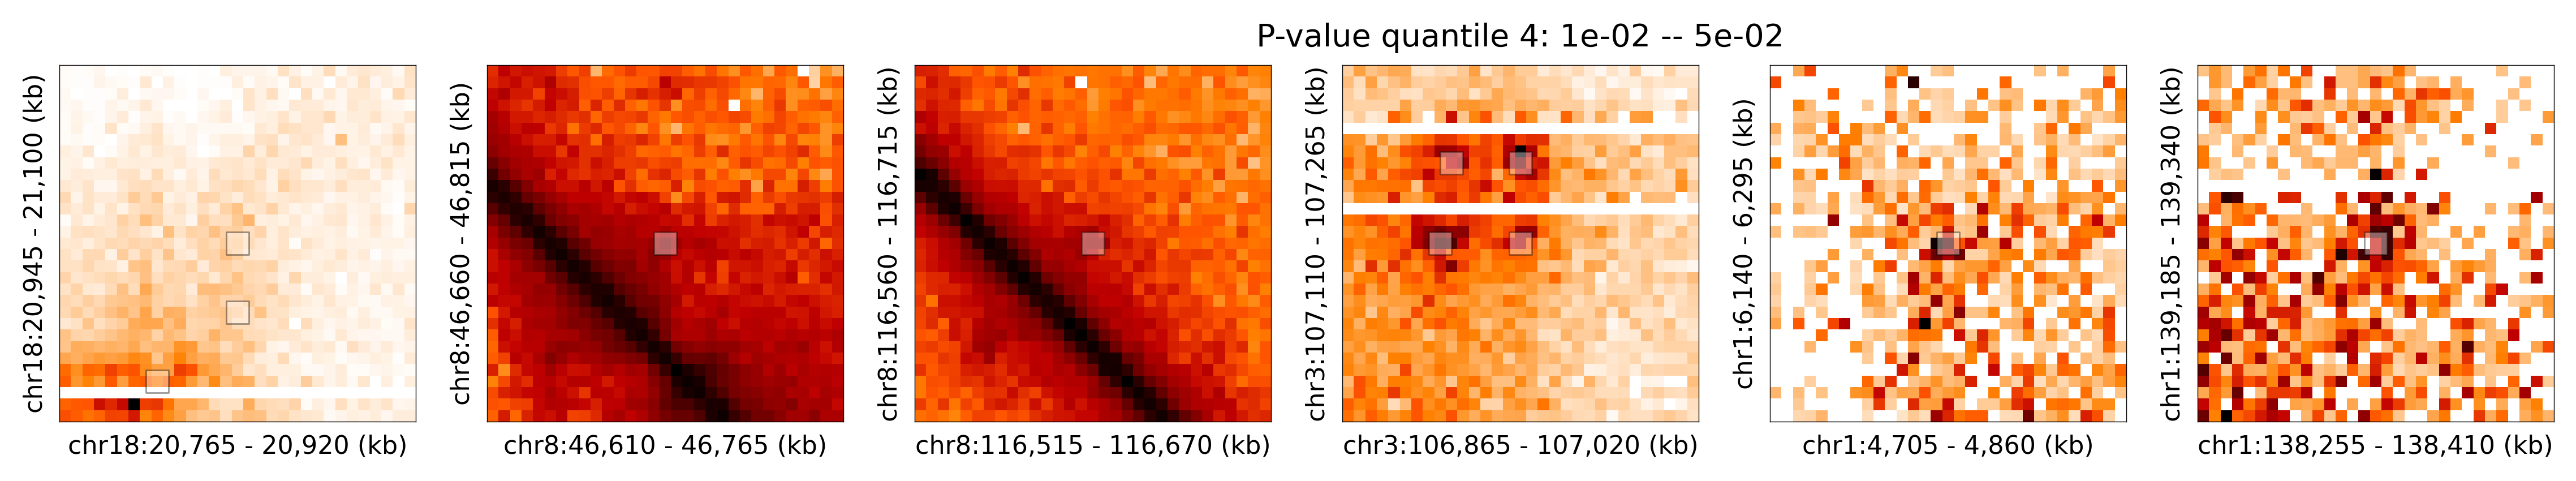

In [64]:
from supp_figures_plotting_functions import plot_random_examples

figs = plot_random_examples(init_dfs, cooldict_5kb)

D2. Looops by replicate

In [65]:
name = 'by_replicates'
oe_df = pd.read_csv(f'./data_for_enhancer_umap/oe_df_{name}.csv', sep='\t', index_col = 0)

with open(f'./full_pileup_dict_{name}', 'rb') as f:
    full_pileup_dict = pickle.load(f)

In [66]:
loops_with_FDR = pd.read_csv('final_loops/all_loops.csv', sep='\t', index_col = 0)

In [67]:
def df_to_loop_grange_list(df):
    loop_grange_list = []
    for _, row in  df.iterrows():
        loop_grange = granges_to_loop_grange(tuple_to_grange(*add_chr_to_anc(make_str(row[:3].values))),
                                             tuple_to_grange(*add_chr_to_anc(make_str(row[3:6].values))))
        loop_grange_list.append(loop_grange)
    return loop_grange_list

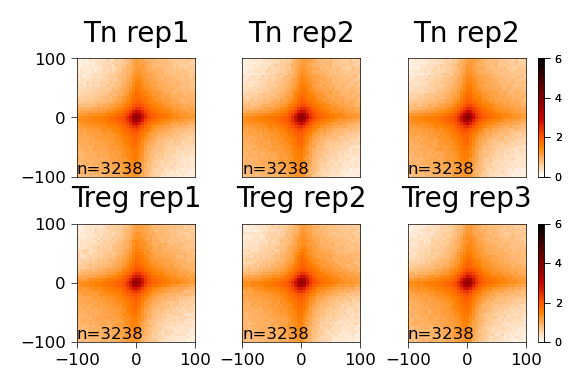

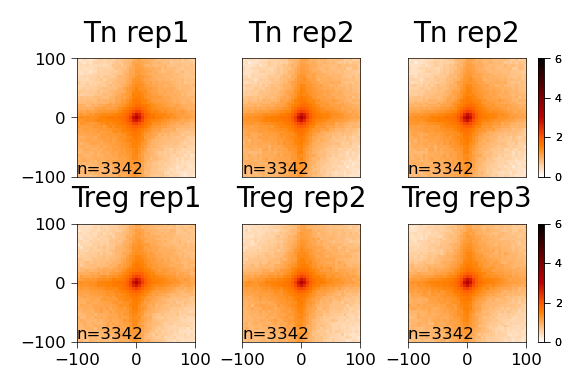

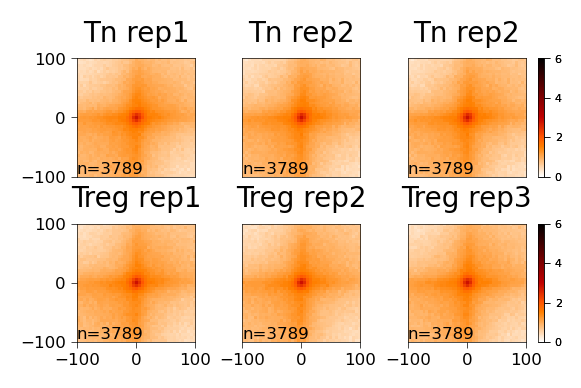

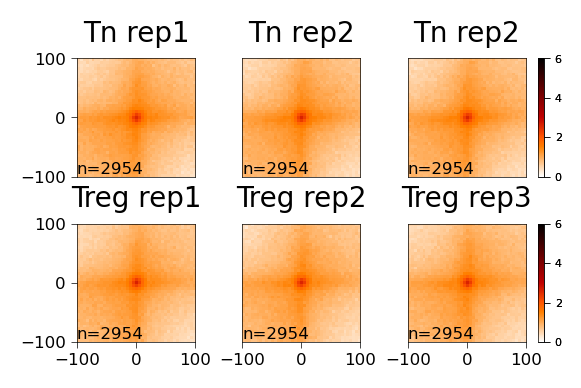

In [68]:
from supp_figures_plotting_functions import plot_apa

quants = [0, .0001, .002, .01, .02, 1]
qs = pd.cut(loops_with_FDR['FDR'], quants, labels=False)
for u in np.unique(qs):
    idx = qs == u
    loop_granges = pd.Series(arr(df_to_loop_grange_list(loops_with_FDR[idx].iloc[:, :6])))
    oe_idx = oe_df.index.isin(loop_granges)
    fig  = plot_apa(full_pileup_dict, idx = oe_idx, res=5000)
    fig.savefig(f'./plots/paper/s2/baseline_loops_{quants[u]}-{quants[u+1]}.pdf', 
               bbox_inches='tight')

E. Manhattan plot

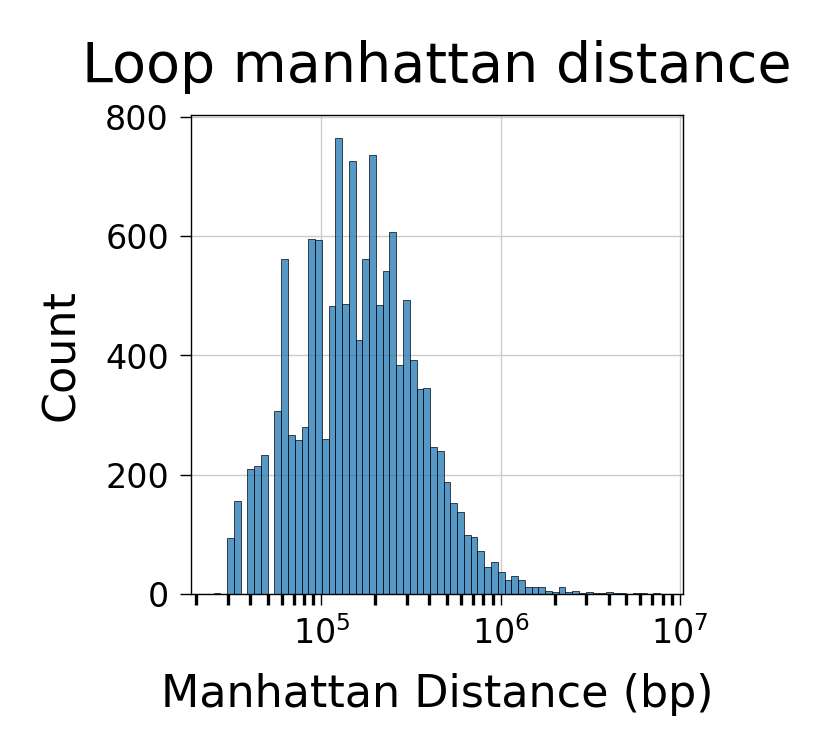

In [69]:
from supp_figures_plotting_functions import make_manhattan_distance_plot

make_manhattan_distance_plot(all_loops)

F. DESeq2 MA Plot

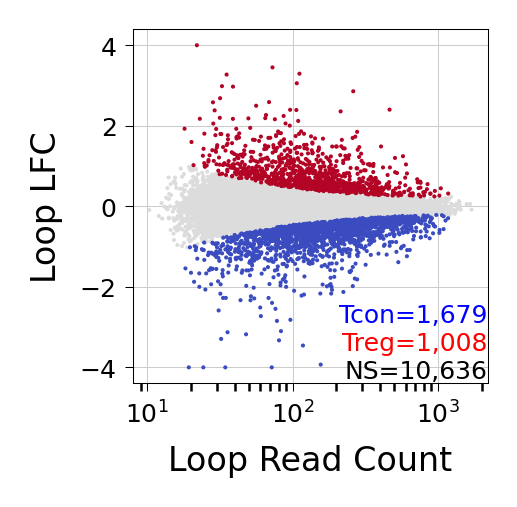

In [70]:
from supp_figures_plotting_functions import deseq_ma_plot

fig = deseq_ma_plot(all_loops.to_dataframe(header=None))
fig.savefig("./plots/paper/s2/deseq_maplot.pdf", bbox_inches='tight')

Compare Liu2023 loops with our loops

/Genomics/pritykinlab/gabe/jupys/tregs/./code/supp_figures_plotting_functions.py:605: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bin1_start'], df['bin1_end'] = zip(*new_coords_bin1)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/supp_figures_plotting_functions.py:608: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bin2_start'], df['bin2_end'] = zip(*new_coords_bin2)


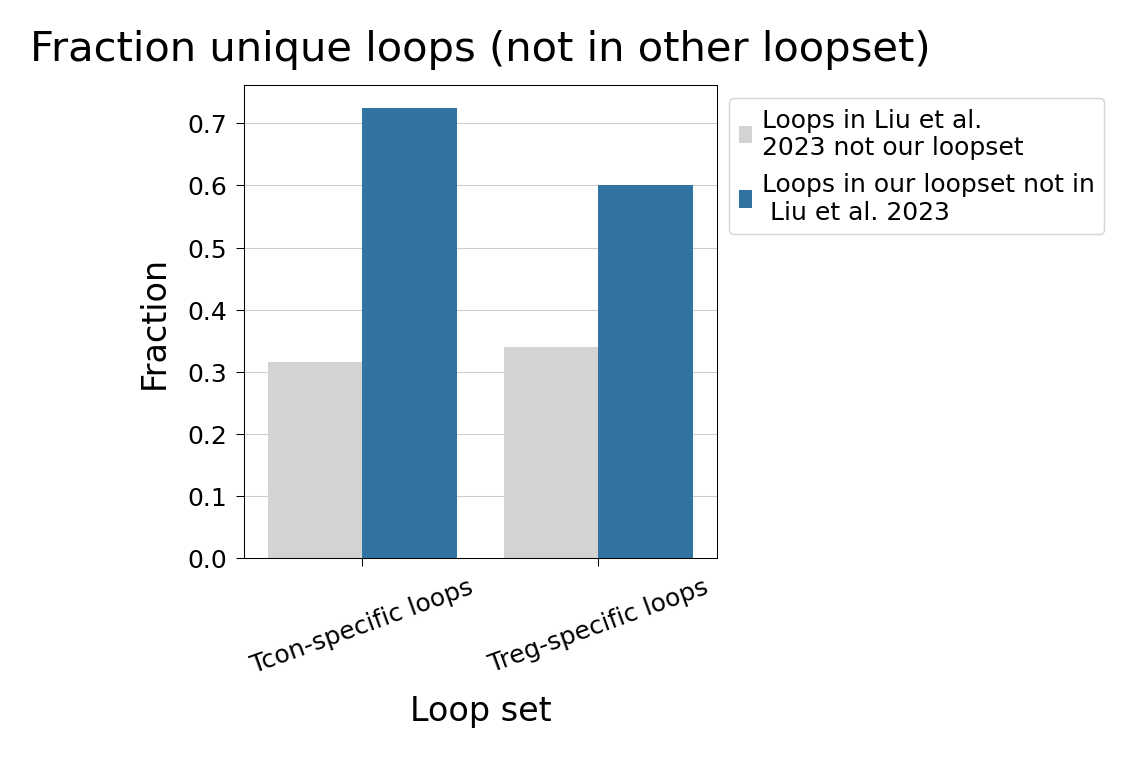

In [71]:
from supp_figures_plotting_functions import compare_liu2023_loops_to_our_loops

compare_liu2023_loops_to_our_loops(loopdict)

#### Figure S2

In [73]:
import aux_functions
from aux_functions import *

In [74]:
%autoreload 2
from supp_figures_plotting_functions import process_deseq2_output

d = process_deseq2_output()

A, B. Venn Diagrams

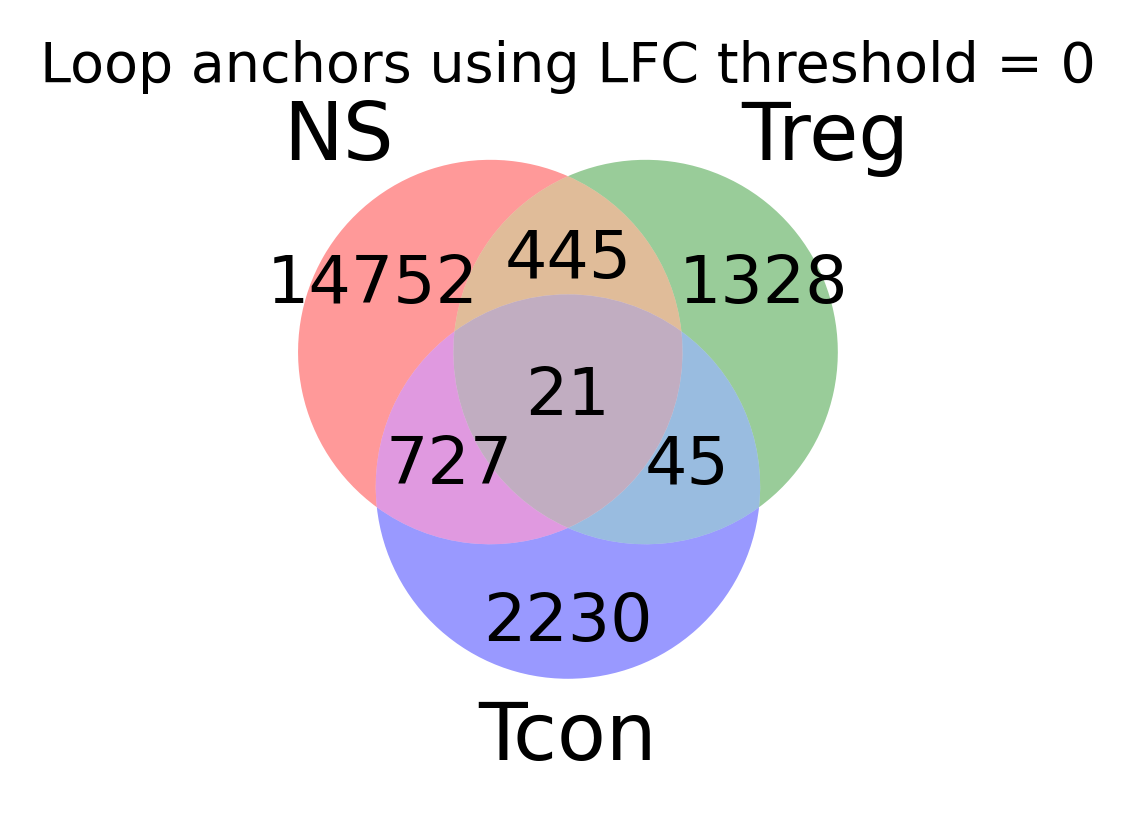

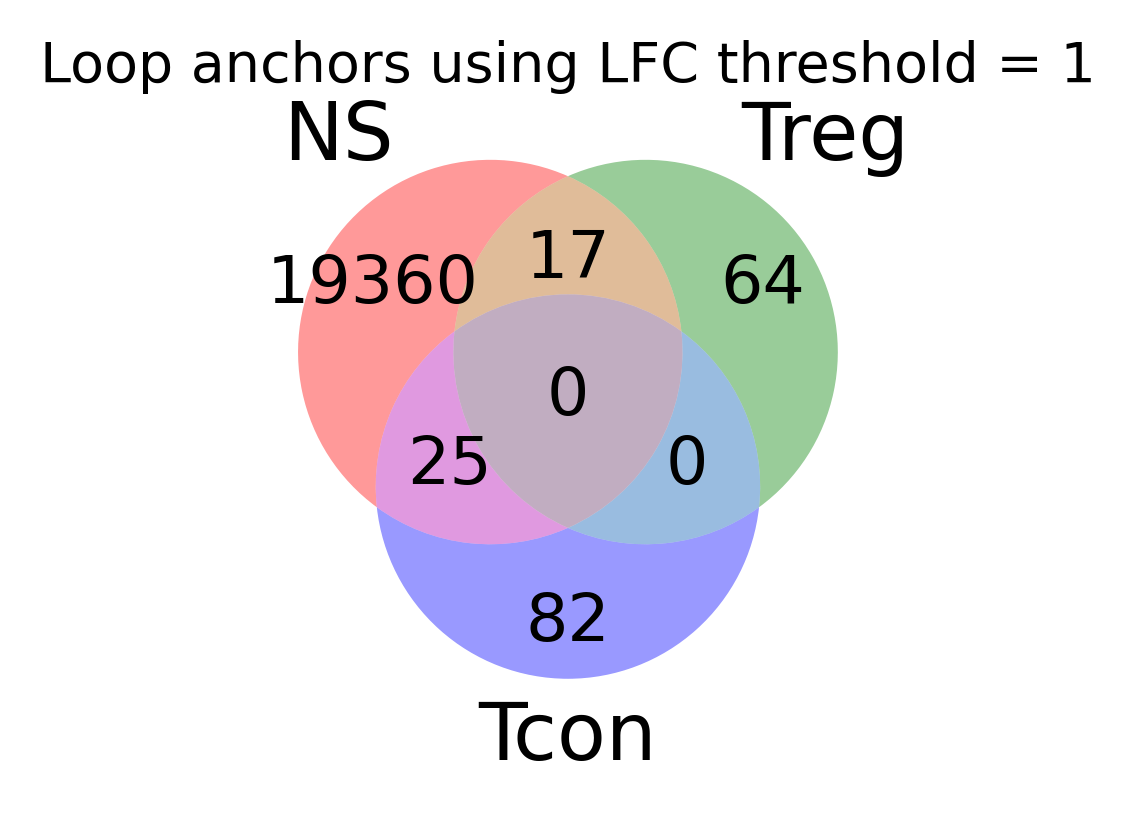

In [77]:
from supp_figures_plotting_functions import make_venn_diagram_plot_s3

make_venn_diagram_plot_s3()


C-D. LFC plots

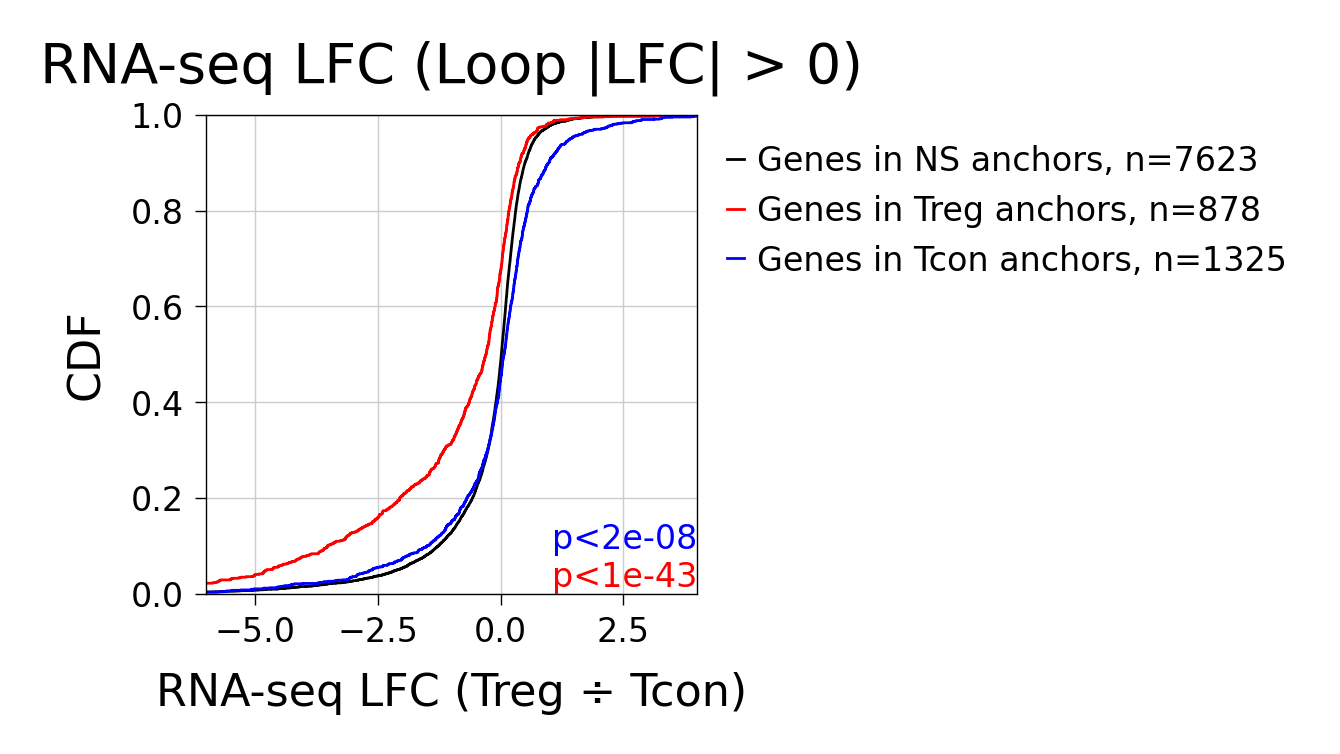

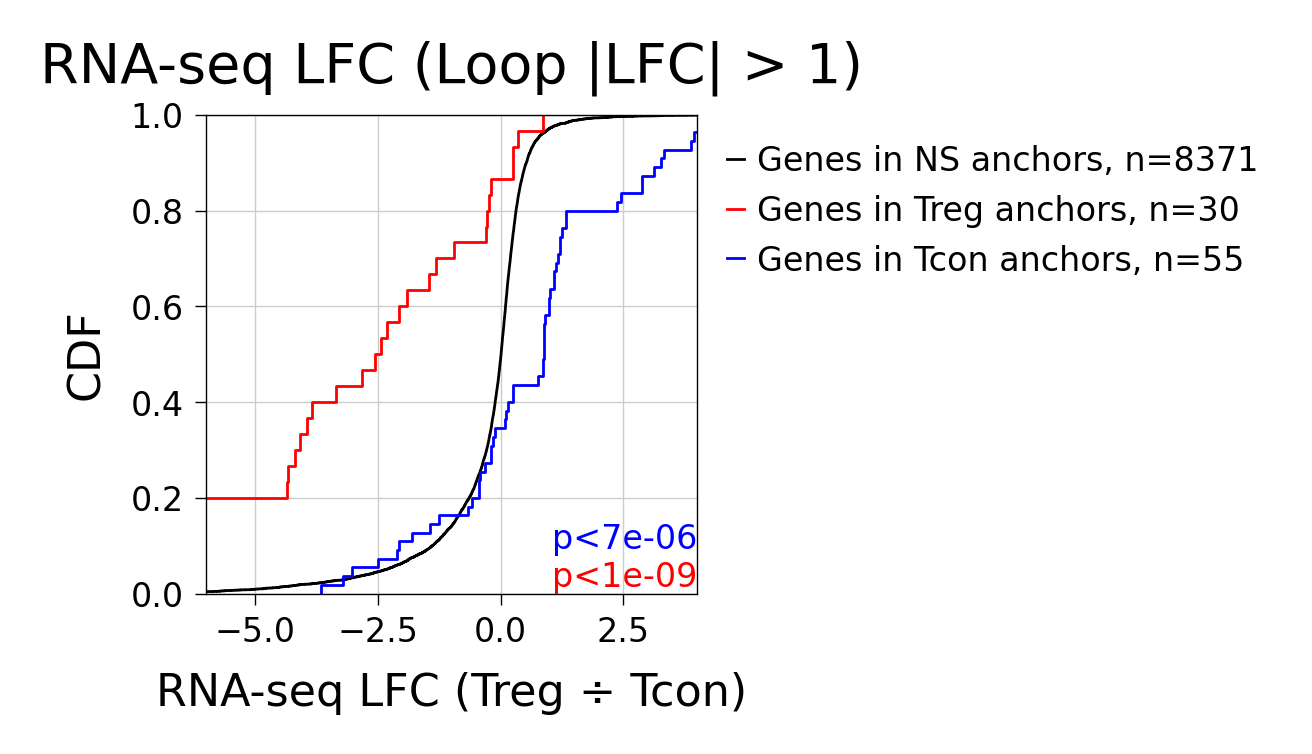

In [78]:
%autoreload 2
from supp_figures_plotting_functions import make_loop_lfc_cdf_plot

make_loop_lfc_cdf_plot(resting_gene_bedtool)

E. Loop length

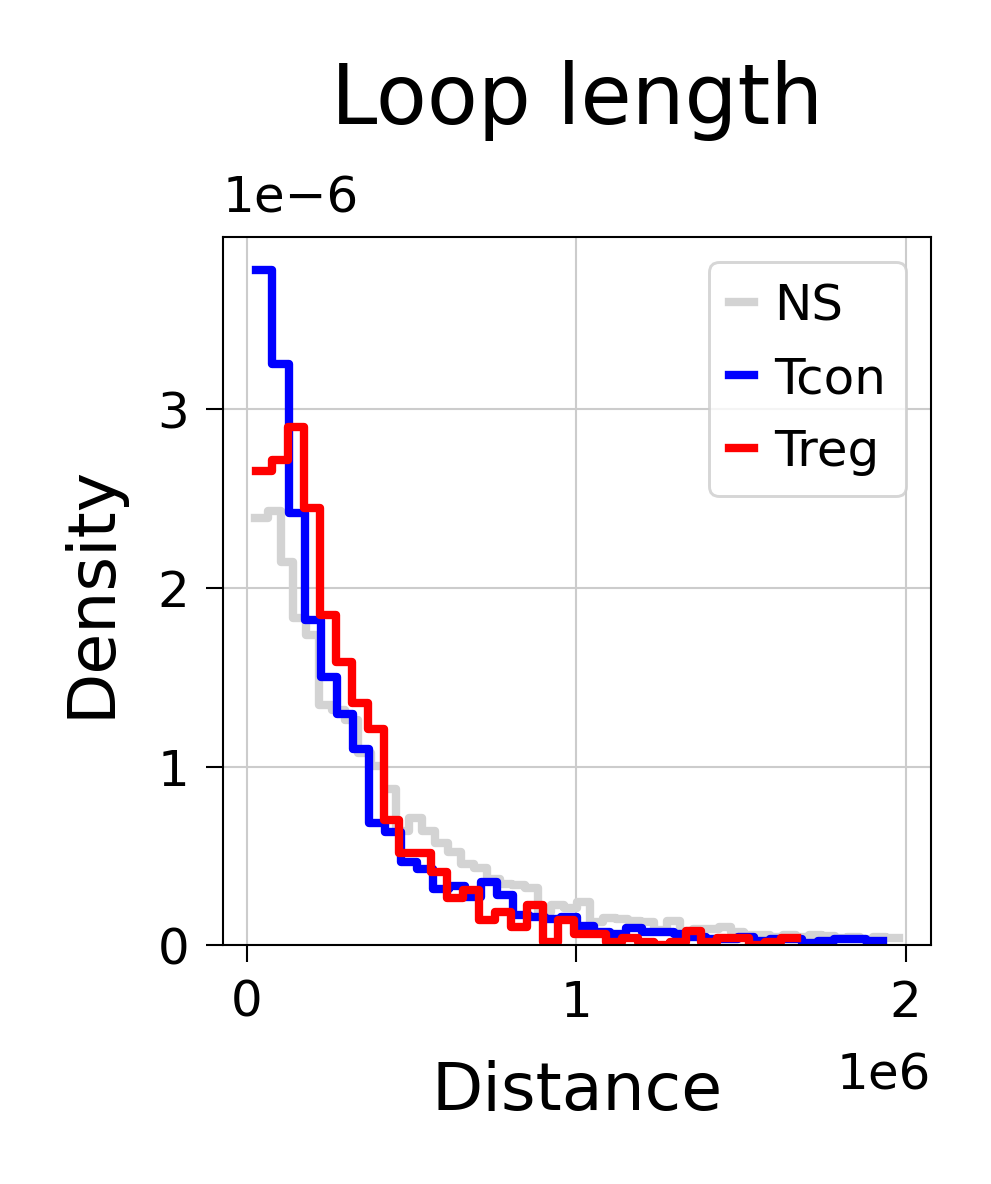

In [79]:
from supp_figures_plotting_functions import make_looplength_plot

make_looplength_plot(loopdict, loop_colordict)

F. TSS at loops

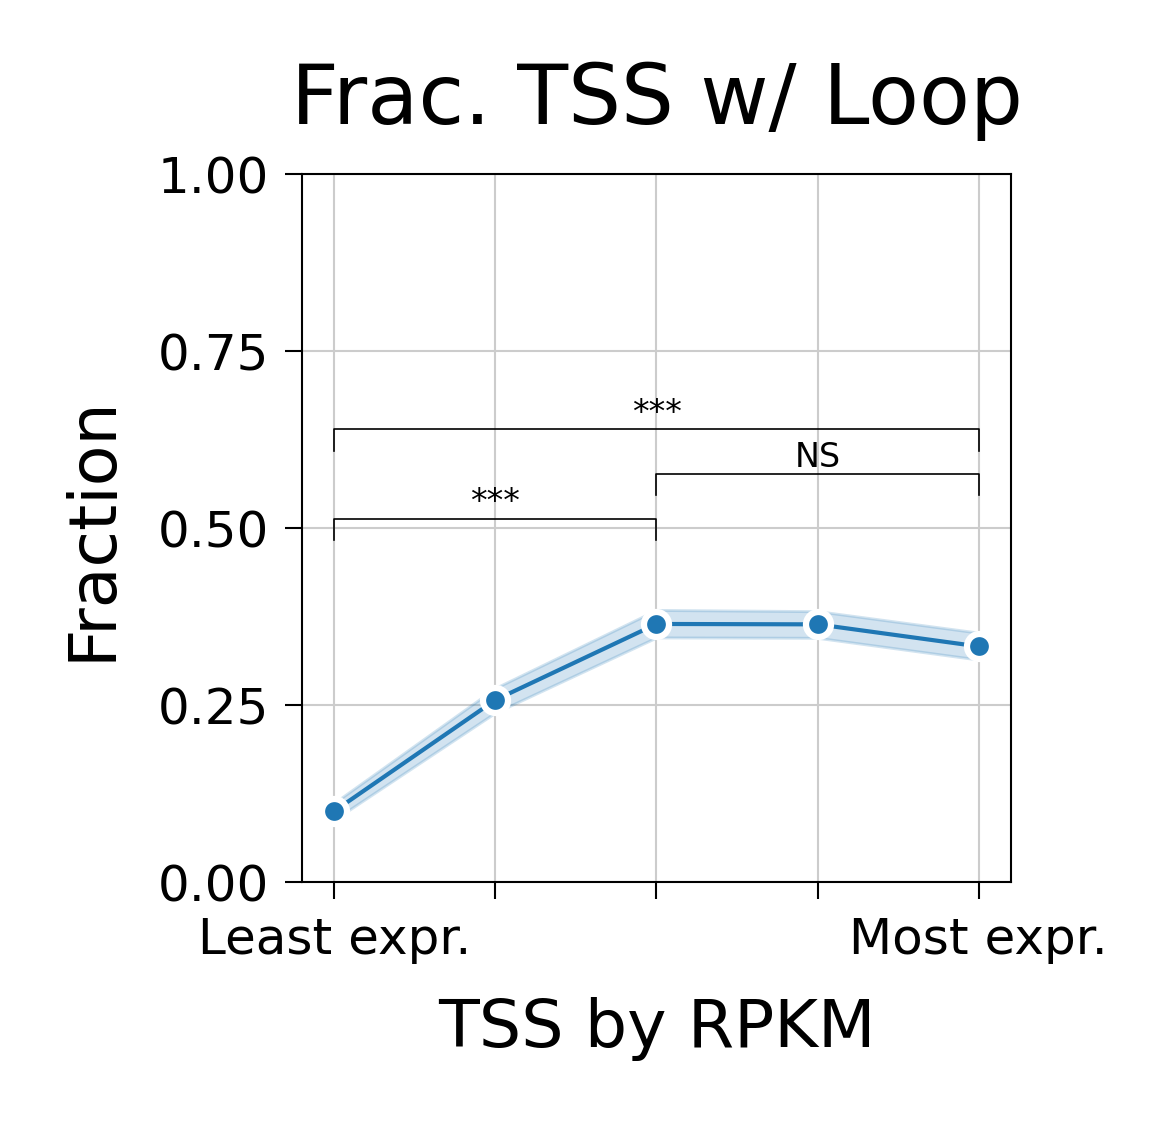

In [89]:
from supp_figures_plotting_functions import make_tss_lineplot3

v = make_tss_lineplot3(gene_dict['Resting'], anchordict, my_tss_df, parsed_chroms)

G. Loops <-> Compartments

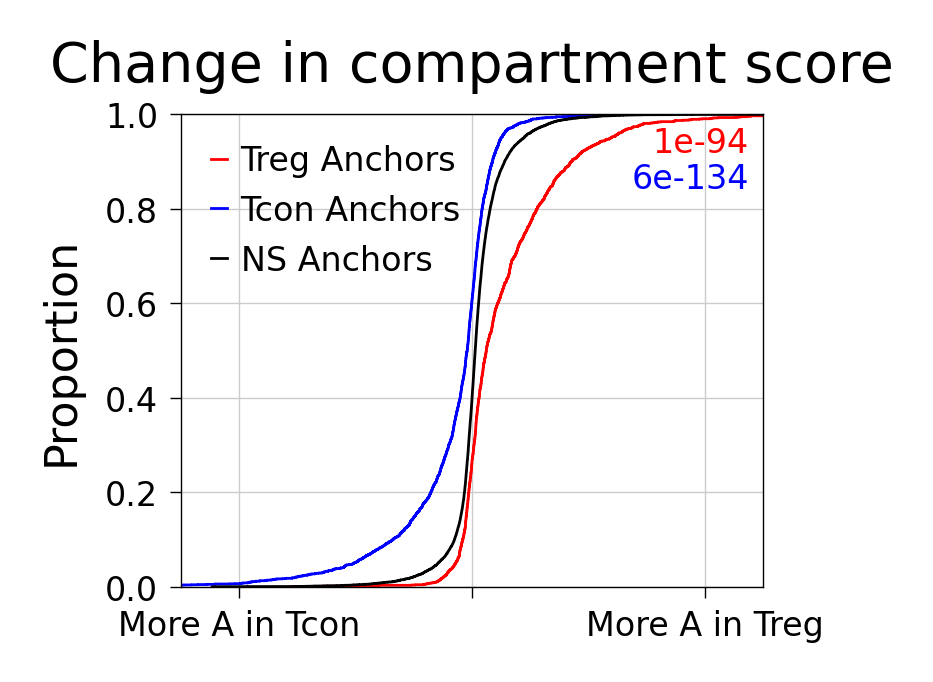

In [90]:
treg_ancs = np.where(get_col(pbt.BedTool(all_ind_to_region_50kb).intersect(anchordict['Treg'], c=True), -1).astype(int)>0)[0]
tcon_ancs = np.where(get_col(pbt.BedTool(all_ind_to_region_50kb).intersect(anchordict['Tcon'], c=True), -1).astype(int)>0)[0]
ns_ancs = np.where(get_col(pbt.BedTool(all_ind_to_region_50kb).intersect(anchordict['NS'], c=True), -1).astype(int)>0)[0]

d = (my_treg_comp_50kb-my_tcon_comp_50kb)
fig, axs = init_subplots_exact(1, 1, fgsz=(37*mm, 30*mm), dpi = 200)
sns.ecdfplot(d[treg_ancs], color='red', ax=axs, label=f'Treg Anchors')
sns.ecdfplot(d[tcon_ancs], color='blue', ax=axs, label=f'Tcon Anchors')
sns.ecdfplot(d[ns_ancs], color='black', ax=axs, label=f'NS Anchors')

treg_pstr = format_pvalue(nonan_test(d[treg_ancs], d[ns_ancs])[1])
tcon_pstr = format_pvalue(nonan_test(d[tcon_ancs], d[ns_ancs])[1])
plt.text(0.975, .975, treg_pstr, color='red', transform = plt.gca().transAxes, va='top', ha='right', fontsize=6)
plt.text(0.975, .9, tcon_pstr, color='blue', transform = plt.gca().transAxes, va='top', ha='right', fontsize=6)
plt.xticks([-1, 0, 1])
plt.xlim([-1.25, 1.25])
axs.set_xticklabels(["More A in Tcon", '', 'More A in Treg'])
plt.title("Change in compartment score")
plt.legend(frameon=False)
fig.savefig('./plots/paper//compartment_score_loop_anchors.pdf', bbox_inches='tight')

H. TAD Pileup

Could not fetch in  Tn.1  error:  Genomic region out of bounds: [119750000, 120155000)
Could not fetch in  Tn.1  error:  Genomic region out of bounds: [181735000, 182140000)
Could not fetch in  Tn.1  error:  Genomic region out of bounds: [145045000, 145450000)
Done with Tn.1
Could not fetch in  Tn.2  error:  Genomic region out of bounds: [119750000, 120155000)
Could not fetch in  Tn.2  error:  Genomic region out of bounds: [181735000, 182140000)
Could not fetch in  Tn.2  error:  Genomic region out of bounds: [145045000, 145450000)
Done with Tn.2
Could not fetch in  Tn.3  error:  Genomic region out of bounds: [119750000, 120155000)
Could not fetch in  Tn.3  error:  Genomic region out of bounds: [181735000, 182140000)
Could not fetch in  Tn.3  error:  Genomic region out of bounds: [145045000, 145450000)
Done with Tn.3
Could not fetch in  Treg.1  error:  Genomic region out of bounds: [119750000, 120155000)
Could not fetch in  Treg.1  error:  Genomic region out of bounds: [181735000, 18214

/Genomics/pritykinlab/gabe/jupys/tregs/./code/supp_figures_plotting_functions.py:878: RuntimeWarning: Mean of empty slice
  mat = np.nanmean(apa_results[key], axis=0)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/supp_figures_plotting_functions.py:881: RuntimeWarning: divide by zero encountered in log2
  axs[c].matshow(np.log2(mat), cmap='gist_heat_r',


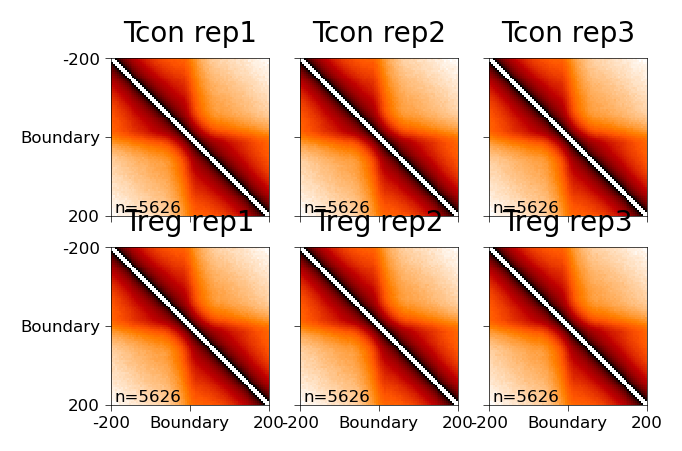

In [91]:
%autoreload 2

from supp_figures_plotting_functions import make_tad_plot2
from apa_figures import apa_diag_nonorm

make_tad_plot2(tad_boundaries)

I. Loops crossing TAD boundaries

0    0.461358
1    0.538642
Name: proportion, dtype: float64
0    0.515873
1    0.484127
Name: proportion, dtype: float64
0    0.51757
1    0.48243
Name: proportion, dtype: float64
    NS loops  Treg loops  Tcon loops  NS loops (200kb shift)  \
0   0.469161    0.611111    0.655152                0.461358   
>0  0.530839    0.388889    0.344848                0.538642   

    Treg loops (200kb shift)  Tcon loops (200kb shift)  
0                   0.515873                   0.51757  
>0                  0.484127                   0.48243  


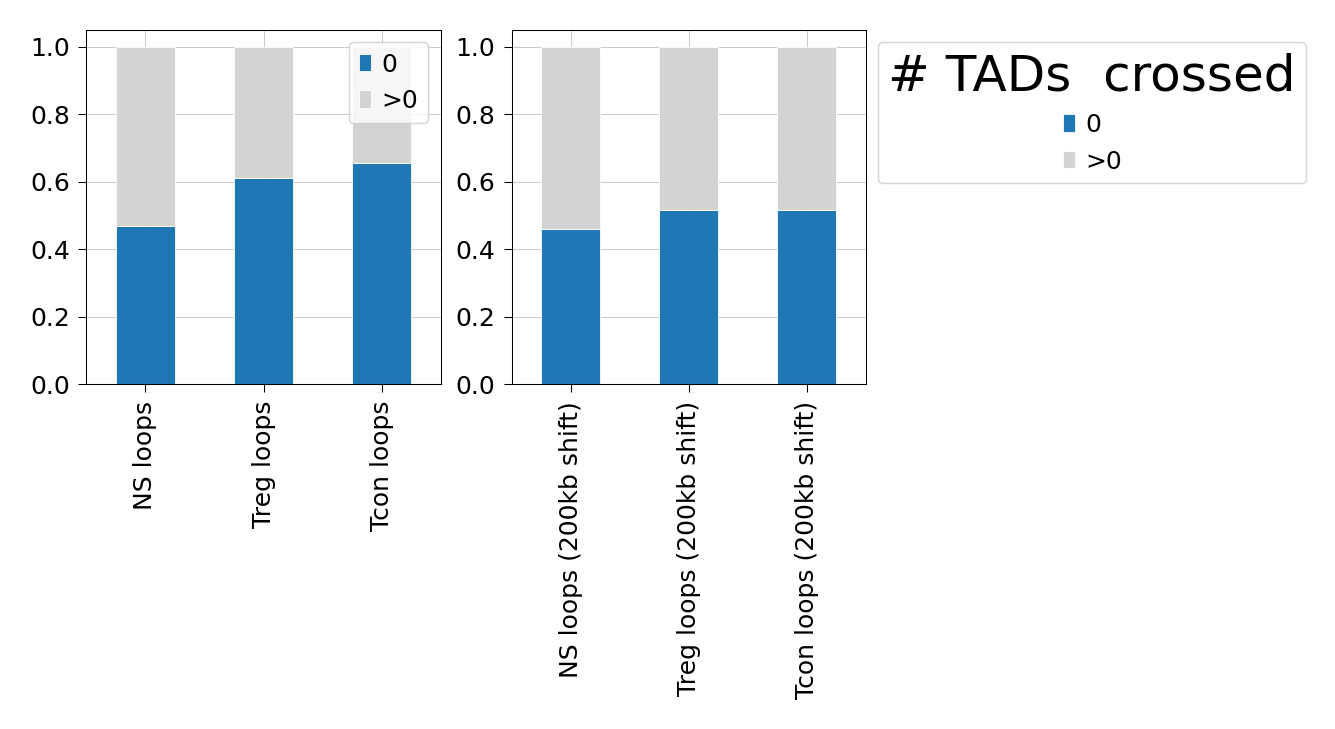

In [92]:
from supp_figures_plotting_functions import loop_tad_overlap

loop_tad_overlap(loopdict, tad_boundaries.slop(b=-10_000, genome='mm10').to_dataframe(),
                shiftsize = 1_000_000)

### Supplement 3

Look at notebooks in "plot_coolbox"

### Supplement 4

Look at notebooks in "cABC analysis"

### Figure S5

A. 

/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


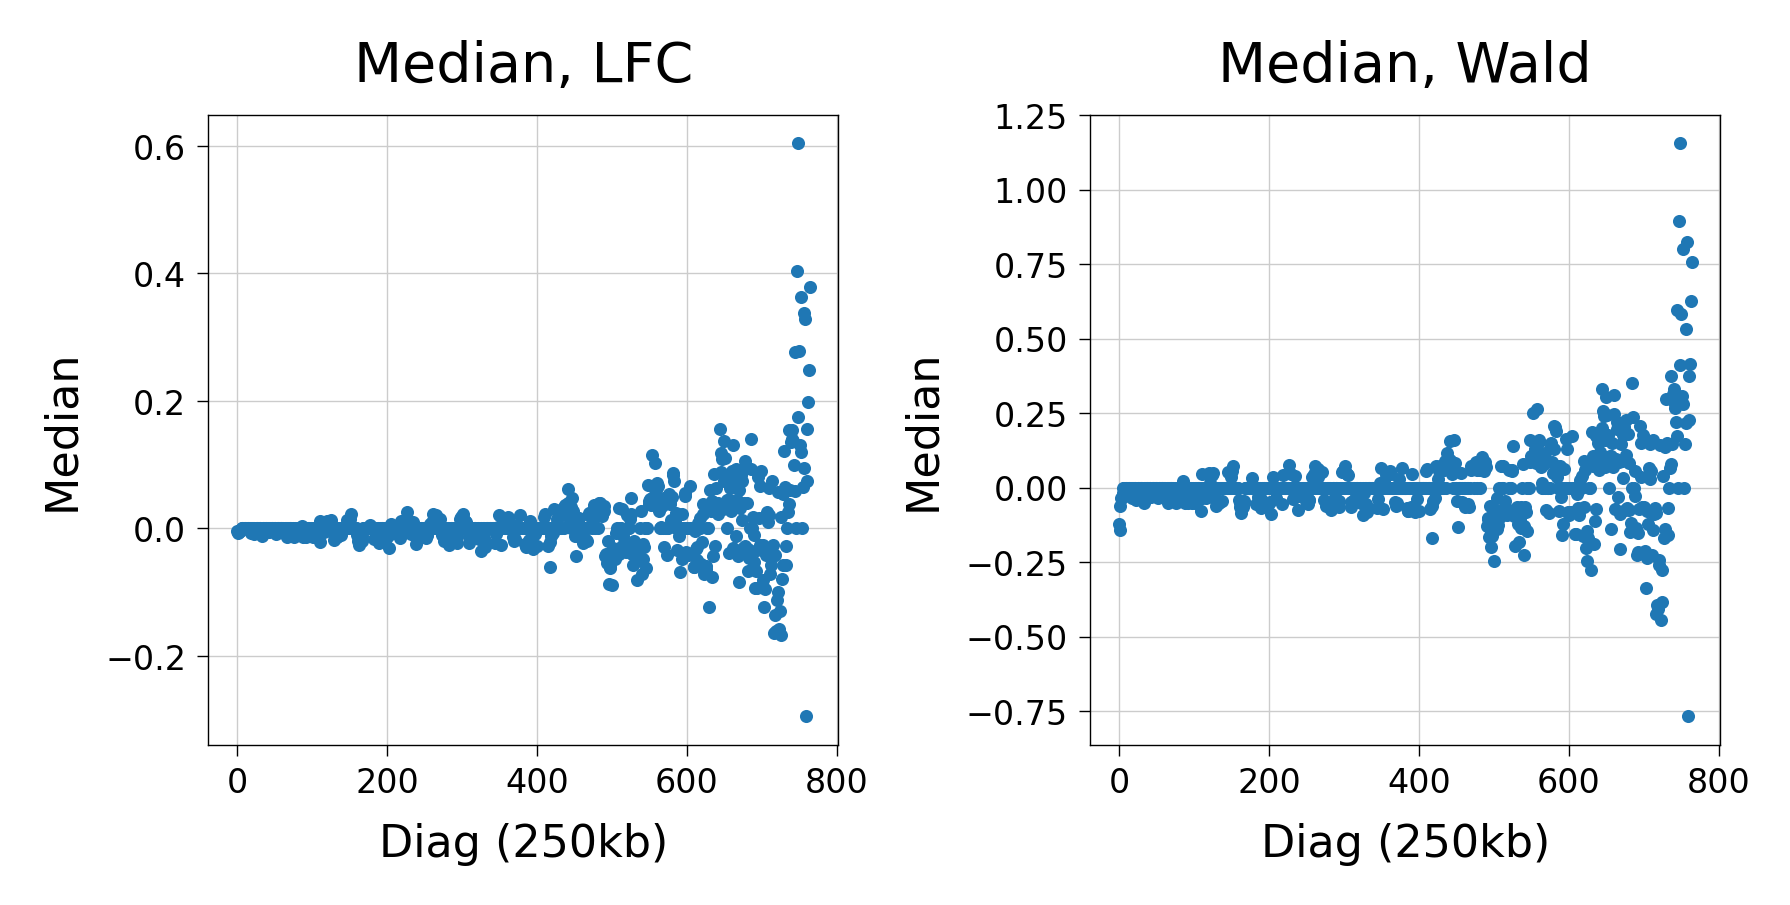

In [93]:
from supp_figures_plotting_functions import balanced_supplement_plots

fig = balanced_supplement_plots(deseq_lfc_mat, deseq_effect_mat)


B. Genes per 250kb bin

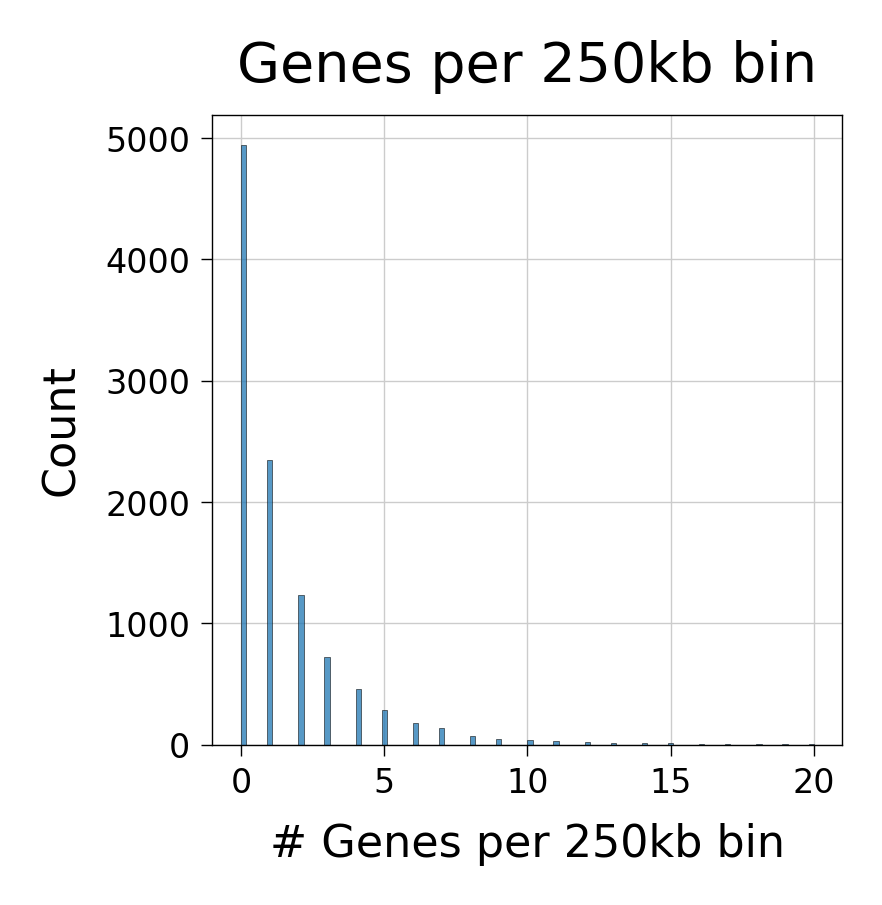

In [94]:
from supp_figures_plotting_functions import n_genes_per_bin

fig = n_genes_per_bin(ind_to_gene, all_ind_to_region)

C-D. Chromosome-wide DESeq2 Heatmaps

5


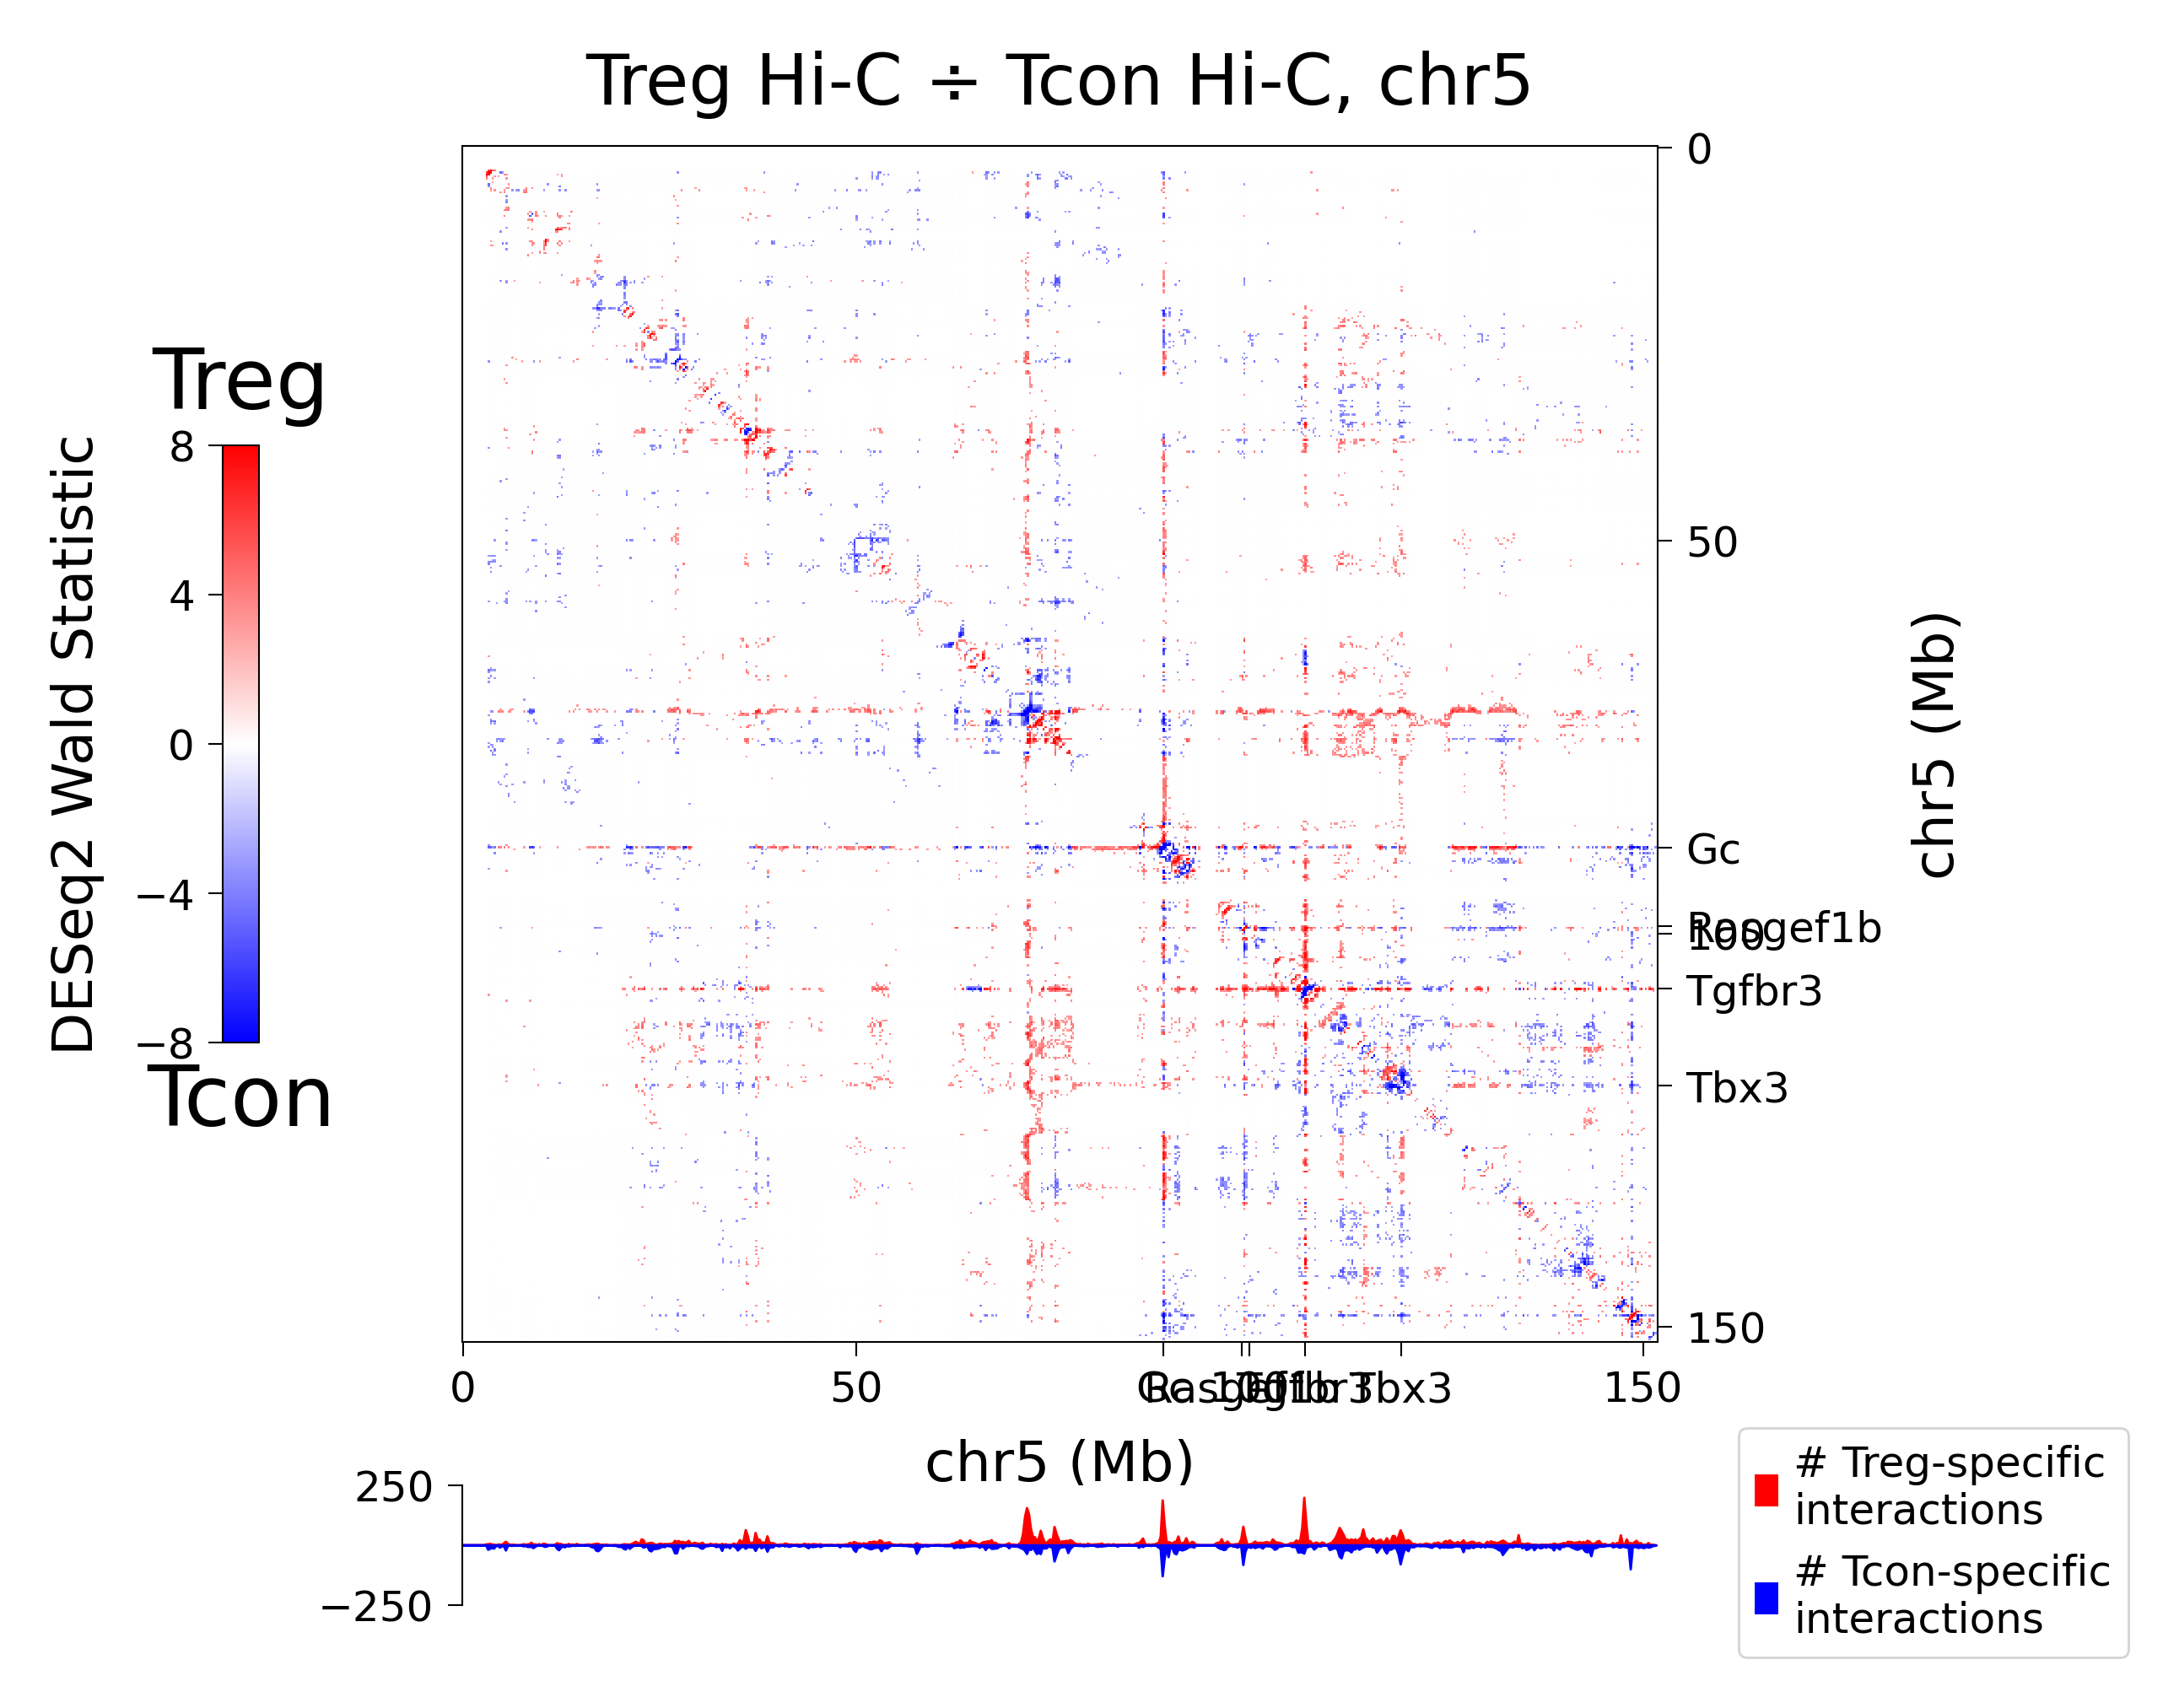

In [95]:
from supp_figures_plotting_functions import make_chromosomewide_deseq_plot

label_list = [[3208, 'Tgfbr3'], [3176, 'Rasgef1b'], [3136, 'Gc'], [3257, 'Tbx3']]
fig = make_chromosomewide_deseq_plot(deseq_effect_mat, deseq_pval_mat, '5', chrom_to_start, chrom_to_end, label_list, dpi = 300)
fig.savefig('./plots/paper/s8/chr5.pdf', bbox_inches='tight', dpi = 300)

4


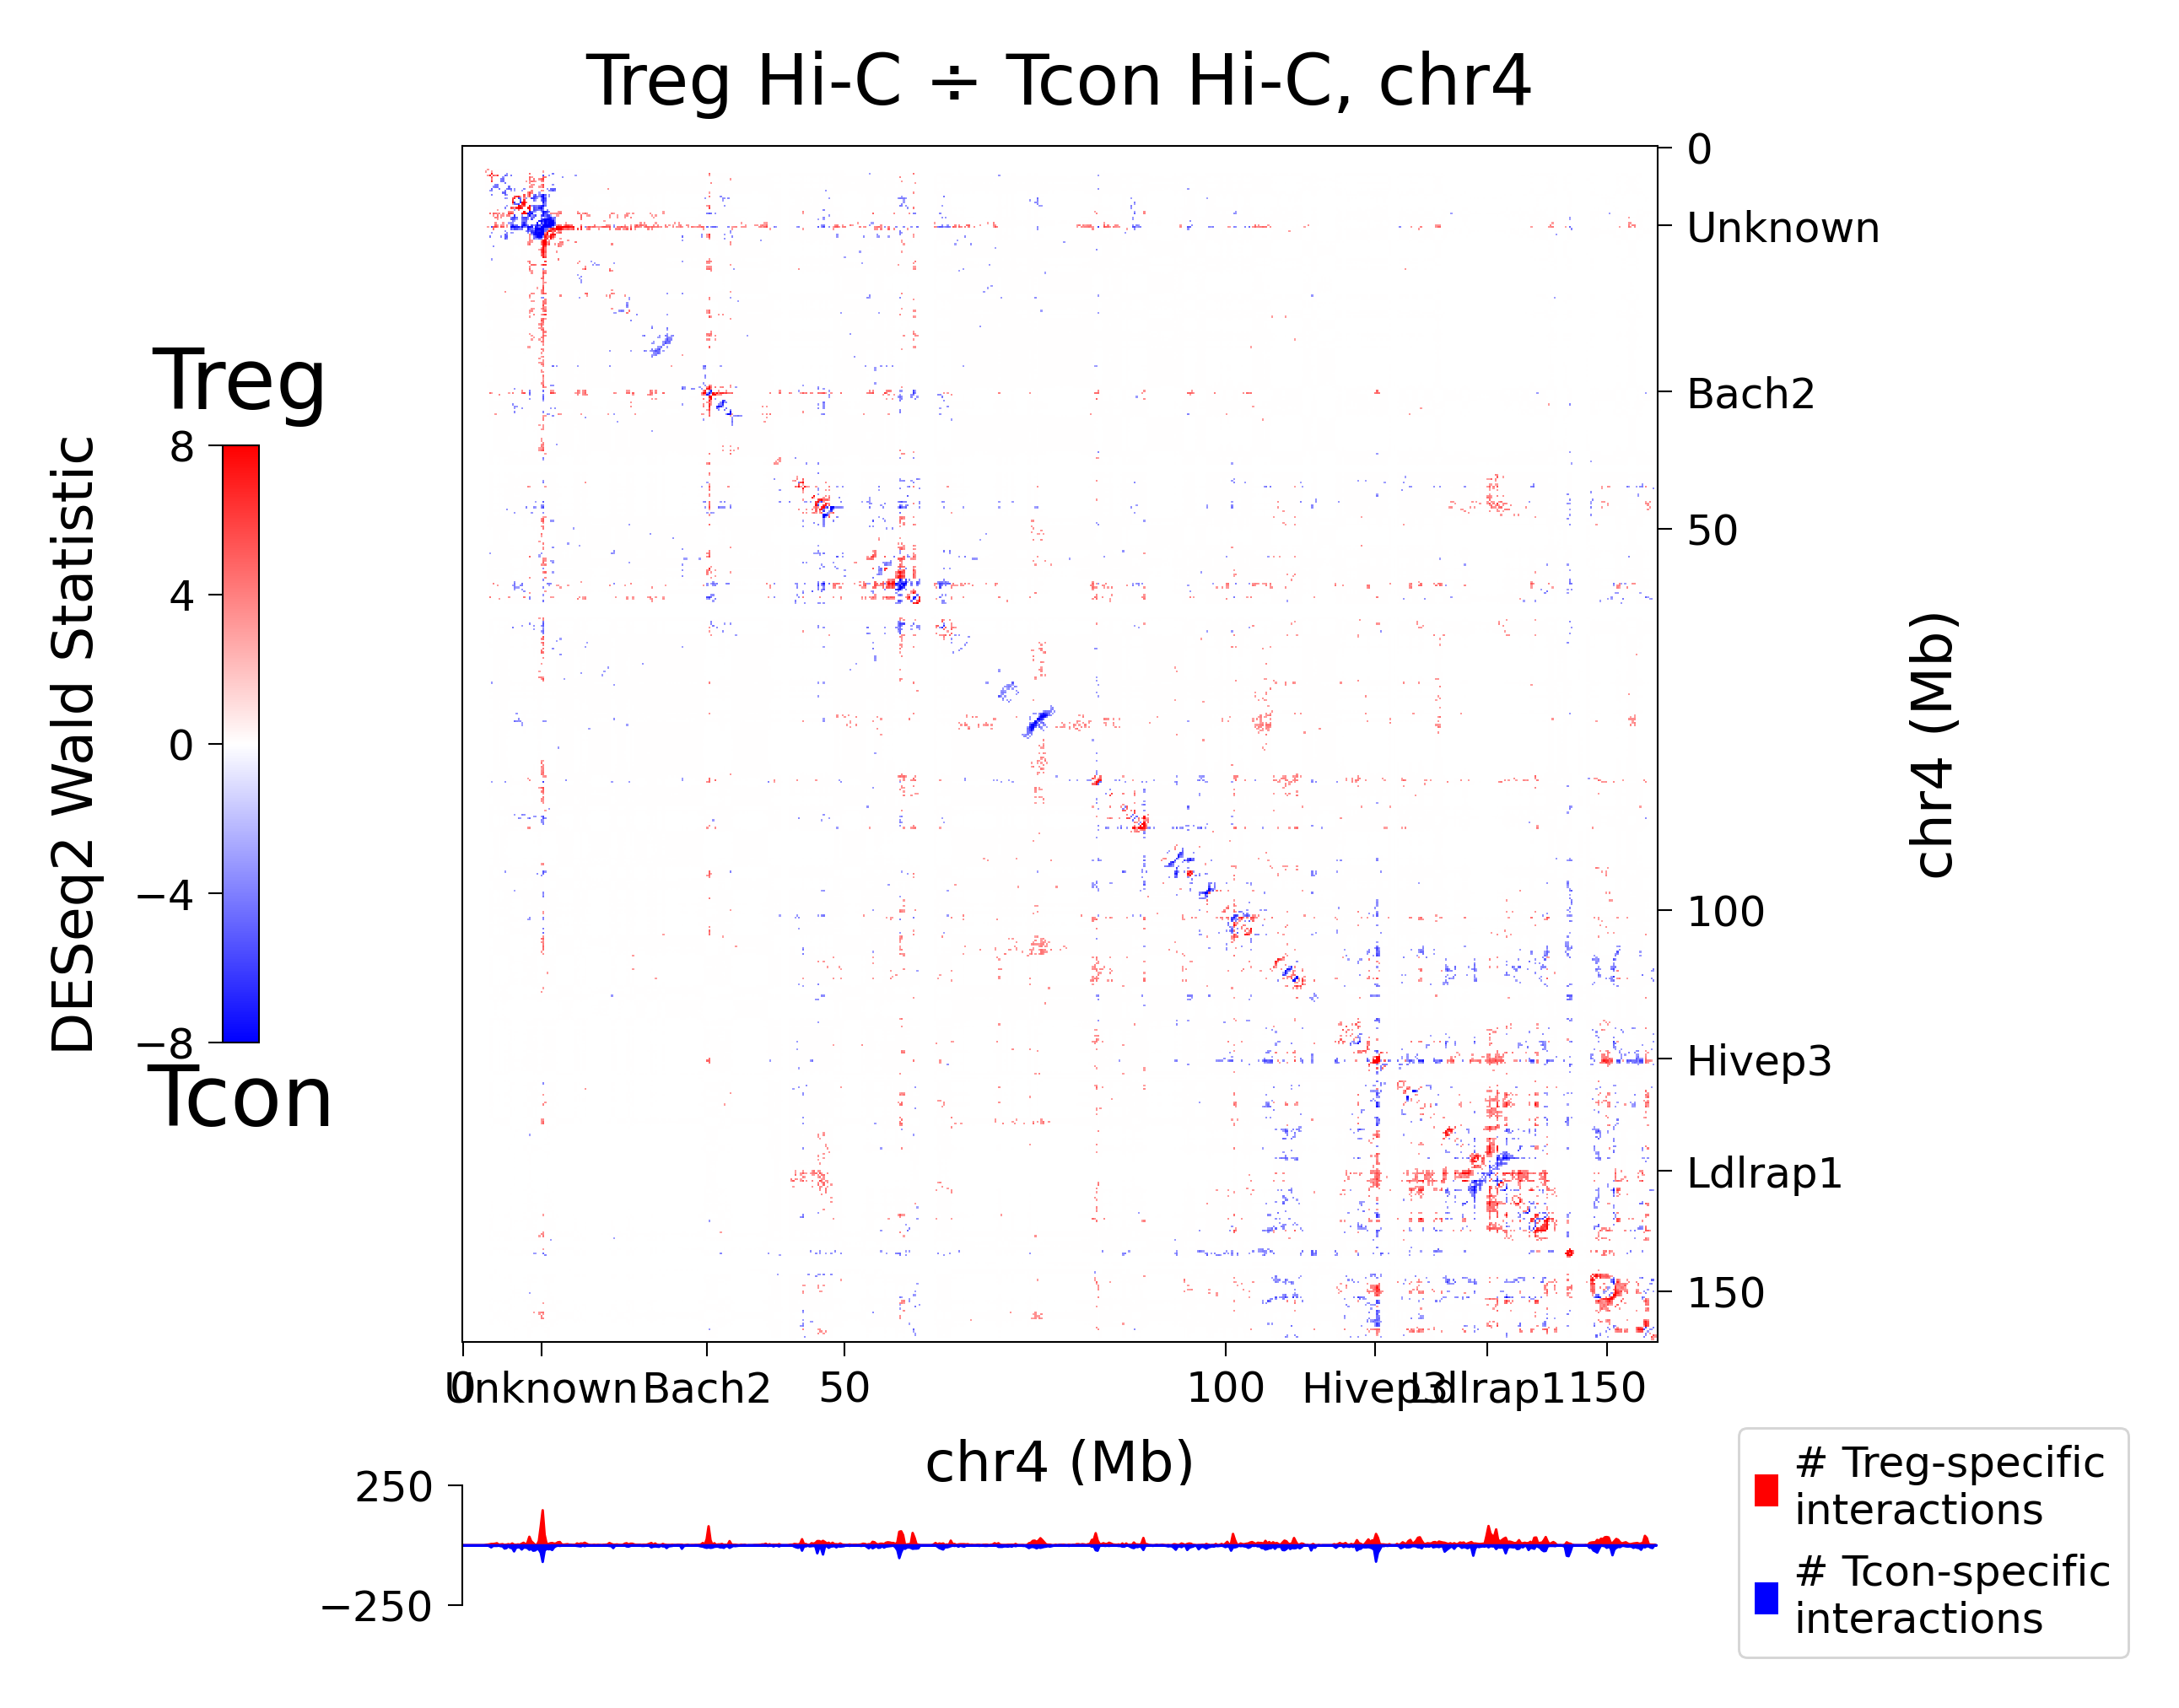

In [96]:
from supp_figures_plotting_functions import make_chromosomewide_deseq_plot

label_list = [[2281, 'Bach2'], [2194, 'Unknown'], [2631, 'Hivep3'], [2690, 'Ldlrap1']]
fig = make_chromosomewide_deseq_plot(deseq_effect_mat, deseq_pval_mat, '4', chrom_to_start, chrom_to_end, label_list, dpi = 300)
fig.savefig('./plots/paper/s8/chr4.pdf', bbox_inches='tight', dpi = 300)

2


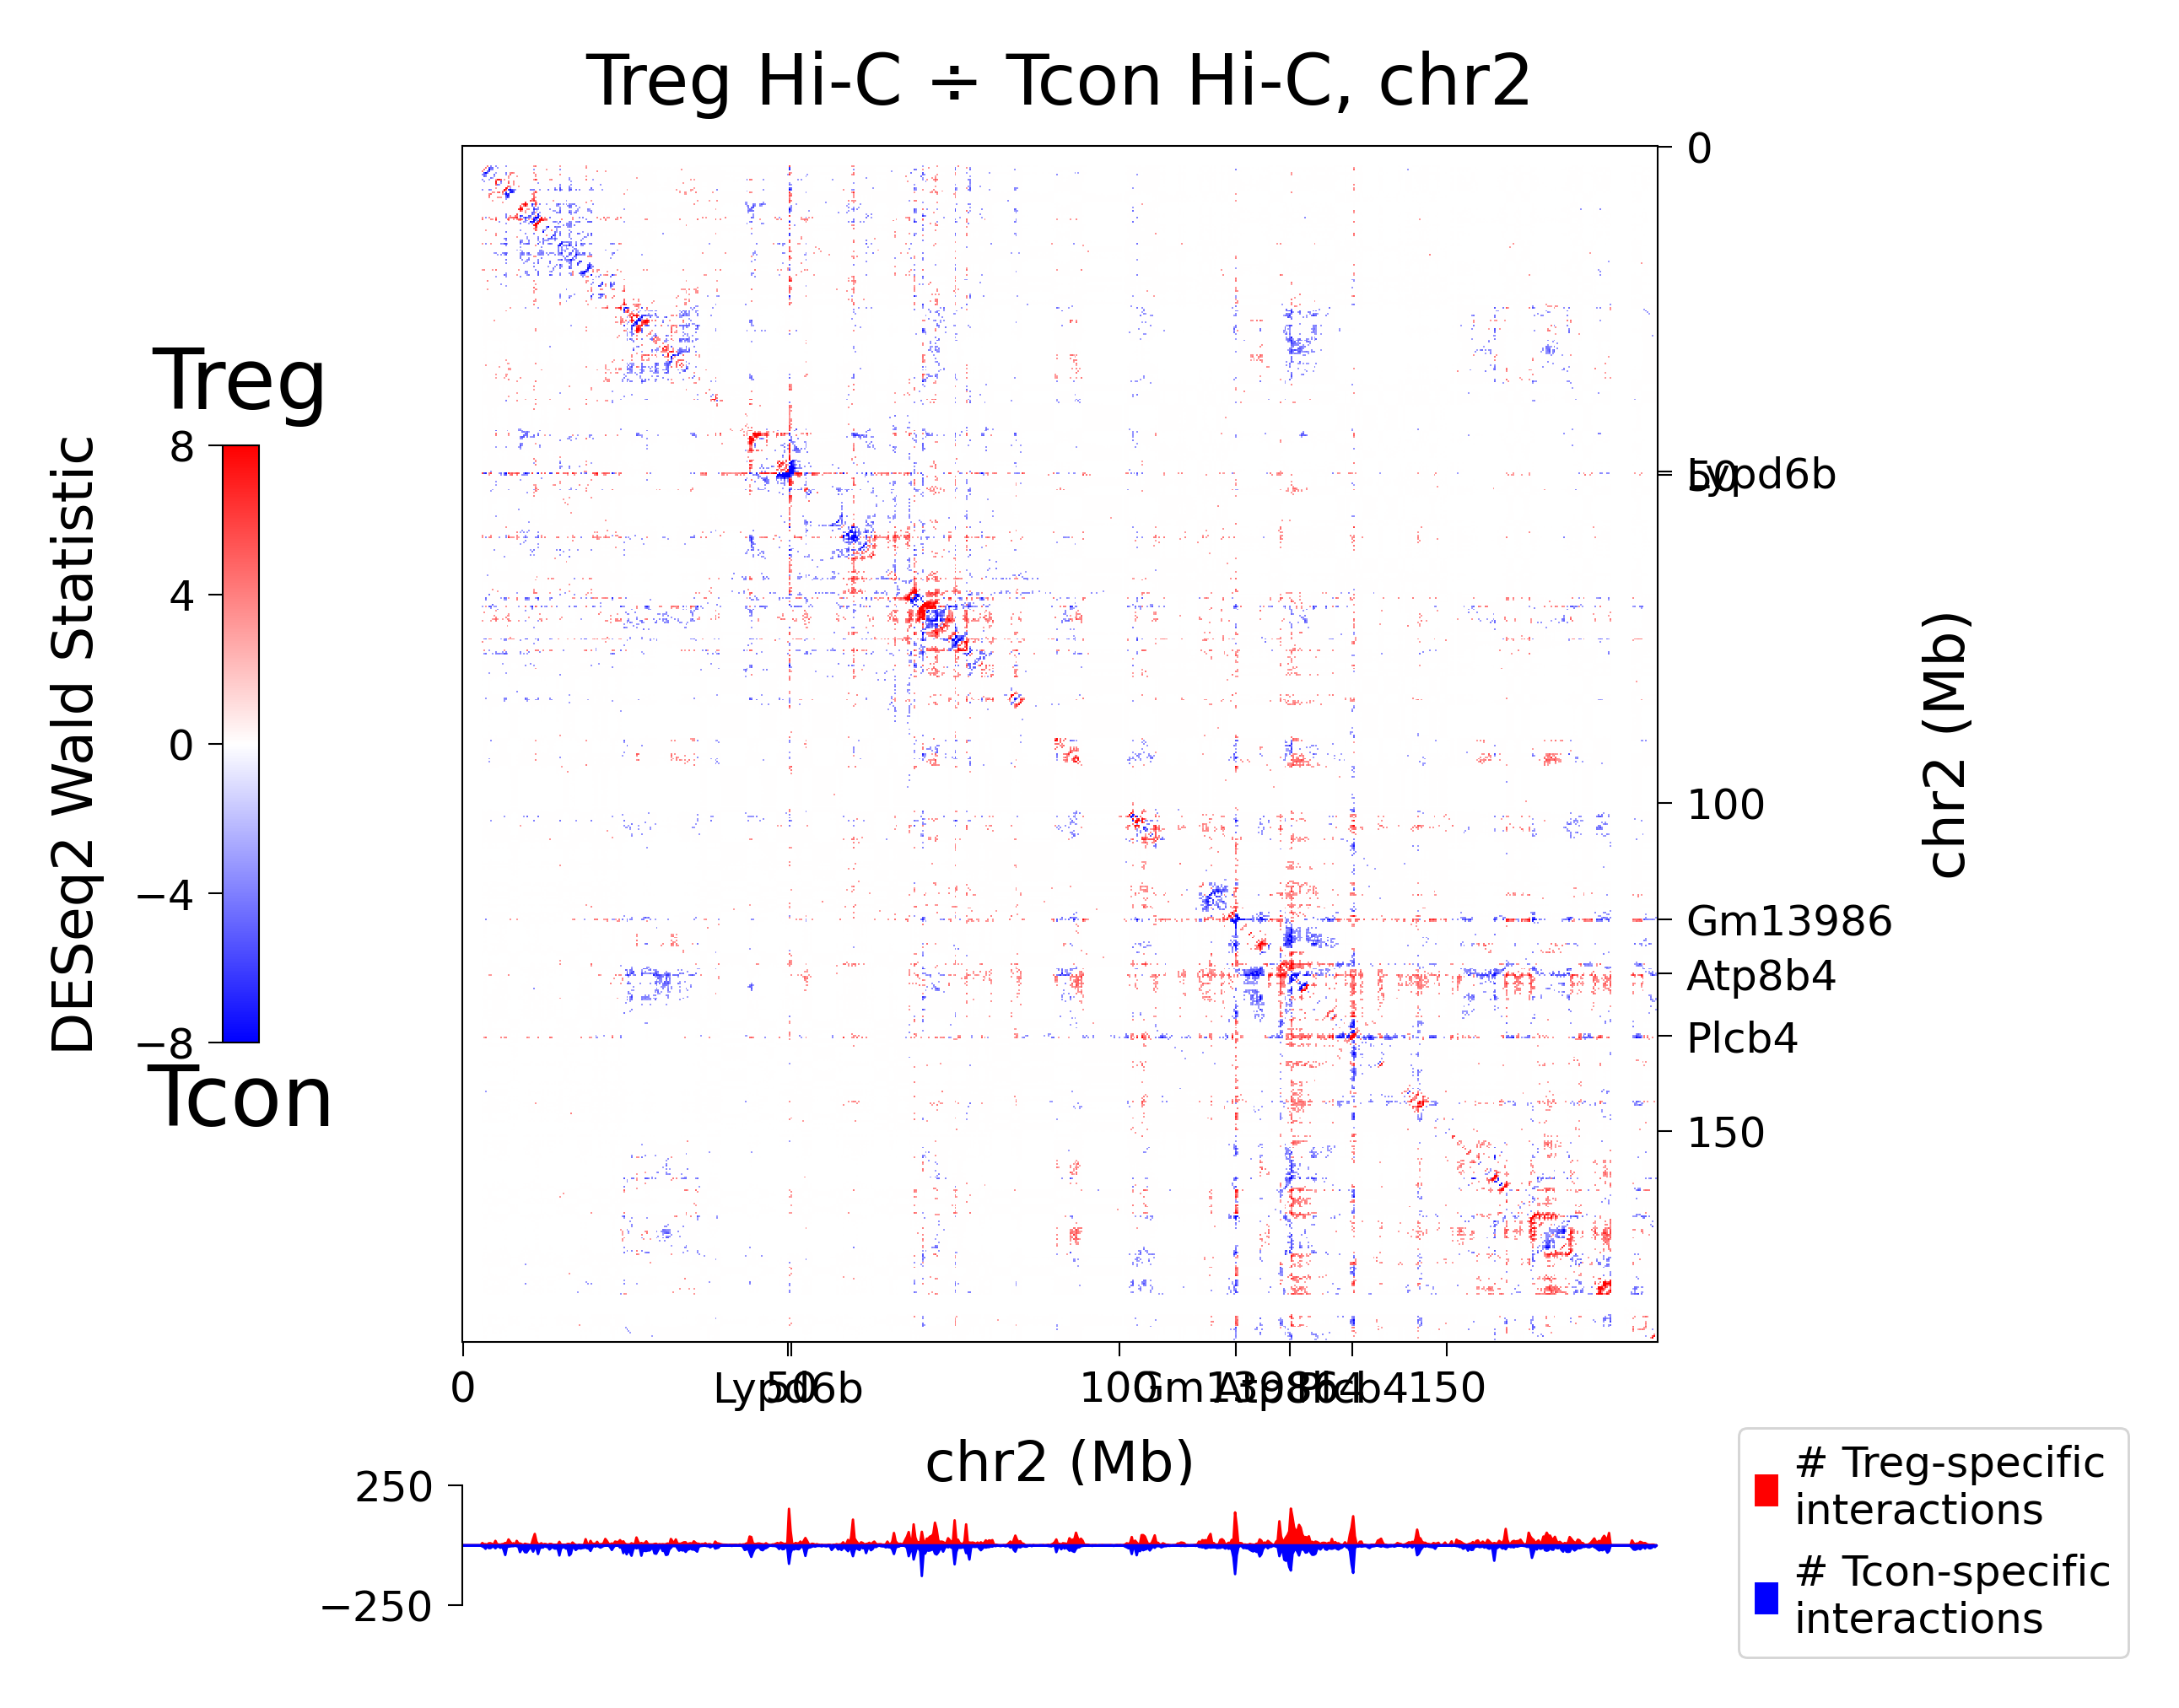

In [97]:
from supp_figures_plotting_functions import make_chromosomewide_deseq_plot

label_list = [[1287, 'Atp8b4'], [1254, 'Gm13986'], [981, 'Lypd6b'], [1325, 'Plcb4']]
fig = make_chromosomewide_deseq_plot(deseq_effect_mat, deseq_pval_mat, '2', chrom_to_start, chrom_to_end, label_list, dpi = 300)
fig.savefig('./plots/paper/s8/chr2.pdf', bbox_inches='tight', dpi = 300)

E-F. Differential interactions manhattan plots

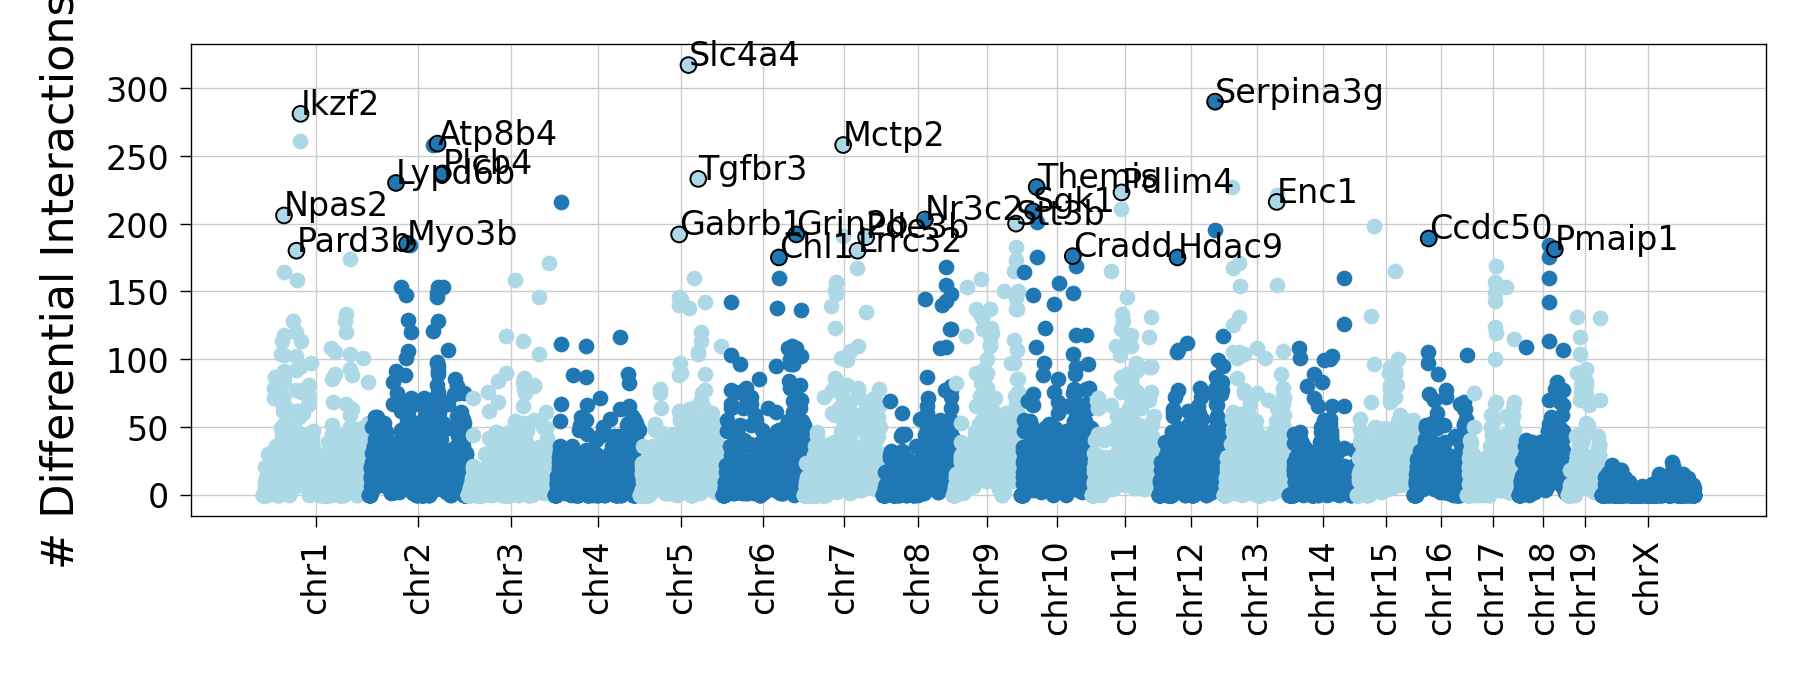

In [98]:
from supp_figures_plotting_functions import make_manhattan_plot

fig = make_manhattan_plot(deseq_pval_mat, all_ind_to_region, chrom_to_start, chrom_to_end, ind_to_gene, bin_cutoff=0, 
                          label_cutoff=175, dpi=200)
fig.savefig('./plots/paper/s8/manhattan_plot.pdf', bbox_inches='tight')

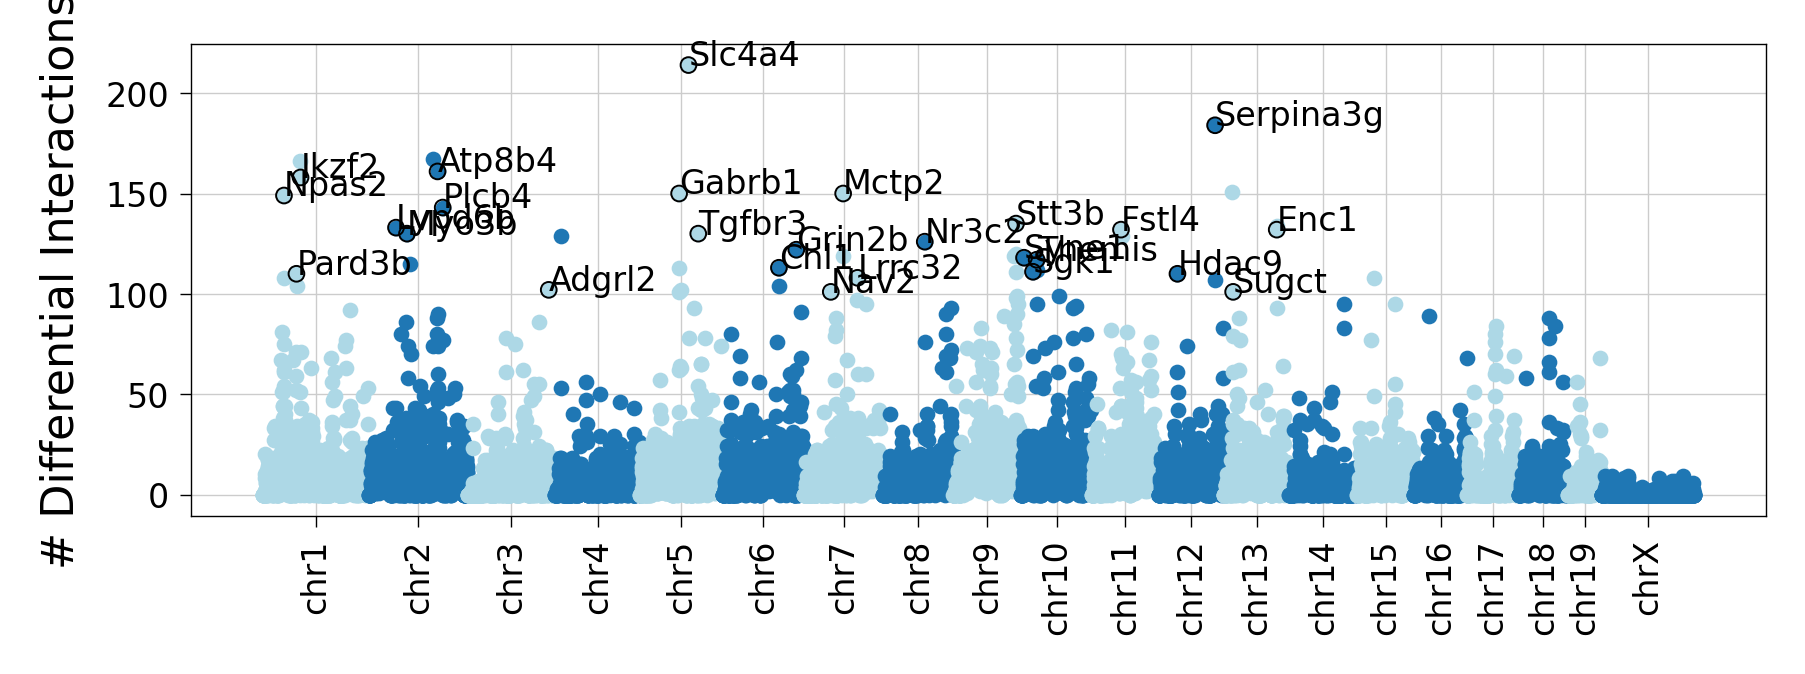

In [99]:
from supp_figures_plotting_functions import make_manhattan_plot

fig = make_manhattan_plot(deseq_pval_mat, all_ind_to_region, chrom_to_start, chrom_to_end, ind_to_gene, 
                          bin_cutoff=80, label_cutoff=100, dpi=200)
fig.savefig('./plots/paper/s8/manhattan_plot_distal.pdf', bbox_inches='tight')

G. Reproducibility of DESeq2

/Genomics/pritykinlab/gabe/jupys/tregs/./code/supp_figures_plotting_functions.py:1227: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  # cols = sns.color_palette('bwr', as_cmap=True)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/supp_figures_plotting_functions.py:1277: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ticks = list(np.arange(0, e-s, 200))
/Genomics/pritykinlab/gabe/jupys/tregs/./code/supp_figures_plotting_functions.py:1277: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ticks = list(np.arange(0, e-s, 200))


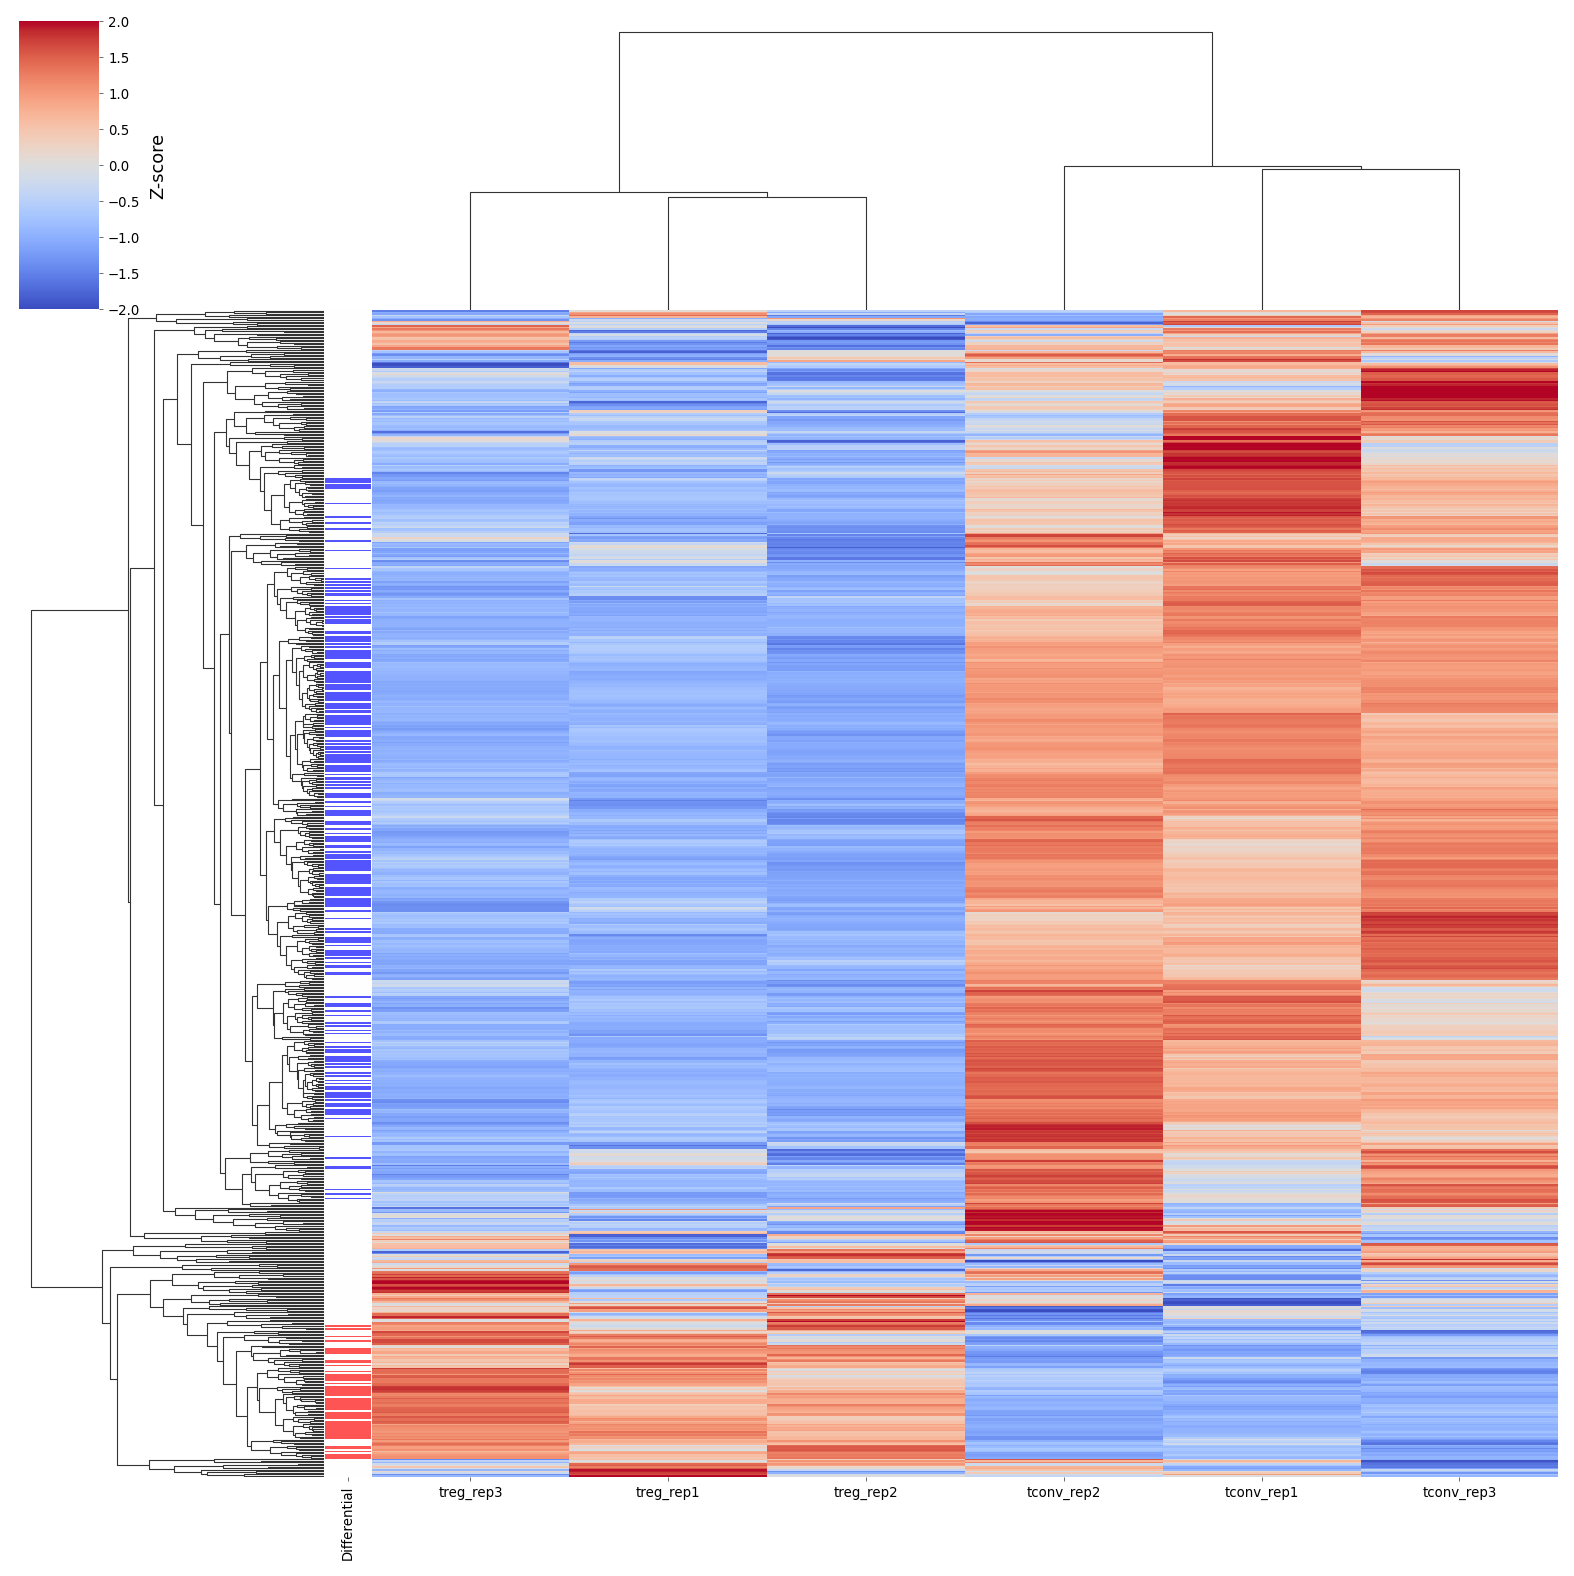

In [100]:
from supp_figures_plotting_functions import deseq2_reproducibility_heatmap

g = deseq2_reproducibility_heatmap(deseq_pval_mat, deseq_effect_mat)
g.cax.set_ylabel('Z-score')
g.fig.savefig('./plots/paper/s6/ikzf2_replicate_heatmap.pdf', bbox_inches='tight')


### S6

All plots for long-range contacts shown in "plot_metadomains" folder

### Figure S7

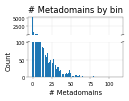

In [101]:
from supp_figures_plotting_functions import generate_metadomain_count_plot
generate_metadomain_count_plot(deseq_effect_mat, all_intra_metadomains, cutoff=4)

B. metadomain volcano plot

/Genomics/pritykinlab/gabe/jupys/tregs/./code/supp_figures_plotting_functions.py:1572: UserWarning: The following kwargs were not used by contour: 'label'
  plt.axhline(ACOMPARTMENT_CUTOFF_LOOSE, color='black', linestyle='--')


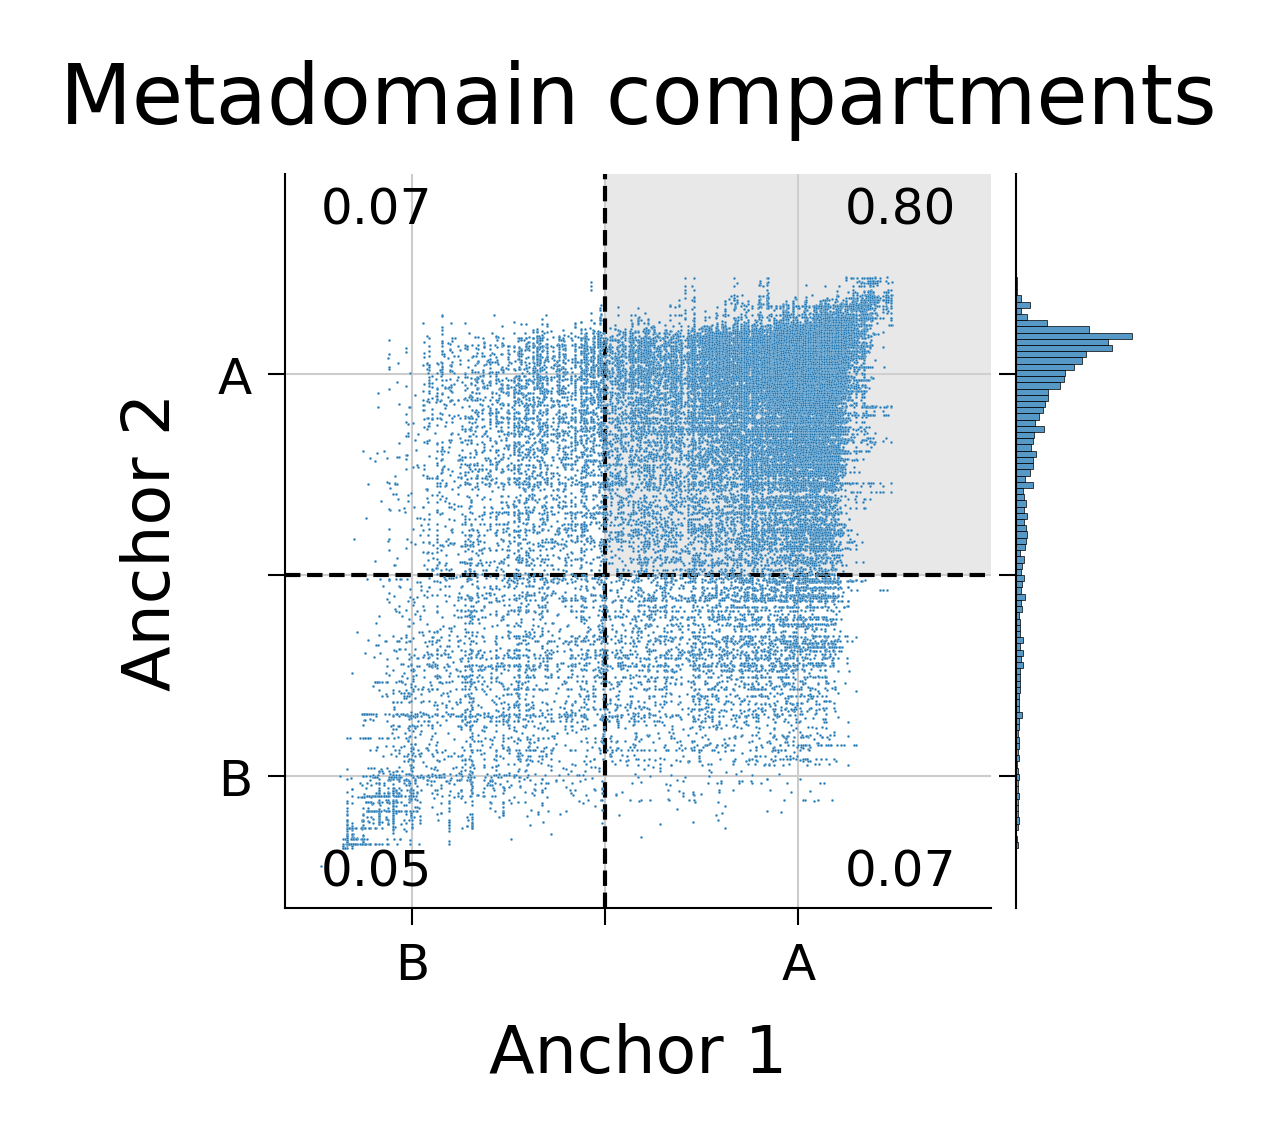

In [102]:
from supp_figures_plotting_functions import generate_metadomain_compartment_plot

fig = generate_metadomain_compartment_plot(all_intra_metadomains, my_treg_comp, ACOMPARTMENT_CUTOFF_LOOSE, )
fig.savefig('./plots/paper/s11/compartment_of_metadomains.pdf', dpi=1000)    

C. 

In [105]:
def make_shrunk_mat(input_mat, chrom_n, binarize=True, sum=True):
    created_n = len(input_mat)
    fullmat = np.zeros((5*chrom_n, 5*chrom_n))
    if binarize:
        fullmat[:created_n, :created_n] = (input_mat > 0)
    else:
        fullmat[:created_n, :created_n] = (input_mat)
    if sum:
        shrunkmat = fullmat.reshape(chrom_n, 5, chrom_n, 5).sum(axis=(1, 3))
    else:
        shrunkmat = fullmat.reshape(chrom_n, 5, chrom_n, 5).max(axis=(1, 3))
    return shrunkmat

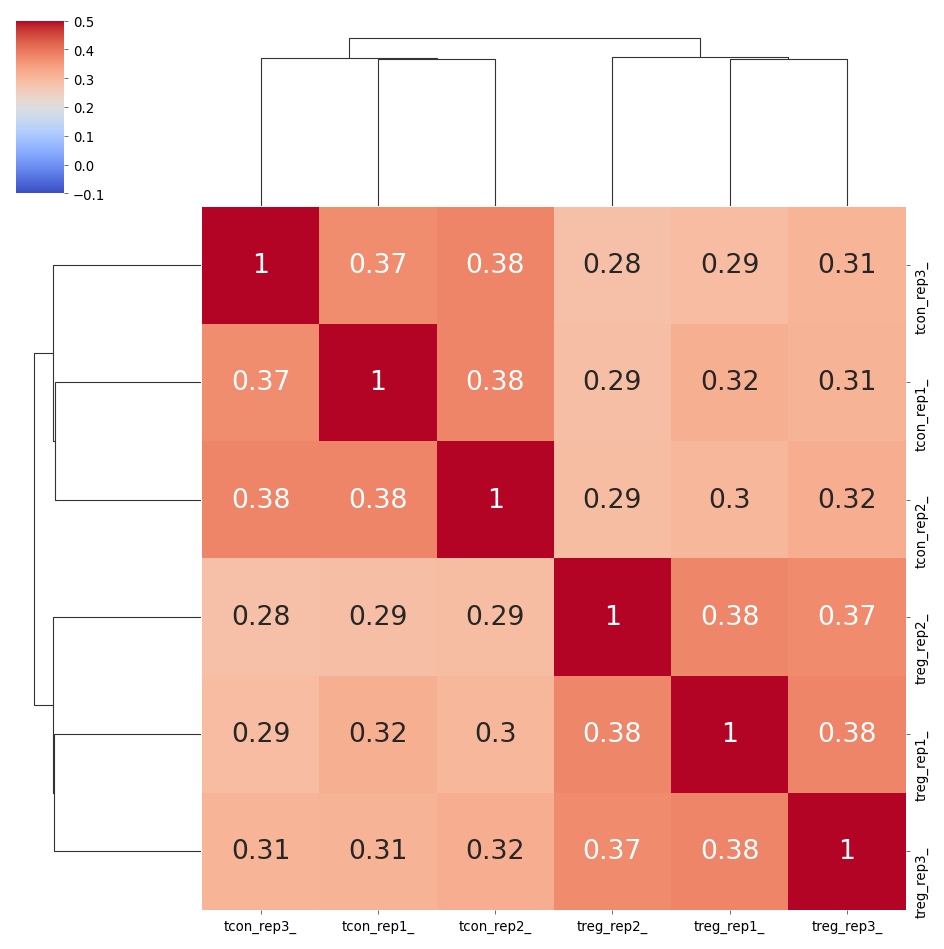

In [106]:

metadomain_mat_pref = './metadomain_prominent_peak_output/'
n = len(all_ind_to_region)

all_dataframes = []
for rep in ['treg_rep1_', 'treg_rep2_', 'treg_rep3_', 'treg_', 'tcon_rep1_', 'tcon_rep2_', 'tcon_rep3_', 'tcon_',]:
    for chrom in PARSED_CHROMS_nochr:
        s, e = chrom_to_start[chrom], chrom_to_end[chrom]
        chrom_n = e - s
        mat = np.load(f'{metadomain_mat_pref}/{rep}res=50000_intrachromosomal_chrL={chrom}_chrR={chrom}_collapsed_logp_mat.npy')
        shrunkmat = make_shrunk_mat(mat, chrom_n)
        i, j = np.where(shrunkmat)
        data = pd.DataFrame()
        data['i'] = i
        data['j'] = j
        data['chrom'] = chrom
        data['rep'] = rep
        all_dataframes.append(data)
results = pd.concat(all_dataframes, axis=0).value_counts(['i', 'j', 'chrom', 'rep']).reset_index(
    ).pivot(columns=['i', 'j', 'chrom'], index=['rep']).fillna(0)

jac_coeffs = pd.DataFrame()
conds = ['treg_rep1_', 'treg_rep2_', 'treg_rep3_', 'tcon_rep1_', 'tcon_rep2_', 'tcon_rep3_']
for i in conds:
    jacs = []
    for j in conds:
        num = ((results.loc[i]>0) & (results.loc[j]>0)).sum()
        den = ((results.loc[i]>0) | (results.loc[j]>0)).sum()
        jac = num / den
        jacs.append(jac)
    jac_coeffs[i] = jacs
jac_coeffs.index = jac_coeffs.columns

g = sns.clustermap(jac_coeffs, vmax=.5, cmap='coolwarm', vmin=-.1, annot=True, figsize=(6, 6))
g.fig.savefig('./plots/paper/s11/metadomain_reproducibility.pdf', bbox_inches='tight')

D. 

/Genomics/pritykinlab/gabe/jupys/tregs/./code/volcano_plot.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(x, y, zorder = 3, c = colors, linewidth=0, s = s, rasterized=rasterized, vmin=vmin, vmax=vmax, alpha=alpha)


ignoring None-Ptprt
ignoring Themis-None
ignoring None-Dusp6
ignoring Ankmy2-Dock4
ignoring Ank-None
ignoring Ank-None
ignoring Trio-None
ignoring Trio-None
ignoring Rftn1-None
ignoring None-None
ignoring Csnk1g3-Lmnb1
ignoring None-None


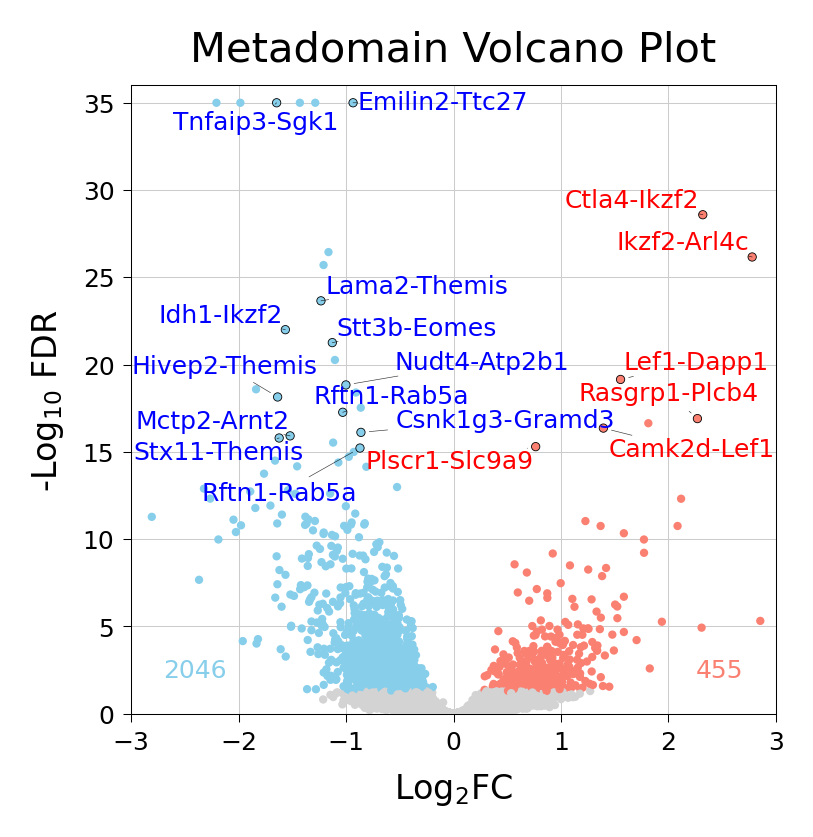

In [107]:
from volcano_plot import volcano_plot
from supp_figures_plotting_functions import generate_metadomain_volcano_plot

ignore_set = { 'Trio-Ctnnd2', 'Ank-Ctnnd2', 'Fam105a-Ctnnd2', 'Dazl-Kcnh8', 'AY702103-Efhb', 'Ankmy2-Dock4', 'Csnk1g3-Lmnb1', 'Mctp2-Cemip' }
generate_metadomain_volcano_plot(all_intra_metadomains,  deseq_lfc_mat,  deseq_pval_mat,  
                               ind_to_gene,  ignore_set,  './plots/paper/s11/intra_volcano_plot.pdf')

E. Pileup shown in "Pileup_Intra pileup"

F.

Imported plotting functions


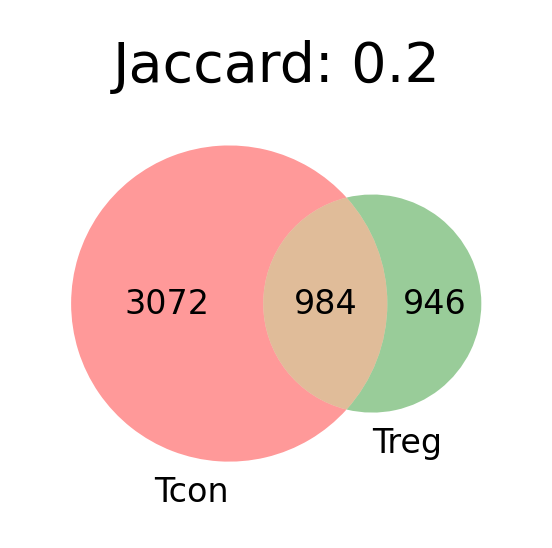

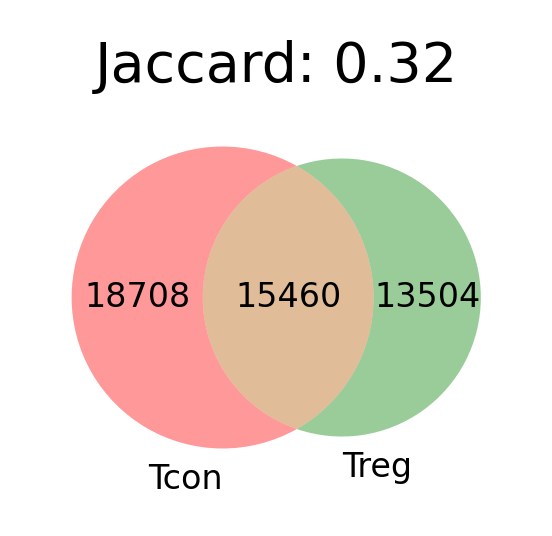

In [109]:
from supp_figures_plotting_functions import generate_metadomain_venn_diagrams

generate_metadomain_venn_diagrams(deseq_pval_mat, all_intra_treg_metadomains, all_intra_tcon_metadomains)

### Figure S8

A-B. Chromosome heatmap clustering

/Genomics/pritykinlab/gabe/jupys/tregs/./code/aux_functions.py:219: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = scipy.cluster.hierarchy.linkage(matrix, method=method, metric=metric)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/aux_functions.py:222: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  ordering = scipy.cluster.hierarchy.optimal_leaf_ordering(linkage, matrix)


# bins: 198


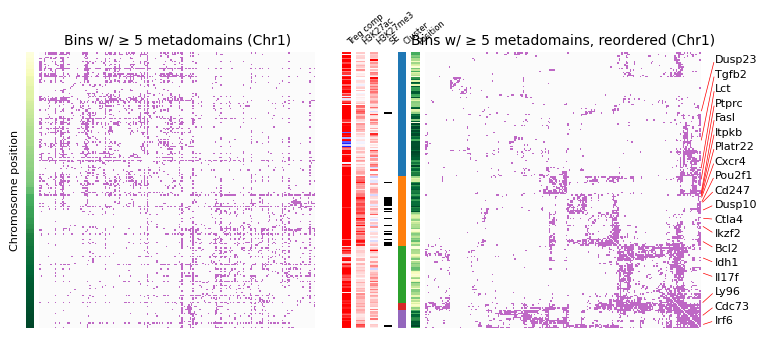

In [120]:
from supp_figures_plotting_functions import generate_chromosome_heatmap
logging.getLogger().setLevel(logging.CRITICAL)
intra_clustering = generate_chromosome_heatmap('1', all_intra_metadomains, gene_to_ind, SE_count, bw_val_df_all_250kb, 
                            my_treg_comp, chrom_to_start, chrom_to_end, cutoff=5, dpi=50,
                                              n_clusters=5)

/Genomics/pritykinlab/gabe/jupys/tregs/./code/aux_functions.py:219: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = scipy.cluster.hierarchy.linkage(matrix, method=method, metric=metric)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/aux_functions.py:222: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  ordering = scipy.cluster.hierarchy.optimal_leaf_ordering(linkage, matrix)


# bins: 169


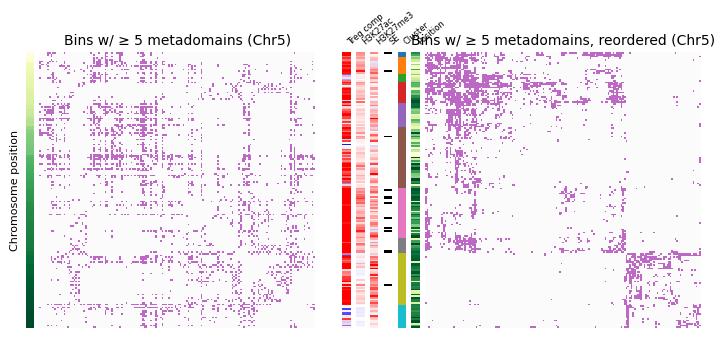

In [121]:
!mkdir -p plots/paper/s12

generate_chromosome_heatmap('5', all_intra_metadomains, gene_to_ind, SE_count, bw_val_df_all_250kb, 
                            my_treg_comp, chrom_to_start, chrom_to_end, cutoff=5, dpi=50);

/Genomics/pritykinlab/gabe/jupys/tregs/./code/aux_functions.py:219: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = scipy.cluster.hierarchy.linkage(matrix, method=method, metric=metric)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/aux_functions.py:222: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  ordering = scipy.cluster.hierarchy.optimal_leaf_ordering(linkage, matrix)


# bins: 205


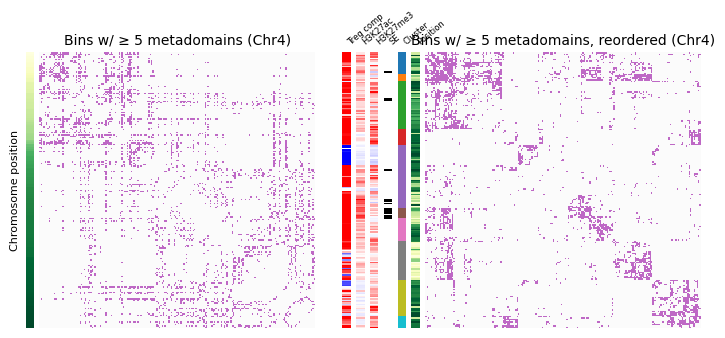

In [122]:
from supp_figures_plotting_functions import generate_chromosome_heatmap

generate_chromosome_heatmap('4', all_intra_metadomains, gene_to_ind, SE_count, bw_val_df_all_250kb, 
                            my_treg_comp, chrom_to_start, chrom_to_end, cutoff=5, dpi=50);

/Genomics/pritykinlab/gabe/jupys/tregs/./code/aux_functions.py:219: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = scipy.cluster.hierarchy.linkage(matrix, method=method, metric=metric)
/Genomics/pritykinlab/gabe/jupys/tregs/./code/aux_functions.py:222: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  ordering = scipy.cluster.hierarchy.optimal_leaf_ordering(linkage, matrix)


# bins: 203


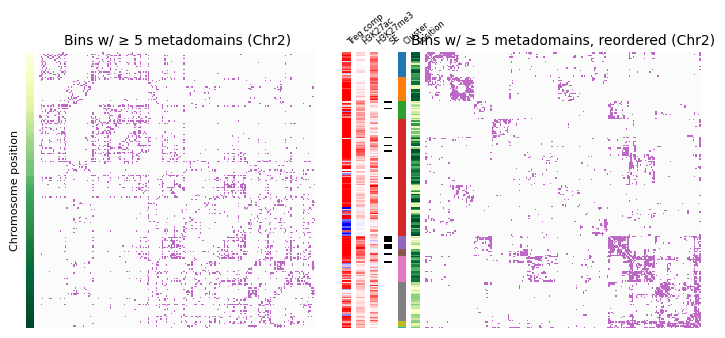

In [123]:
from supp_figures_plotting_functions import generate_chromosome_heatmap

generate_chromosome_heatmap('2', all_intra_metadomains, gene_to_ind, SE_count, bw_val_df_all_250kb, 
                            my_treg_comp, chrom_to_start, chrom_to_end, cutoff=5, dpi=50);

### Figure S9


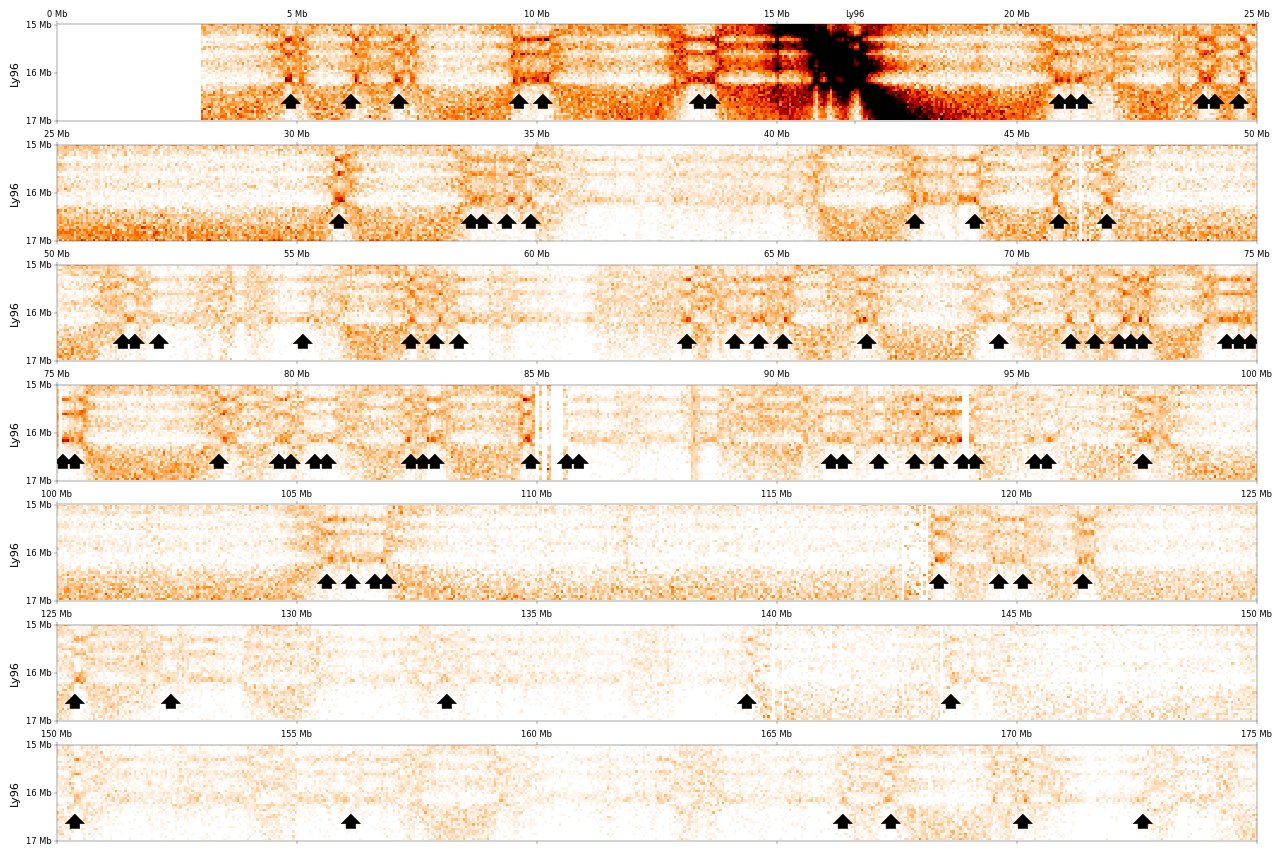

In [126]:
!mkdir -p ./plots/paper/s13
from supp_figures_plotting_functions import make_wrapped_plot

fig = make_wrapped_plot(inter_and_intra_metadomains, treg_50kb, all_ind_to_region, chrom_to_start, 
                      chrom_to_end, og_ind=66, compare_with = '1', dpi = 50, gene='Ly96')
fig.savefig('./plots/paper/s13/ly96_chr1_wrapped_plot.pdf', bbox_inches='tight')

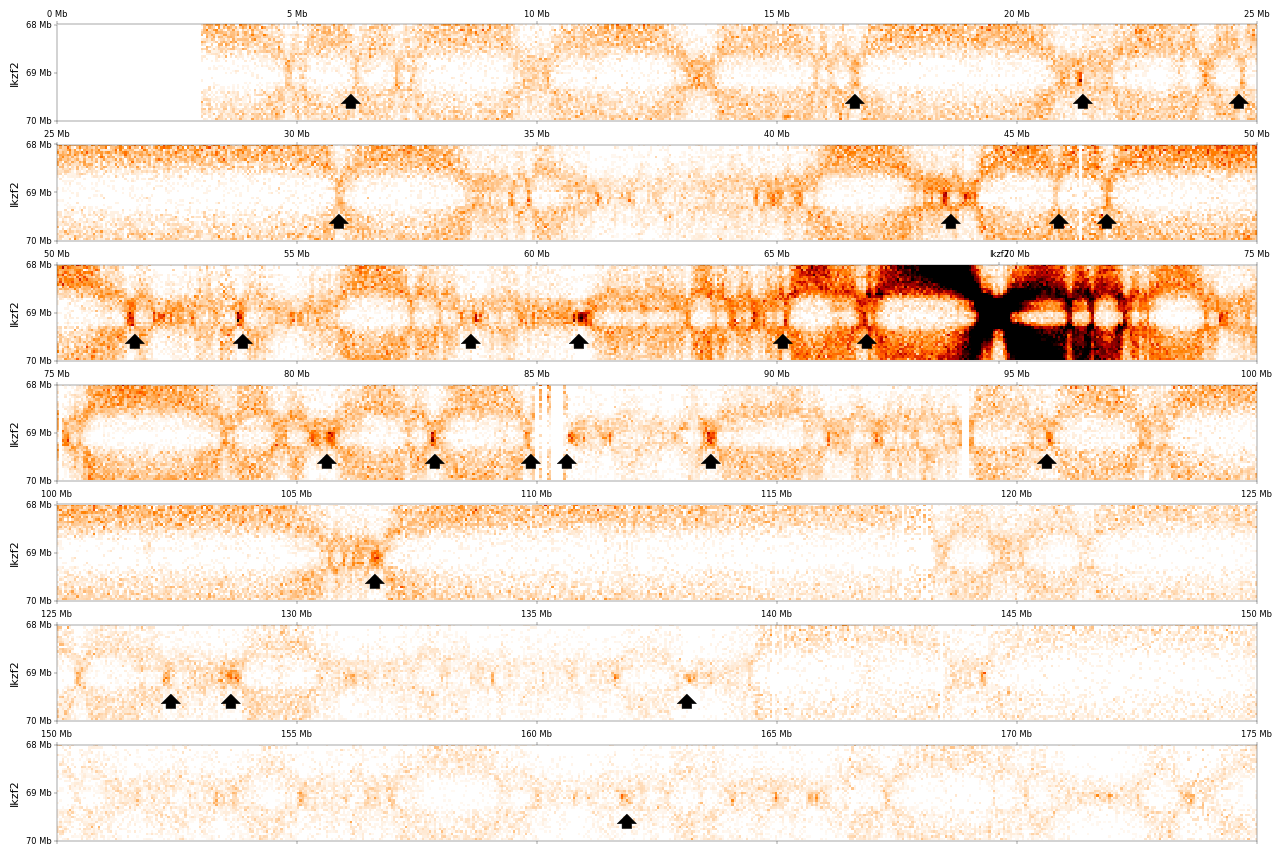

In [127]:
fig = make_wrapped_plot(inter_and_intra_metadomains, treg_50kb, all_ind_to_region, chrom_to_start, 
                      chrom_to_end, og_ind=278, compare_with = '1', dpi = 50, gene='Ikzf2')
fig.savefig('./plots/paper/s13/ikzf2_chr1_wrapped_plot.pdf', bbox_inches='tight')

### Figure S10

A. Hi-C plots shown in Final_Plot Metadomains

B. Pileup shown in Pileup_Intra metadomains

C. 

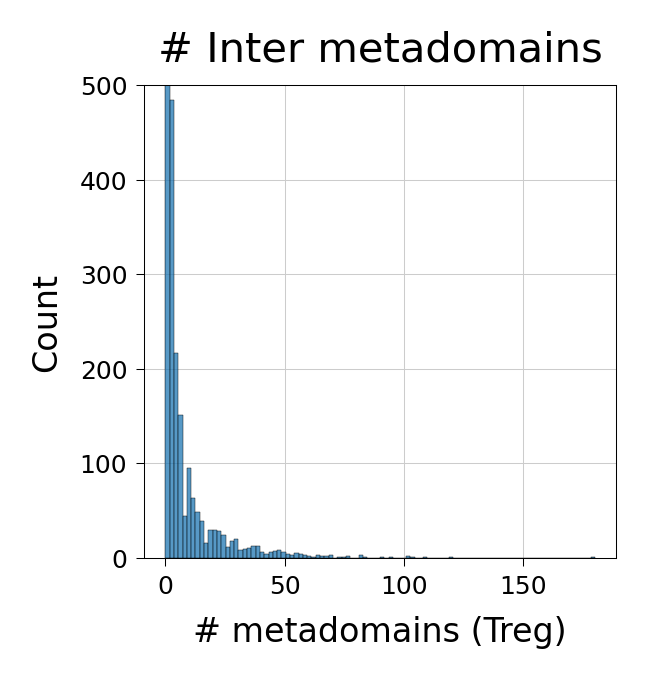

In [128]:
from supp_figures_plotting_functions import inter_metadomain_barplot

inter_metadomain_barplot(all_inter_treg_metadomains);

D-E.

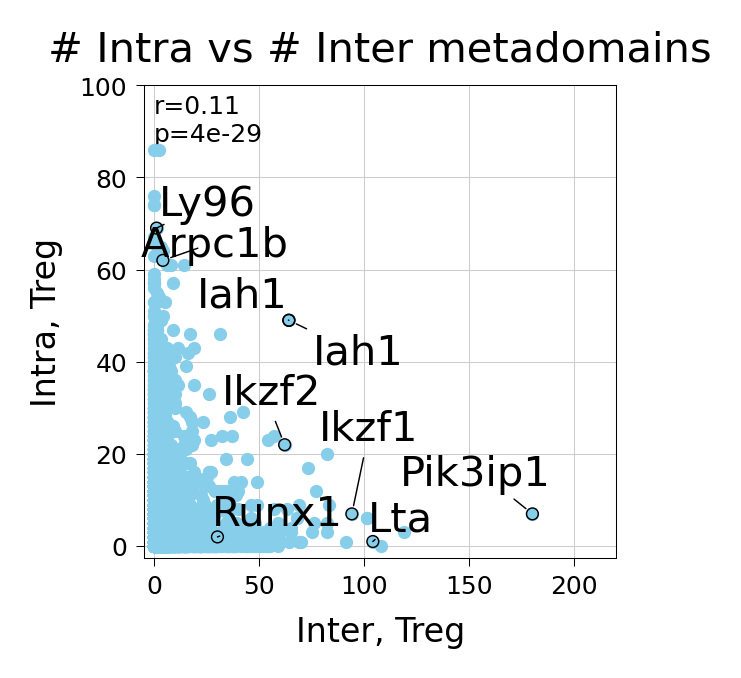

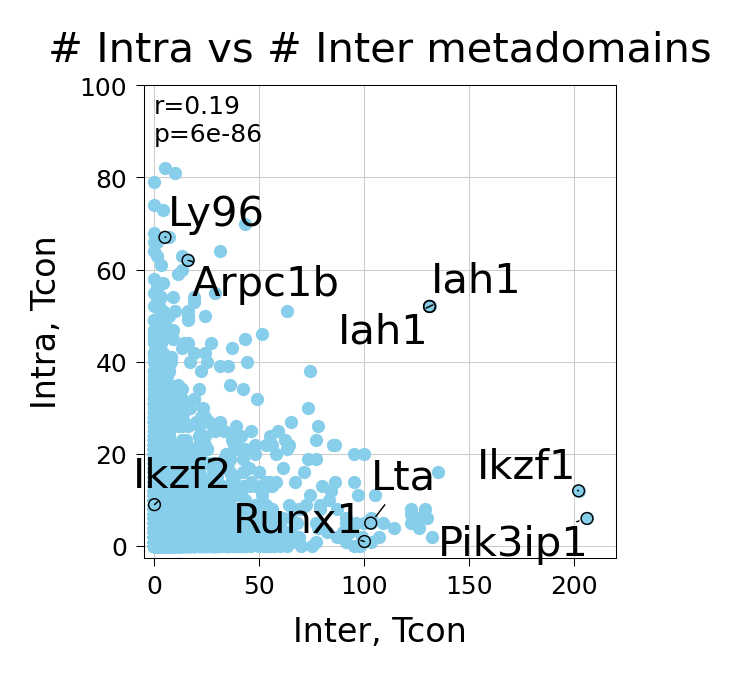

In [136]:
from supp_figures_plotting_functions import inter_intra_metadomains

fig = inter_intra_metadomains(all_inter_treg_metadomains, all_intra_treg_metadomains, ind_to_gene, celltype='Treg')
fig.savefig('./plots/paper/s14/number_treg_intra_inter_metadomains.pdf', bbox_inches = 'tight', dpi=1000)

fig = inter_intra_metadomains(all_inter_tcon_metadomains, all_intra_tcon_metadomains, ind_to_gene, celltype='Tcon')
fig.savefig('./plots/paper/s14/number_tcon_intra_inter_metadomains.pdf', bbox_inches = 'tight', dpi=1000)

F.

Imported plotting functions


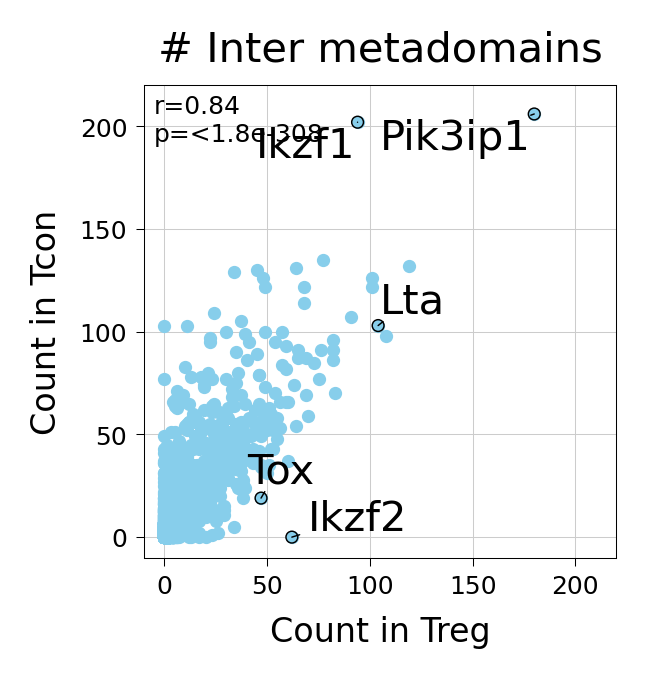

In [137]:
from supp_figures_plotting_functions import treg_tcon_inter_metadomains

fig = treg_tcon_inter_metadomains(all_inter_treg_metadomains, all_inter_tcon_metadomains, ind_to_gene)
fig.savefig('./plots/paper/s14/treg_tcon_inter_metadomains.pdf', bbox_inches = 'tight',
           dpi=1000)

G. 

/Genomics/pritykinlab/gabe/jupys/tregs/./code/supp_figures_plotting_functions.py:1993: RuntimeWarning: invalid value encountered in divide
  x, y = np.ravel(np.log2(1+bw_val_df_all_250kb[key])), delta


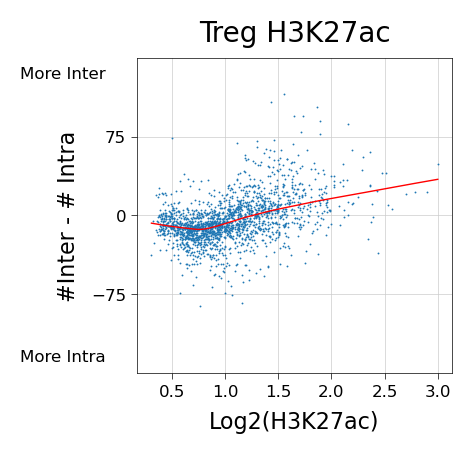

In [138]:
from supp_figures_plotting_functions import inter_vs_intra_h3k27ac_scatterplot

fig = inter_vs_intra_h3k27ac_scatterplot(all_intra_treg_metadomains, all_inter_treg_metadomains, 
                                   all_intra_metadomains, all_inter_metadomains, bw_val_df_all_250kb)
fig.savefig('./plots/paper/s15/inter_vs_intra_h3k27ac_scatter.pdf', bbox_inches = 'tight', dpi = 300)

H. 

/Genomics/pritykinlab/gabe/jupys/tregs/./code/supp_figures_plotting_functions.py:1959: RuntimeWarning: invalid value encountered in divide
  x, y = np.ravel(np.log2(1+bw_val_df_all_250kb[key])), delta


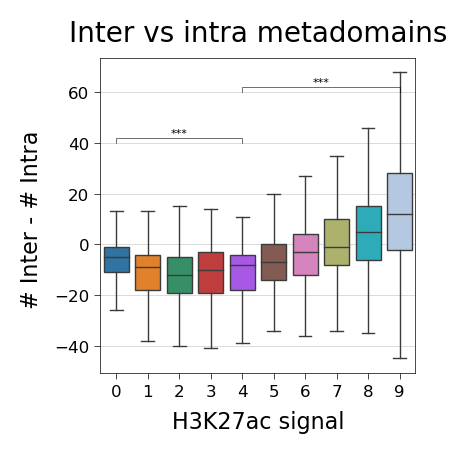

In [139]:
from supp_figures_plotting_functions import inter_vs_intra_h3k27ac_boxplot

fig = inter_vs_intra_h3k27ac_boxplot(all_intra_treg_metadomains, all_inter_treg_metadomains, 
                                   all_intra_metadomains, all_inter_metadomains, bw_val_df_all_250kb)
fig.savefig('./plots/paper/s15/inter_vs_intra_h3k27ac_box.pdf', bbox_inches = 'tight', dpi = 300)

I. 

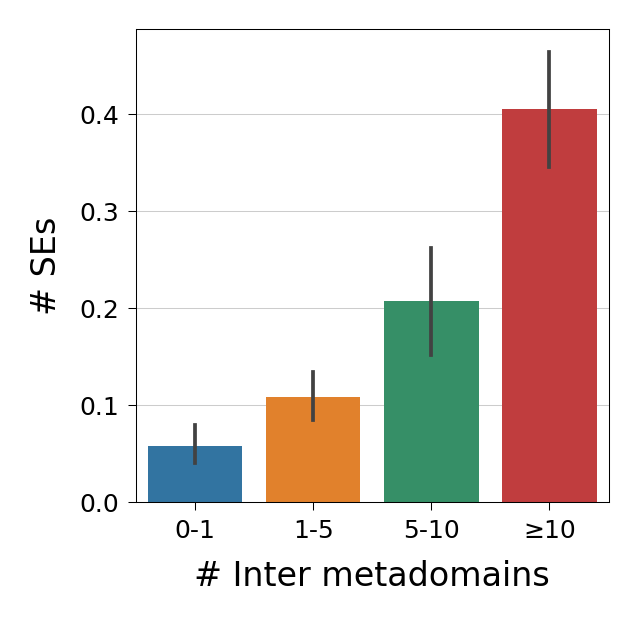

In [140]:
from supp_figures_plotting_functions import inter_metadomains_vs_SE

fig = inter_metadomains_vs_SE(all_inter_treg_metadomains, SE_count)
fig.savefig('./plots/paper/s14/treg_inter_metadomains_vs_SE.pdf', bbox_inches = 'tight',
           dpi=1000)

### Figure S11

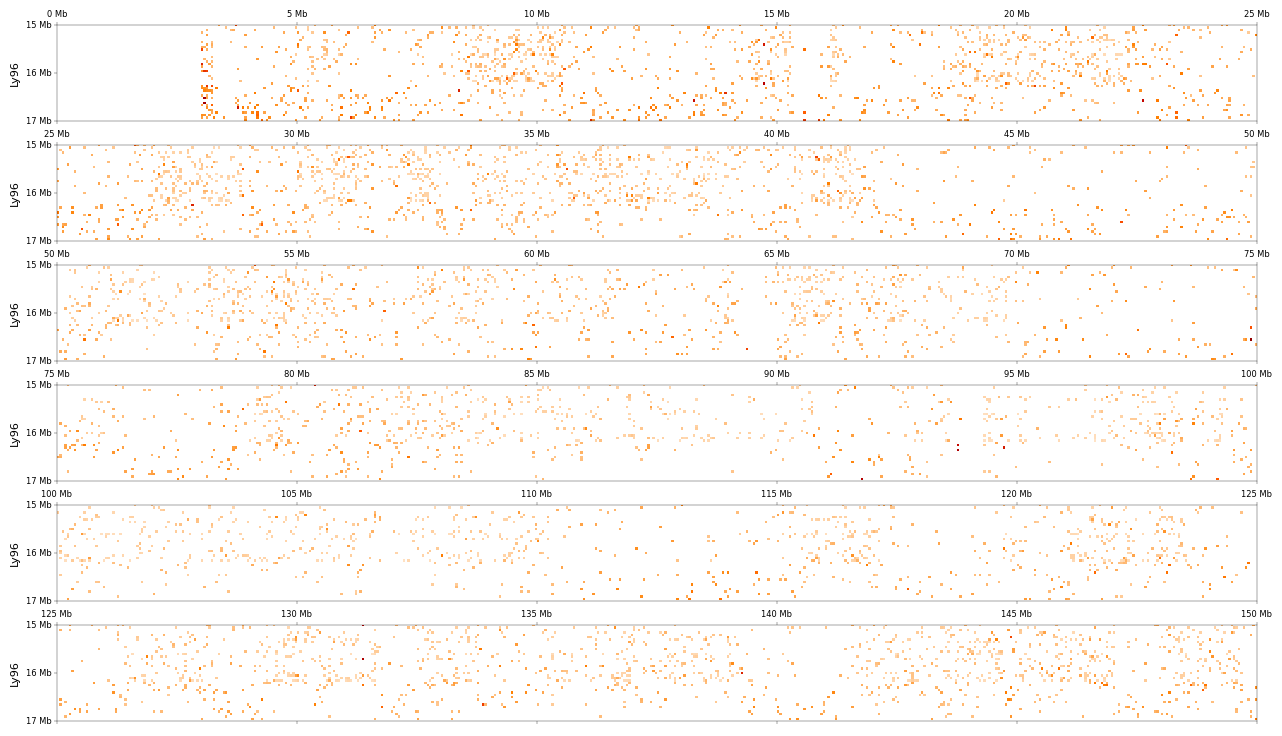

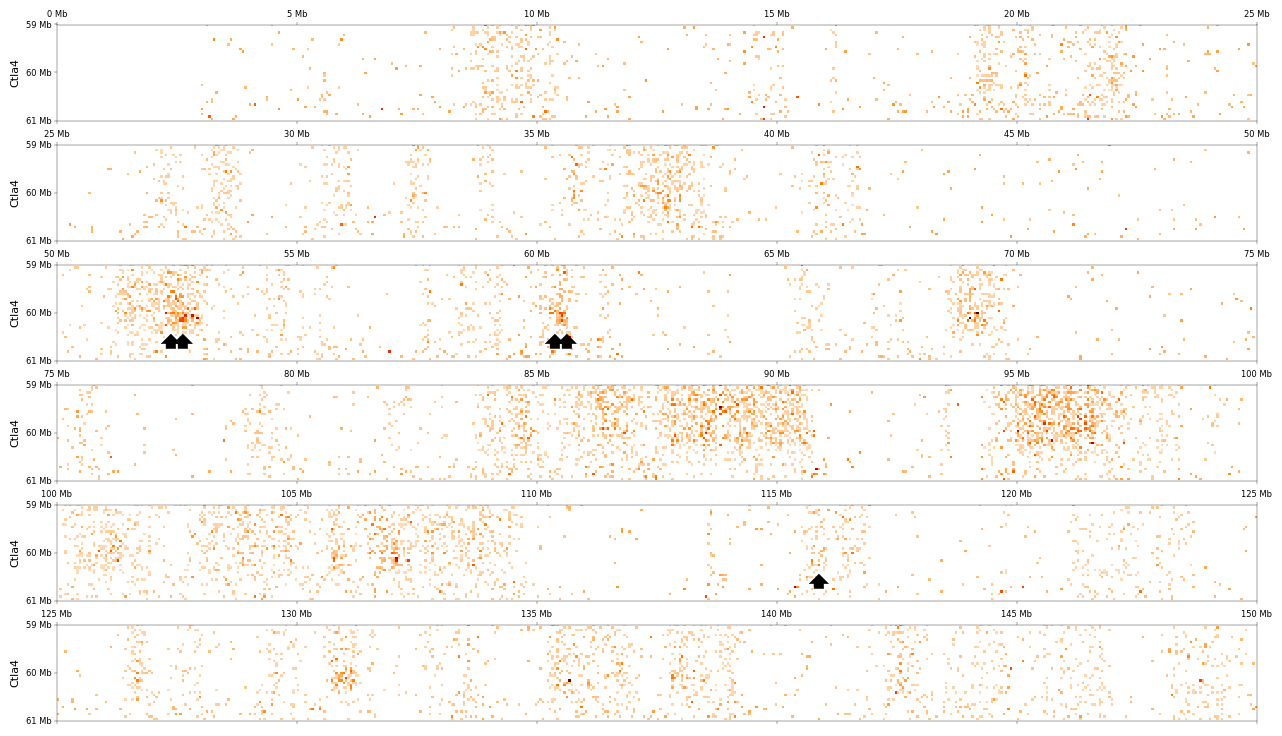

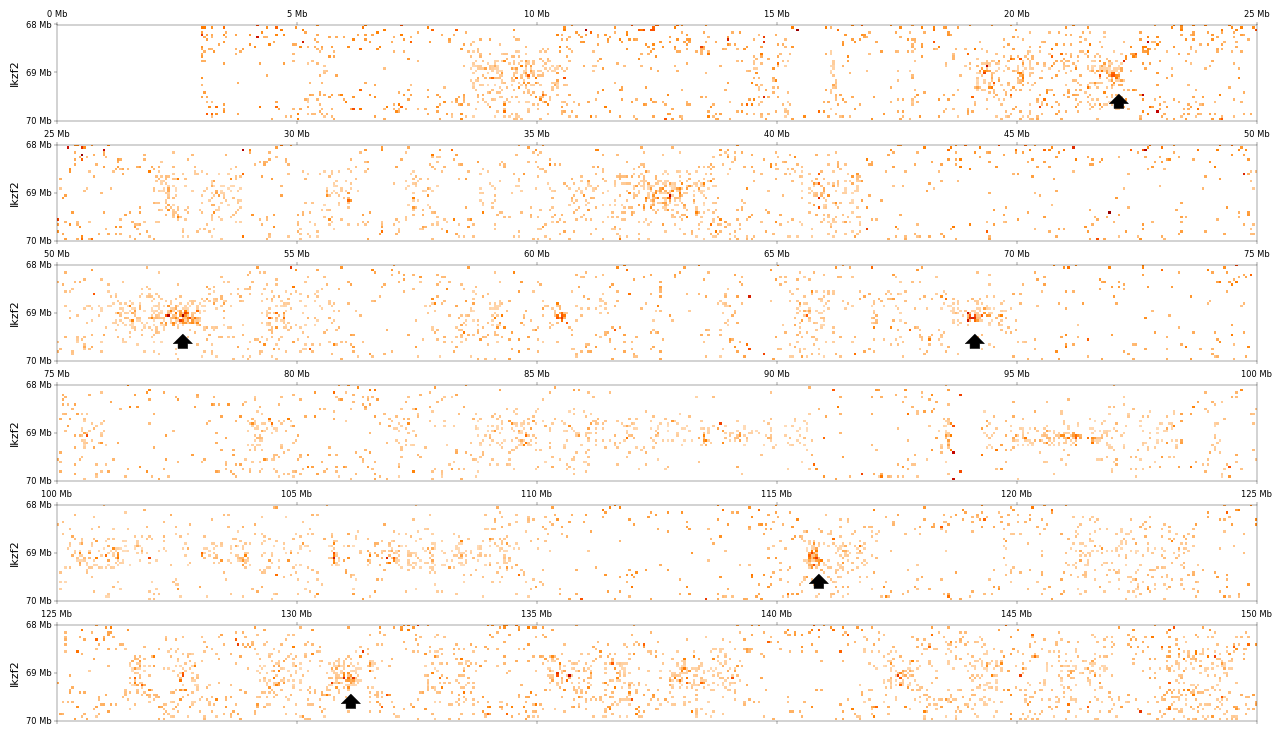

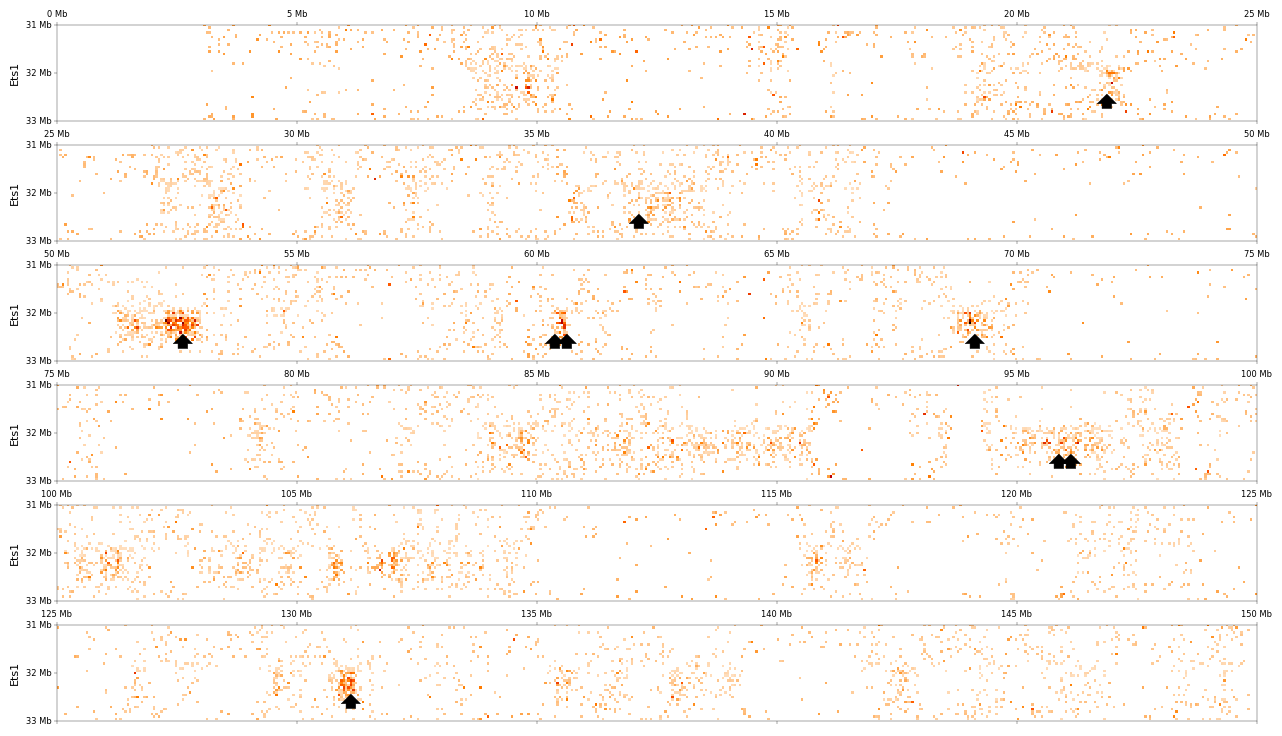

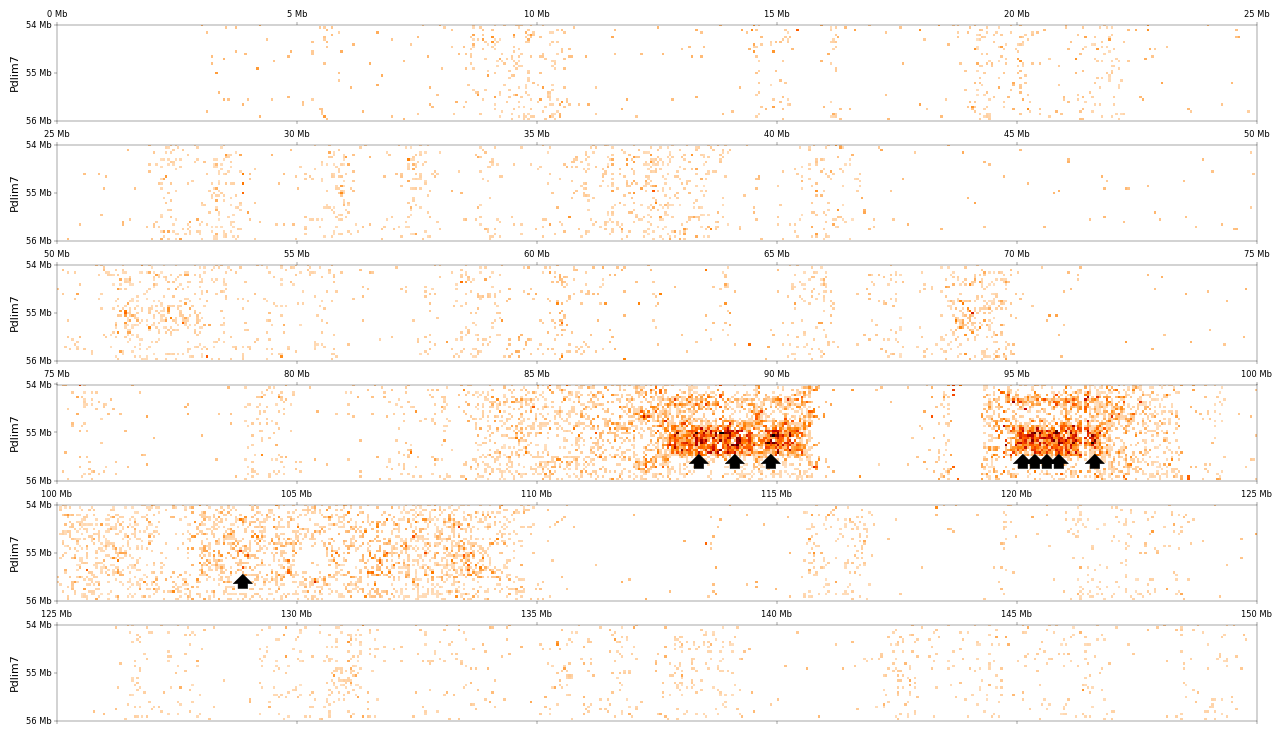

In [141]:
gene_names = ['Ly96', 'Ctla4', 'Ikzf2', 'Ets1', 'Pdlim7']
for c, i in enumerate([66, 243, 278, 5216, 7299]):
    name = gene_names[c]
    fig = make_wrapped_plot(inter_and_intra_metadomains, treg_50kb, all_ind_to_region, chrom_to_start, 
                            chrom_to_end, og_ind=i, compare_with = '3', dpi = 50, ylabel=name,
                            intra=False, gene=name)
    fig.savefig(f'./plots/paper/s16/{name}_chr1_wrapped_plot.pdf', bbox_inches='tight')

### Figure S12

Plot made in "plot_metadomains" folder

### Figure S13

A. Inter vs. Intra metadomains

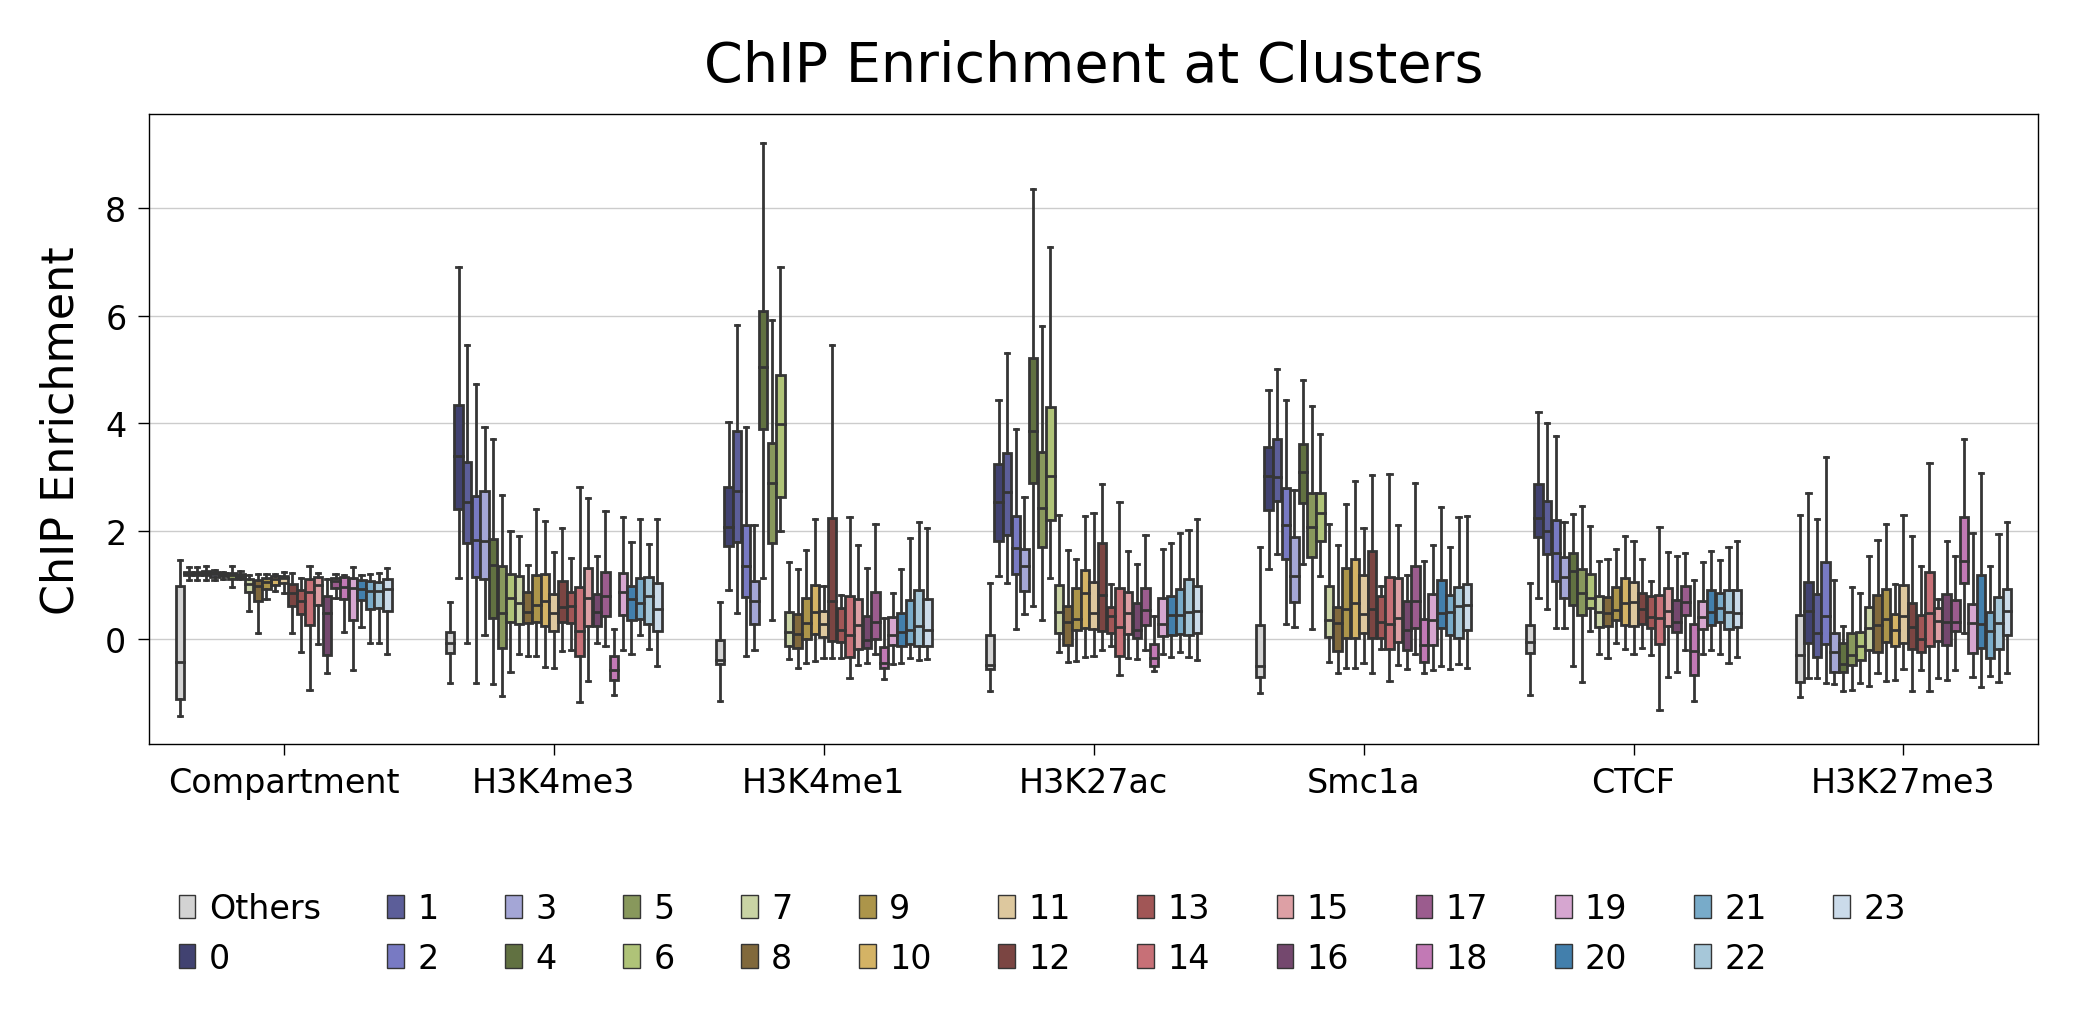

In [142]:
from supp_figures_plotting_functions import plot_inter_metadomain_clustering_chip

fig = plot_inter_metadomain_clustering_chip(bw_val_df_all_250kb, self, my_treg_comp)
fig.savefig('./plots/paper/s15/INTER_CHIP.pdf', bbox_inches='tight')

B-C. 

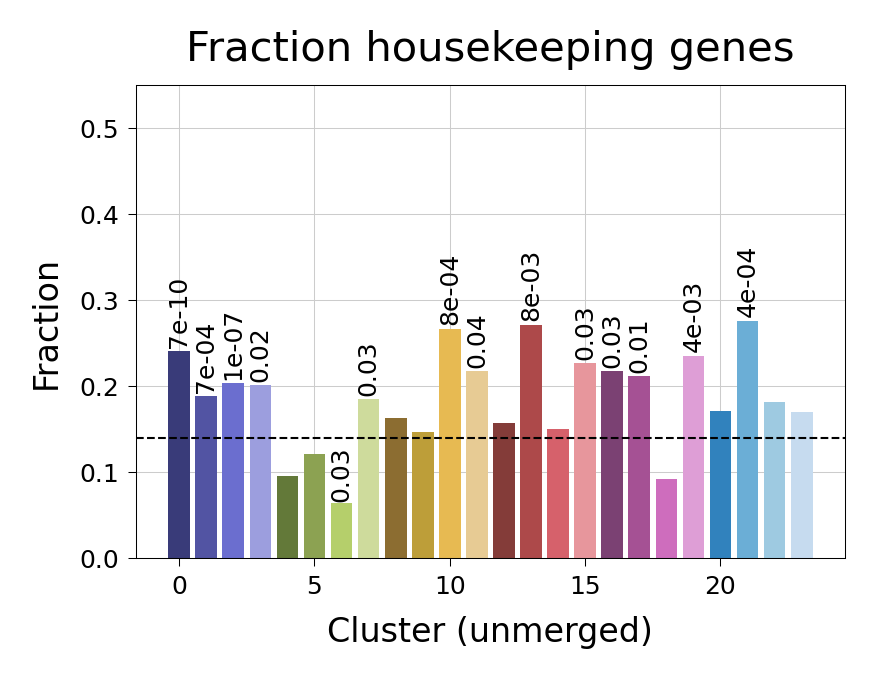

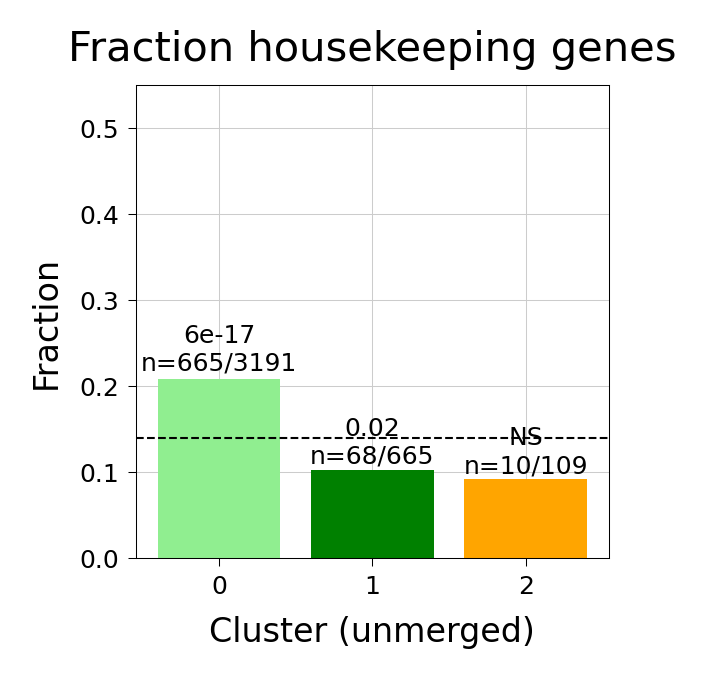

In [160]:
# from supp_figures_plotting_functions import housekeeping_barplots
housekeeping_barplots(self, unfiltered_ind_to_gene, row_colors)

D. 

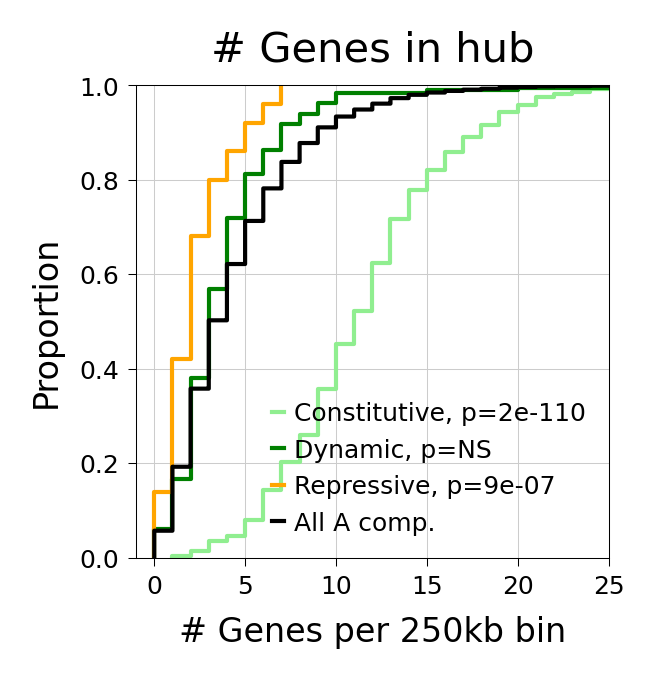

In [212]:
from supp_figures_plotting_functions import n_genes_per_hub

fig = n_genes_per_hub(self, unfiltered_ind_to_gene, columns_to_names, row_colors_dict, my_treg_comp)
fig.savefig('./plots/paper/s15/genes_in_hub.pdf', bbox_inches='tight')

E

Imported plotting functions


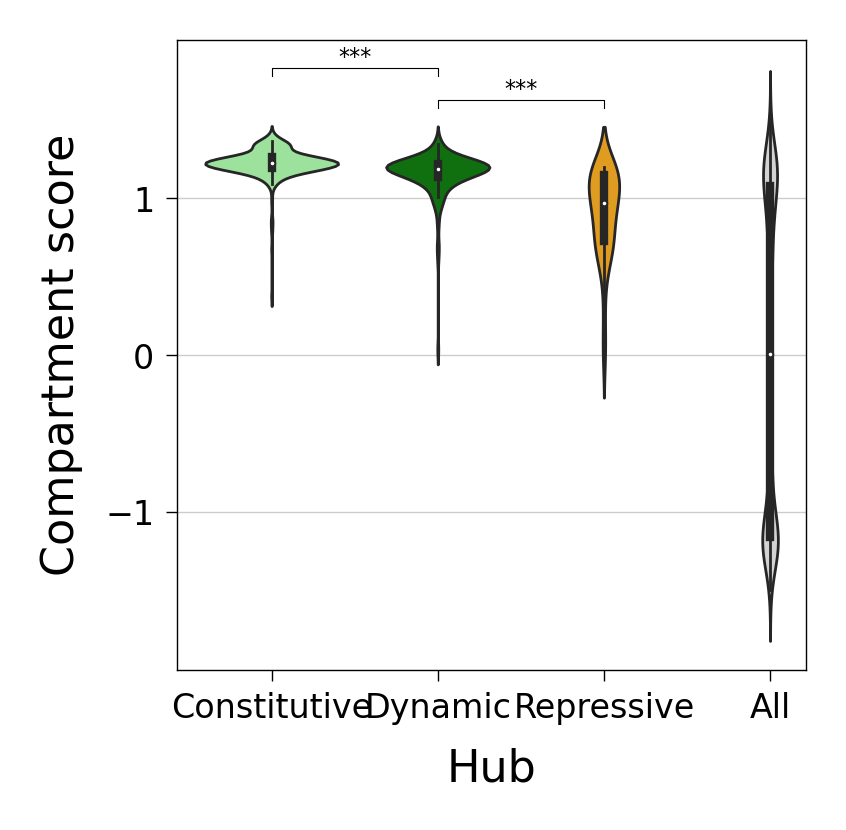

In [215]:
from supp_figures_plotting_functions import treg_comp_violin_plot

treg_comp_violin_plot(my_treg_comp, self, columns_to_names)

F.

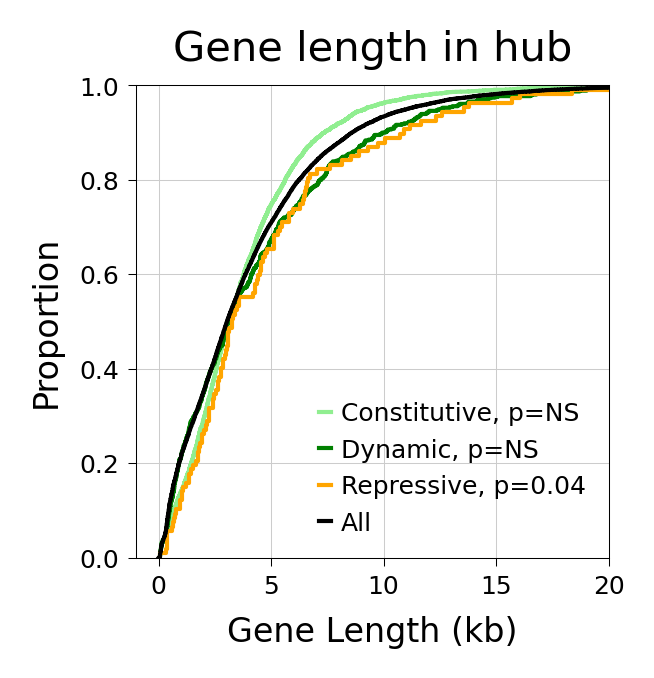

In [217]:
from supp_figures_plotting_functions import gene_length_per_hub

fig = gene_length_per_hub(self, gene_to_ind, unfiltered_ind_to_gene, columns_to_names, row_colors_dict, geneLengths)
fig.savefig('./plots/paper/s15/gene_length_in_hub.pdf', bbox_inches='tight')

G

Imported plotting functions


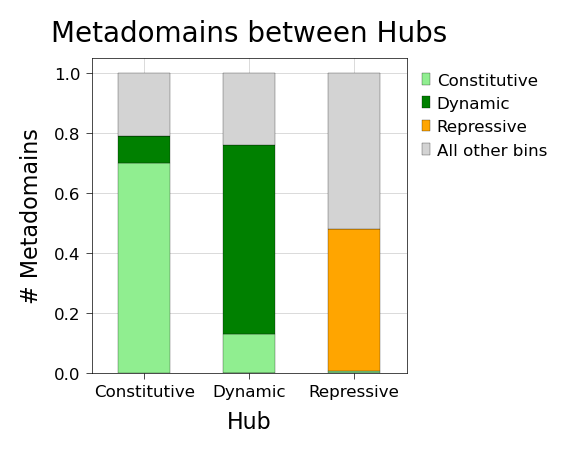

In [219]:
from supp_figures_plotting_functions import metadomain_between_hub_barplot

fig = metadomain_between_hub_barplot(all_inter_metadomains, self, columns_to_names,
                                row_colors, dpi = 100)
fig.savefig(f'./plots/paper/s15/F_metadomain_hubs.pdf', bbox_inches='tight')

H.

9263
7263
267


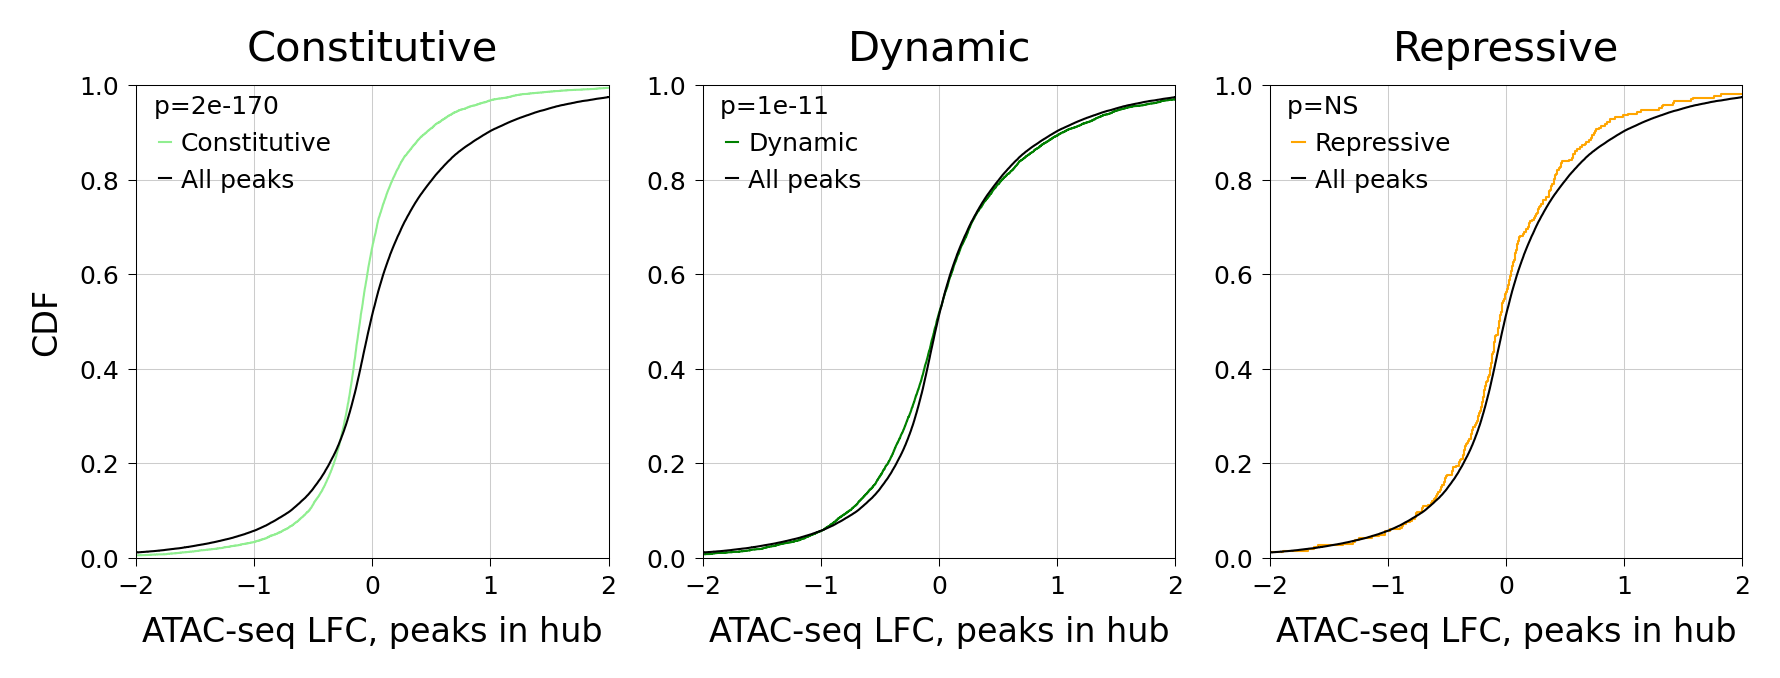

In [220]:
from supp_figures_plotting_functions import make_atac_enrichments_in_hub_quant

make_atac_enrichments_in_hub_quant(atac_peaks,  self, all_ind_to_region, columns_to_names, row_colors_dict)

Dynamic Treg
Dynamic Common


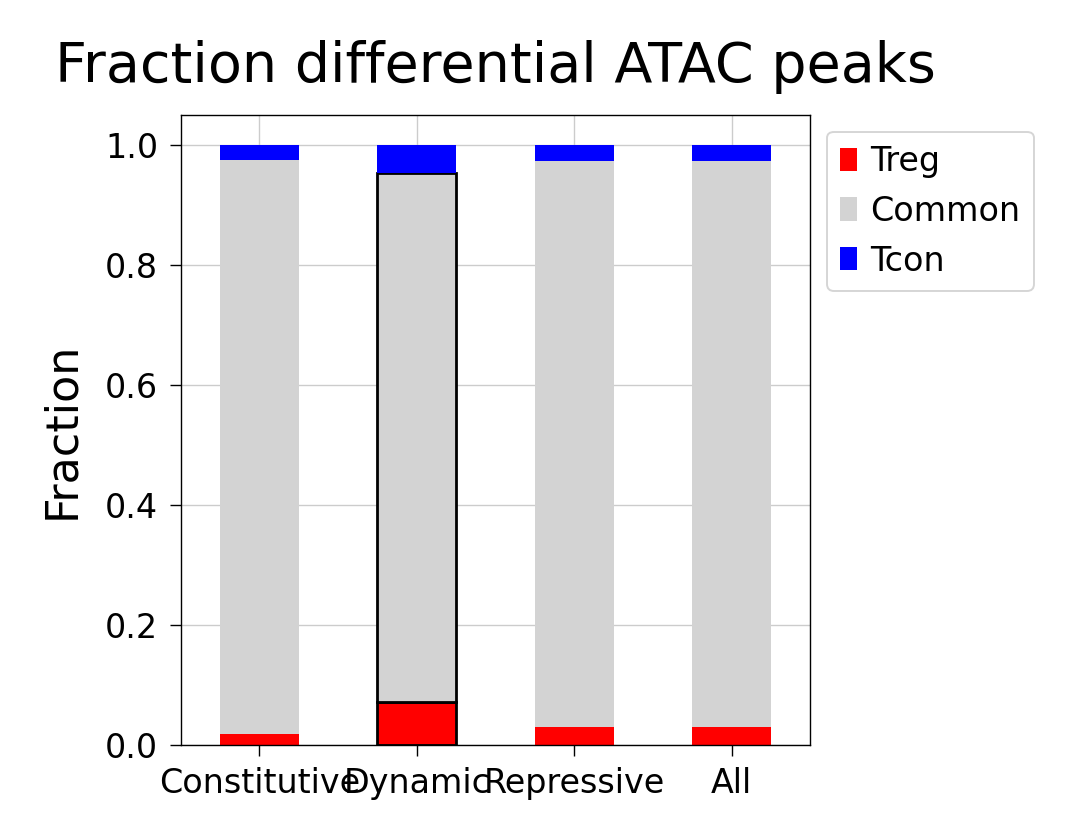

In [221]:
from supp_figures_plotting_functions import make_atac_enrichments_in_hub_with_pvals

data = make_atac_enrichments_in_hub_with_pvals(self, all_ind_to_region, columns_to_names)

I. mESC Pileups in "Pileups_mESC pileups"

#### Figure S14

A. GO terms

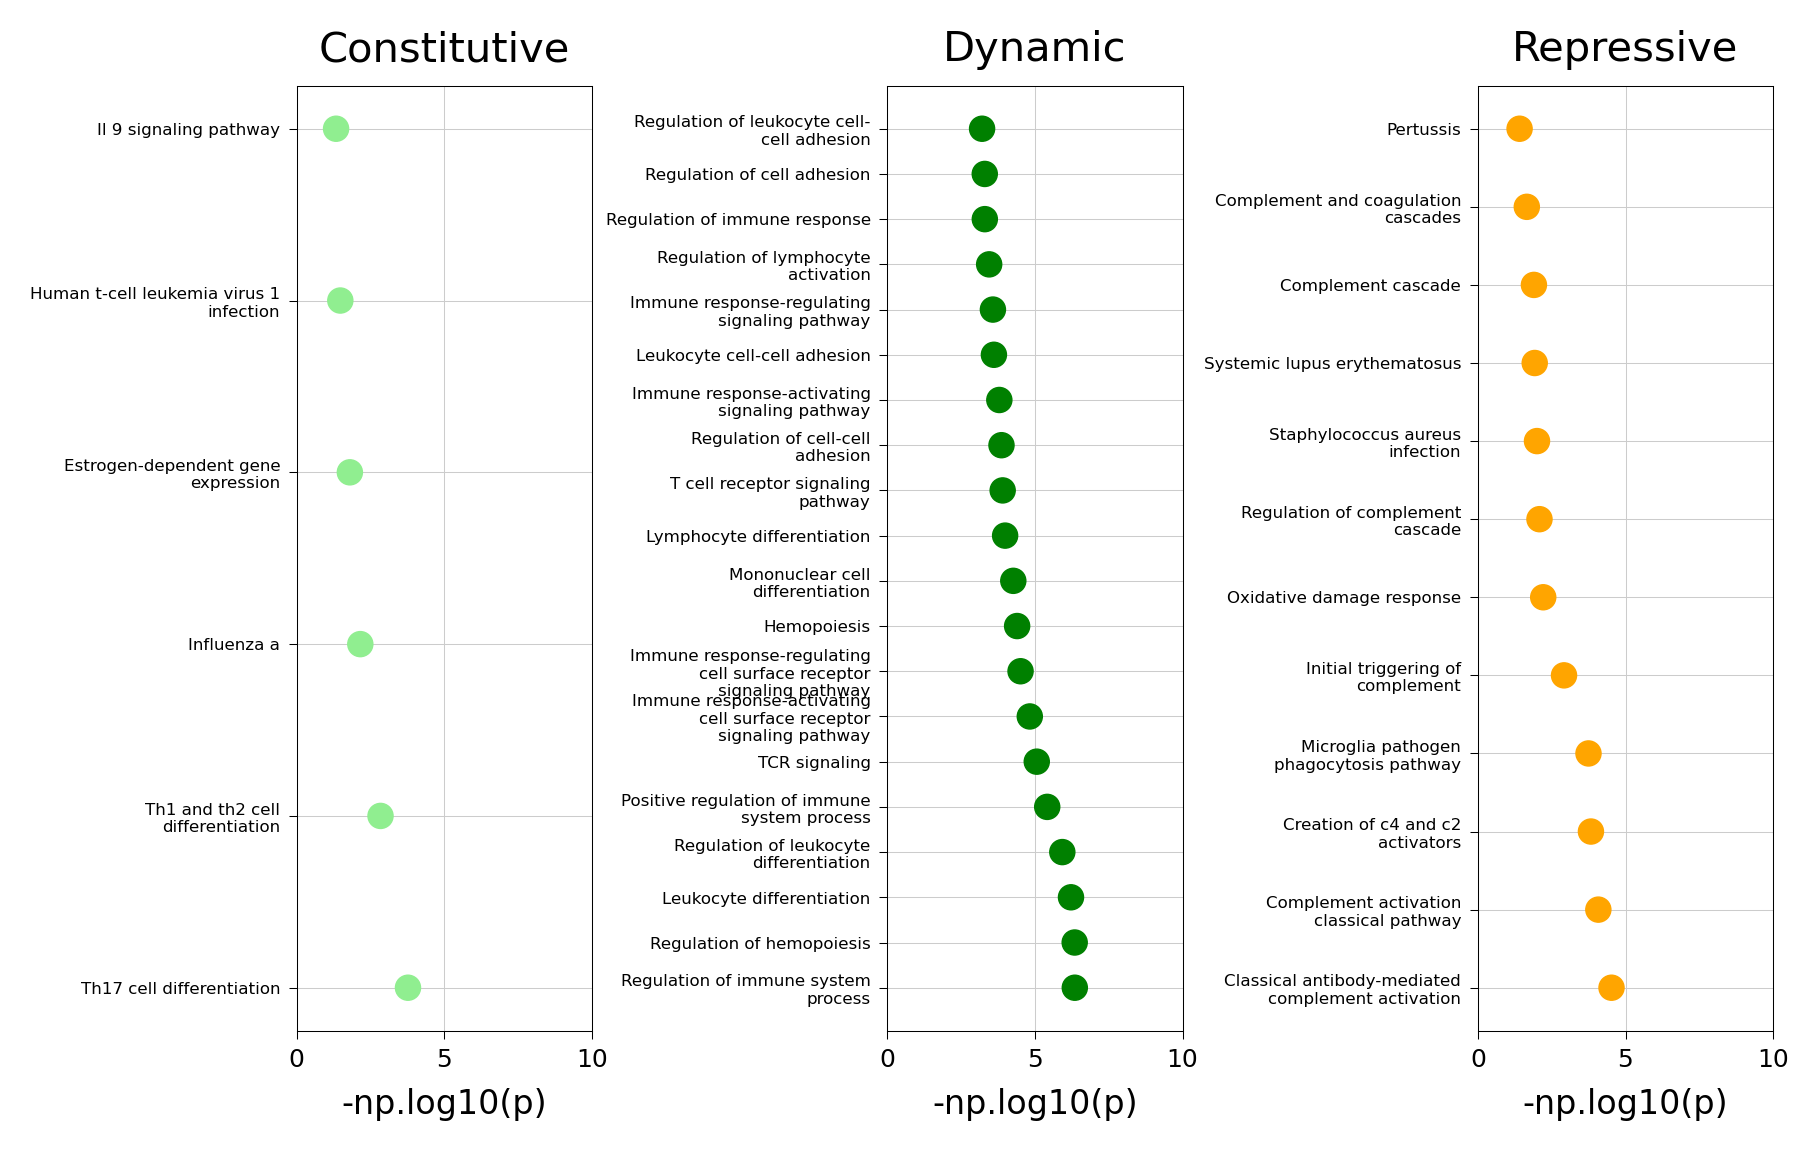

In [222]:
from supp_figures_plotting_functions import make_go_enrichment_plot

r = make_go_enrichment_plot(my_tss_df, columns_to_names, row_colors_dict, control_key='Other genes')

B. 

/Genomics/pritykinlab/gabe/jupys/tregs/./code/supp_figures_plotting_functions.py:2462: RuntimeWarning: divide by zero encountered in log2
  delta = np.log2(x.mean() / y.mean())


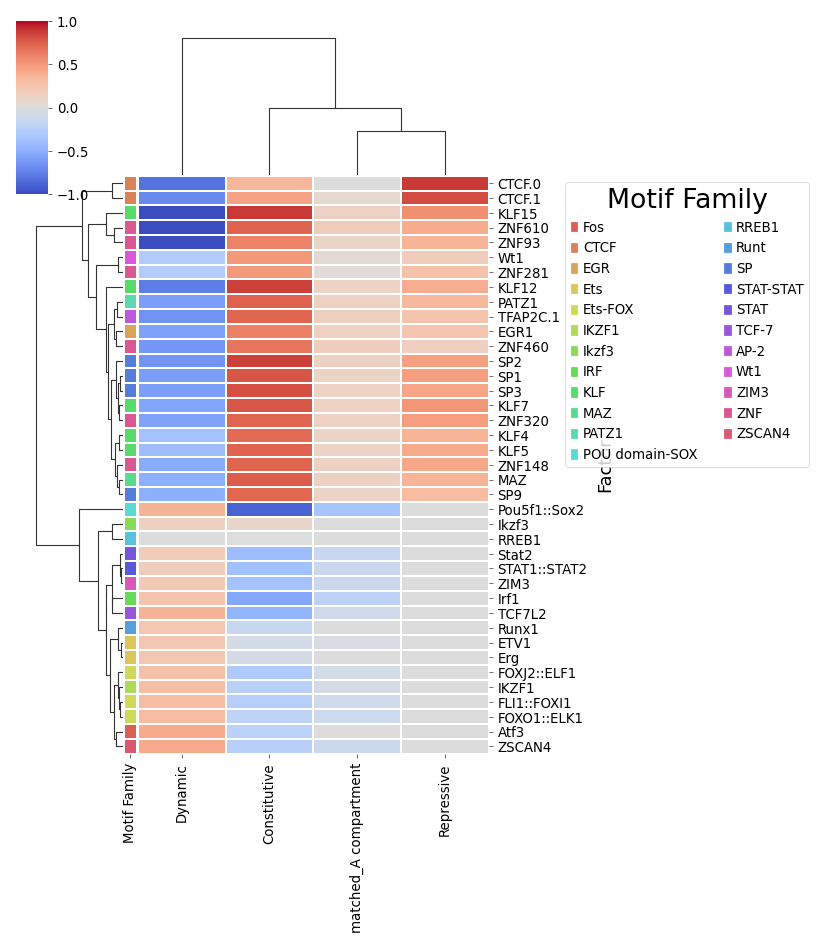

In [223]:
from supp_figures_plotting_functions import make_motif_enrichment_plot

results = make_motif_enrichment_plot(self, _250kb_hub_annotations, all_ind_to_region, meme_motif_df, motif_metadata, columns_to_names)

C. Pileup shown in Pileup_Liu2023

#### Figure S15

A.

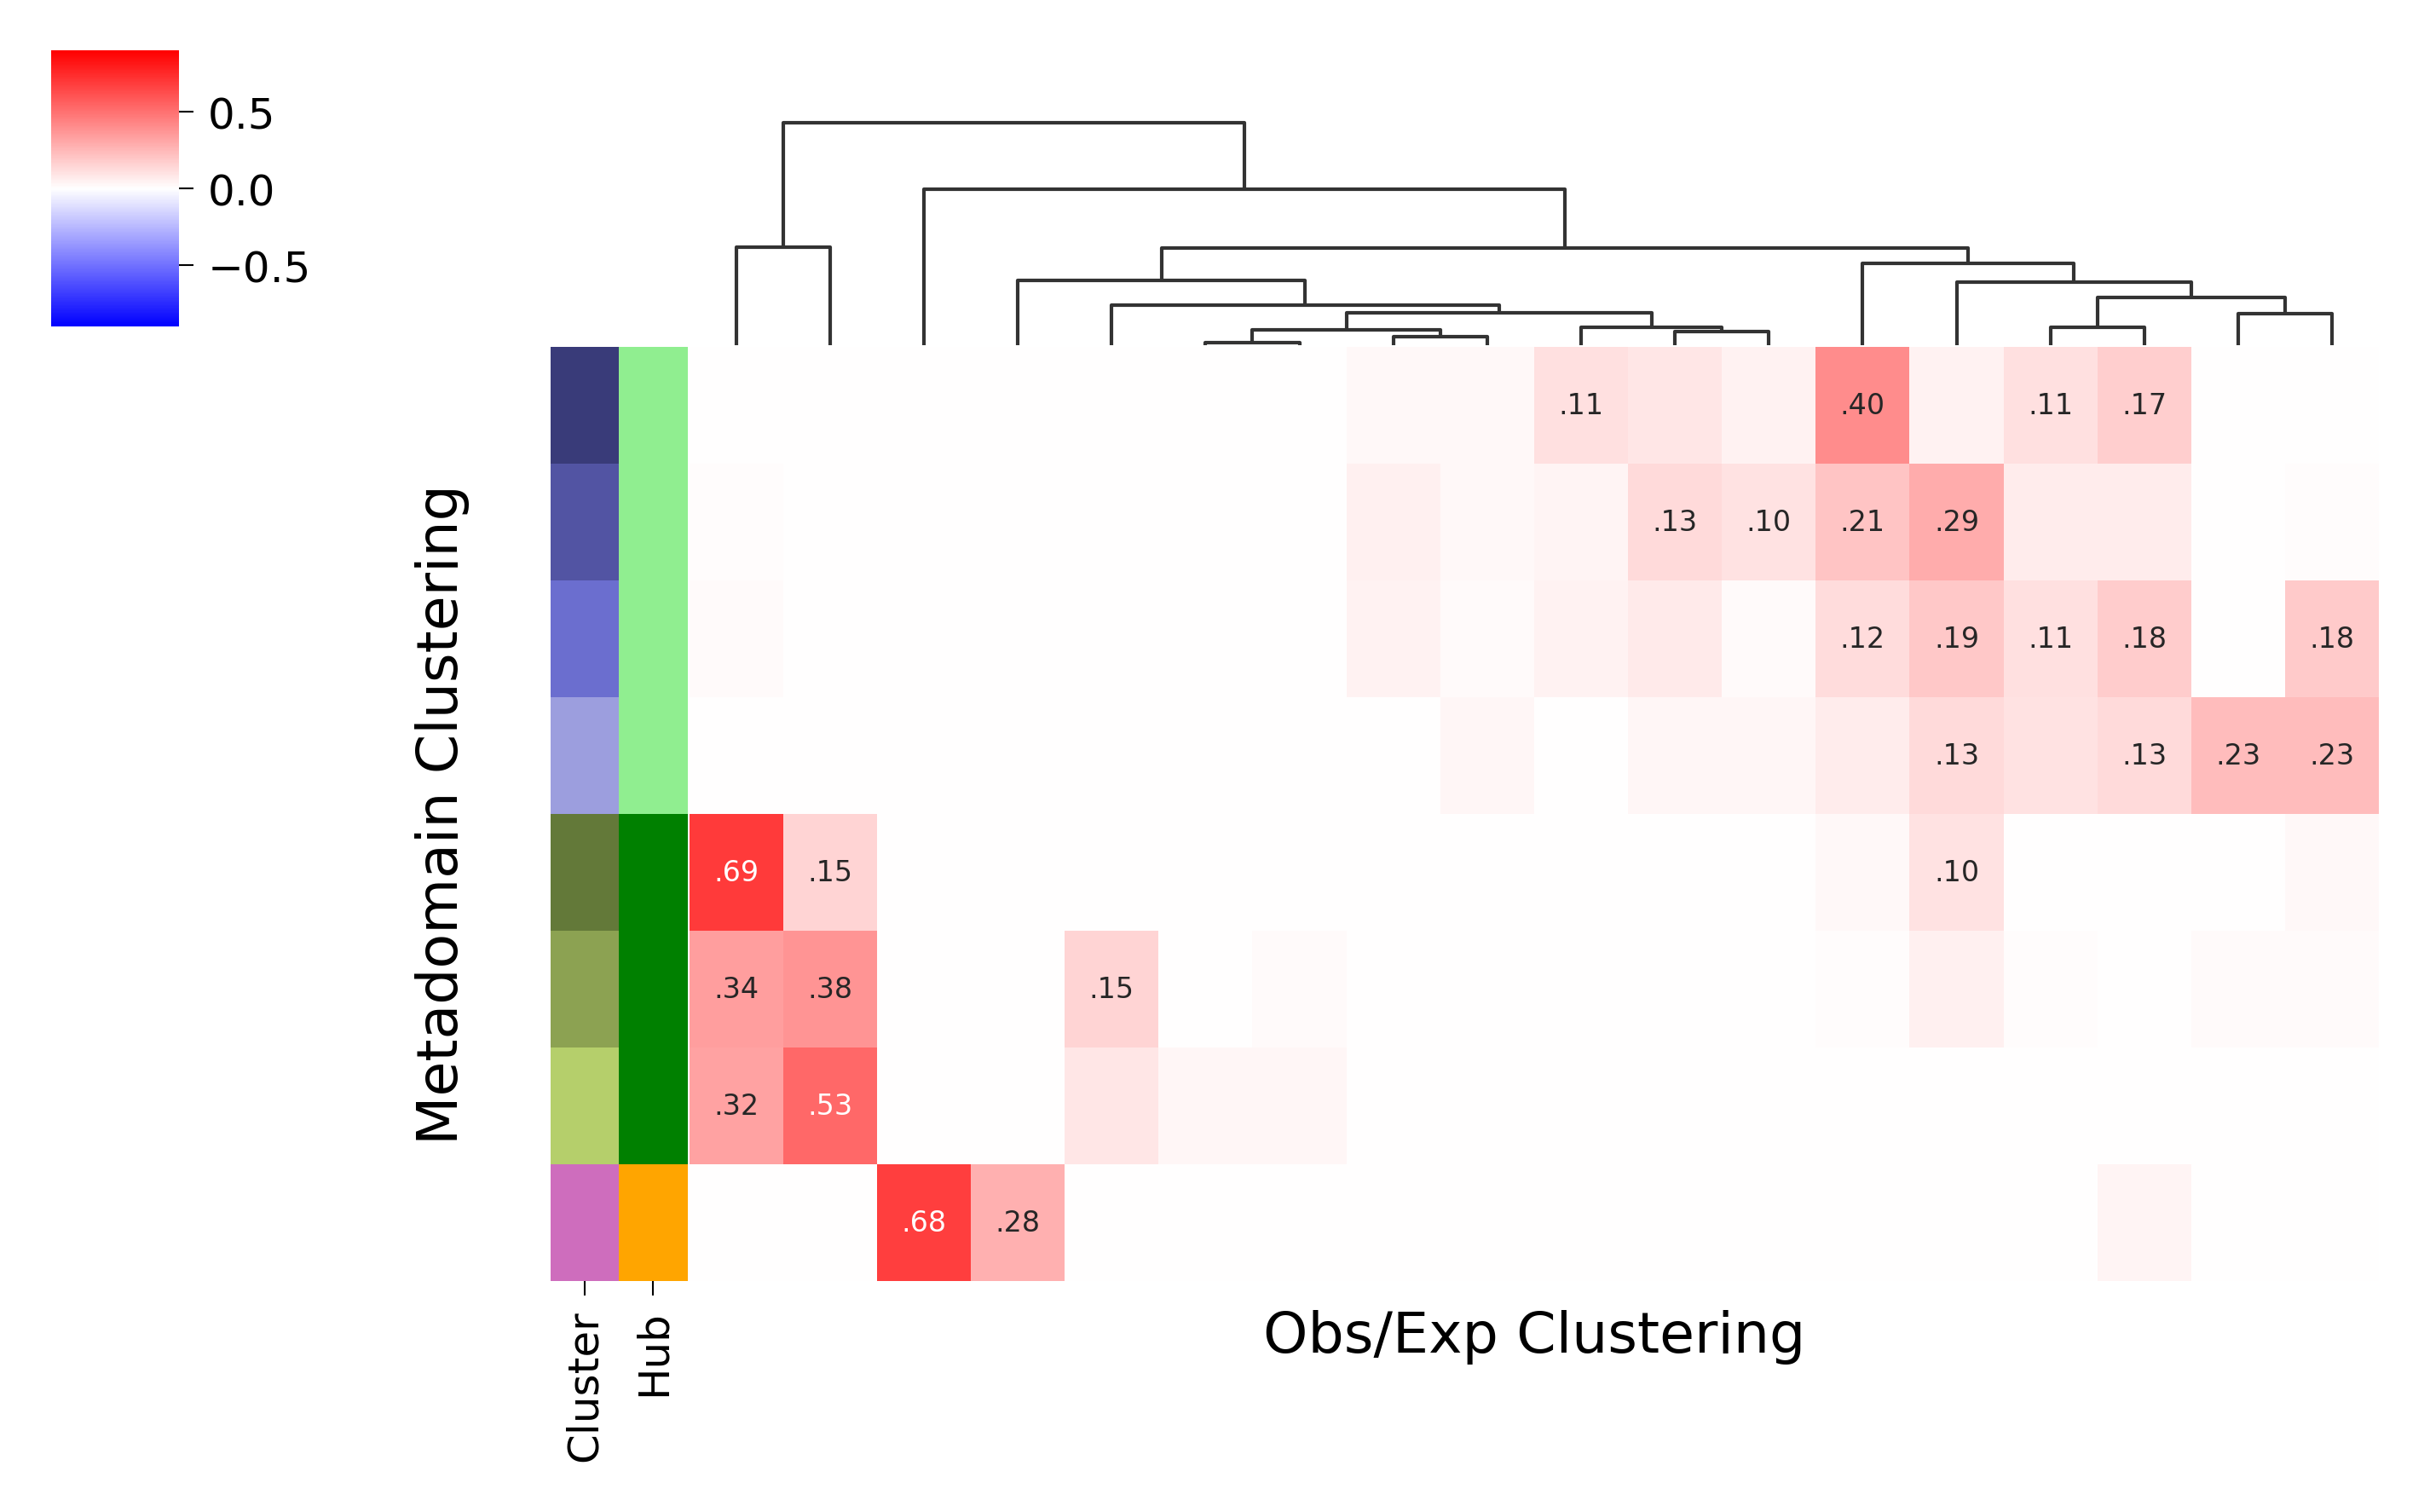

In [239]:
idx = treal_overlap['clust'].isin(self.cluster_to_subset_for_further_clustering)
data = pd.concat([treal_overlap['clust'][idx], trand_overlap['clust'][idx]], axis=1)
data.columns = ['real', 'rand']
data = data.value_counts().unstack().fillna(0)
data = data.div(data.sum(axis=1), axis=0)
data.index.name = 'Metadomain Clustering'
data.columns.name = 'Obs/Exp Clustering'

# Create an annotation mask where only values greater than 0.1 are annotated

annots = data.copy()
annot_mask = data > 0.1

# Fill annotations with NaN where mask is False
annots = data.where(annot_mask).round(2).fillna('')
annots = annots.applymap(lambda x: f'{x:.2f}'.lstrip('0') if isinstance(x, (int, float)) else x)

f = sns.clustermap(data, cmap='bwr', row_cluster=False, row_colors = row_colors,
                   col_cluster=True, figsize=(5, 3), xticklabels=False, yticklabels=False,
                   method = 'ward', vmin=-.9, vmax=.9, annot=annots,
                   annot_kws = {'fontsize': 4},
                   fmt='',  # Ensure proper formatting of annotations
                  )
f.fig.dpi = 300

f.ax_heatmap.yaxis.set_label_position("left")
f.ax_heatmap.yaxis.tick_left()
f.ax_heatmap.yaxis.set_label_coords(-0.13, 0.5)
f.fig.savefig('./plots/paper/s15/metadomain_vs_oe_clustering.pdf', bbox_inches='tight')


#### Figure S16

A.

RanksumsResult(statistic=33.64082729130243, pvalue=4.2463474172948514e-248)
RanksumsResult(statistic=42.88250958643466, pvalue=0.0)
RanksumsResult(statistic=0.4987166836162656, pvalue=0.6179789895781642)


/tmp/ipykernel_2161003/1321383642.py:4: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig('./plots/paper/s22/scrna_correlation_baseline.pdf', bbox_inches='tight', dpi=200)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


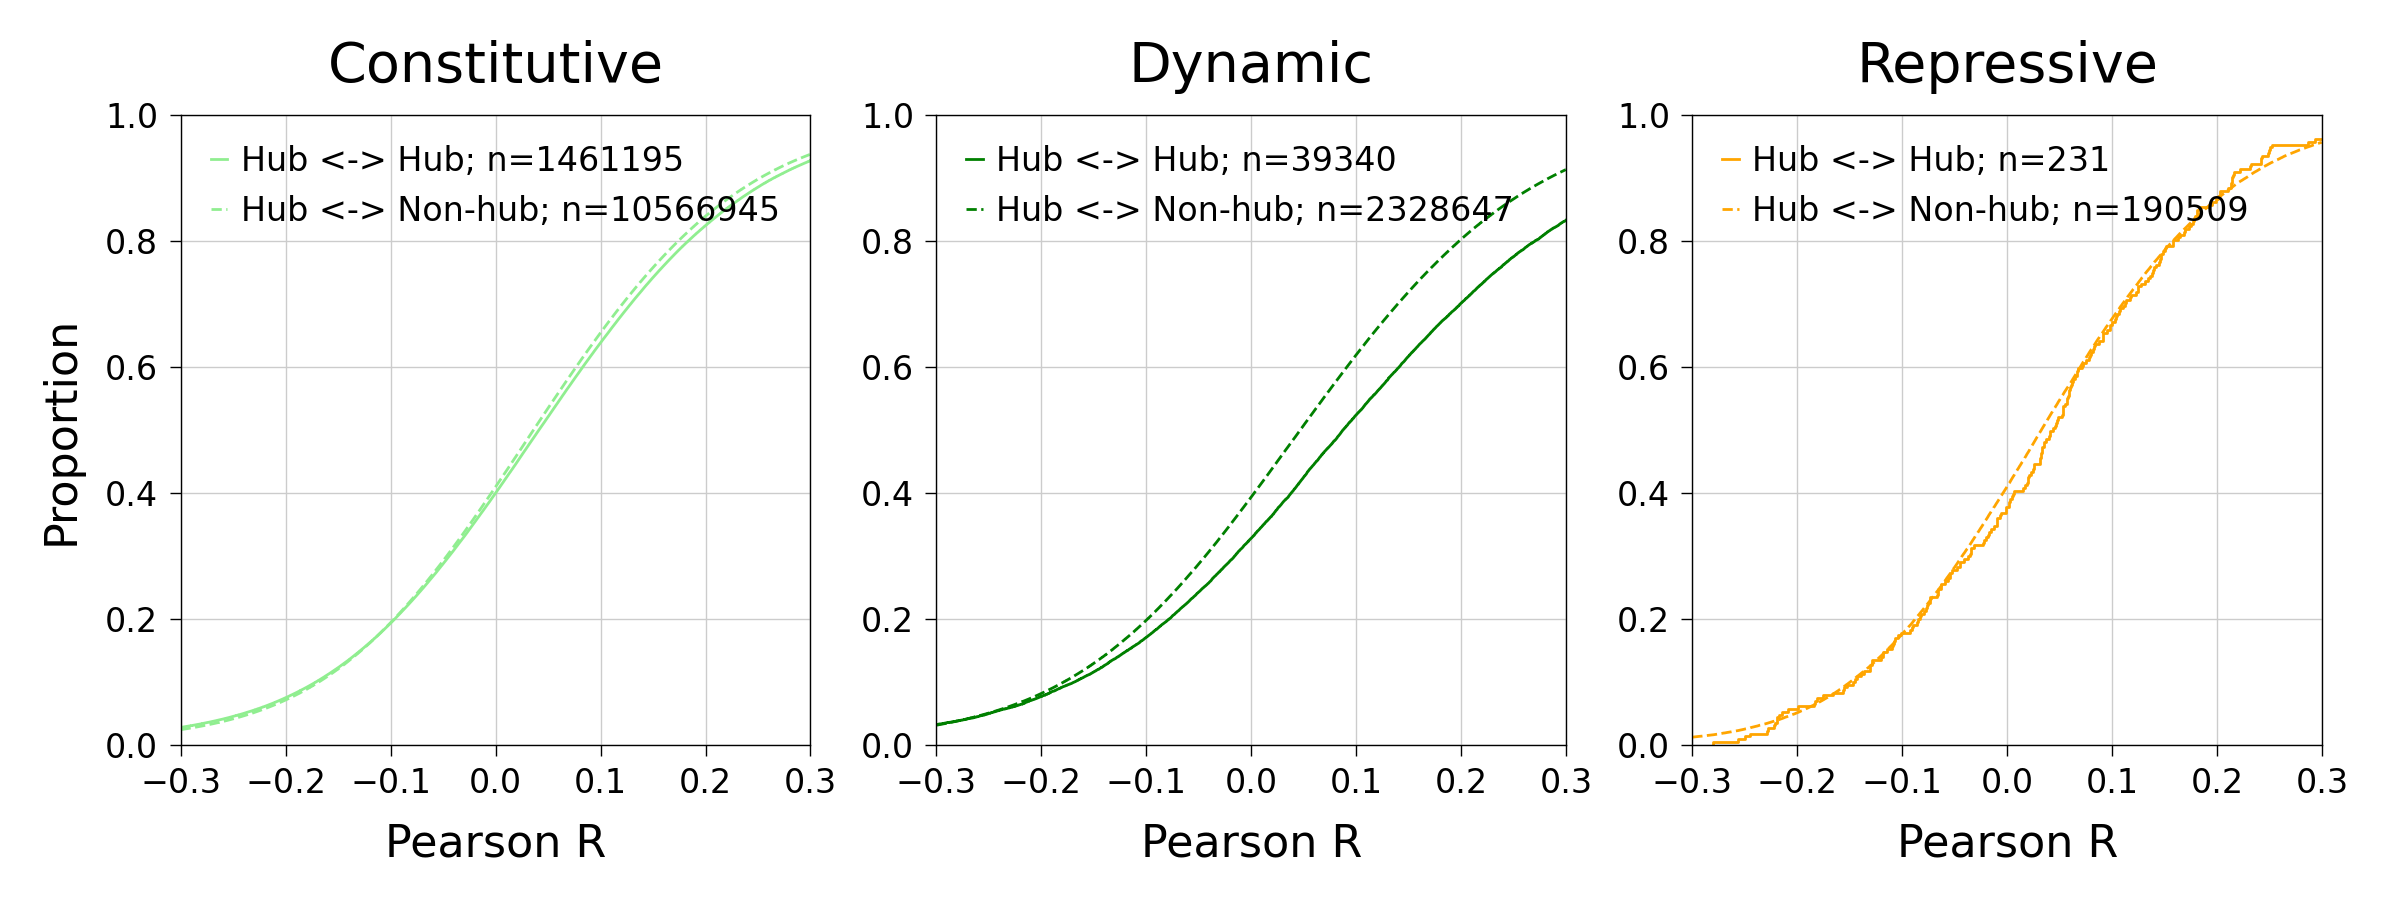

In [226]:
from supp_figures_plotting_functions import baseline_scrna_correlation

fig = baseline_scrna_correlation(gene_dict, ind_to_gene, self, tregs_rna_corr, row_colors_dict, columns_to_names)
fig.savefig('./plots/paper/s22/scrna_correlation_baseline.pdf', bbox_inches='tight', dpi=200)

B.

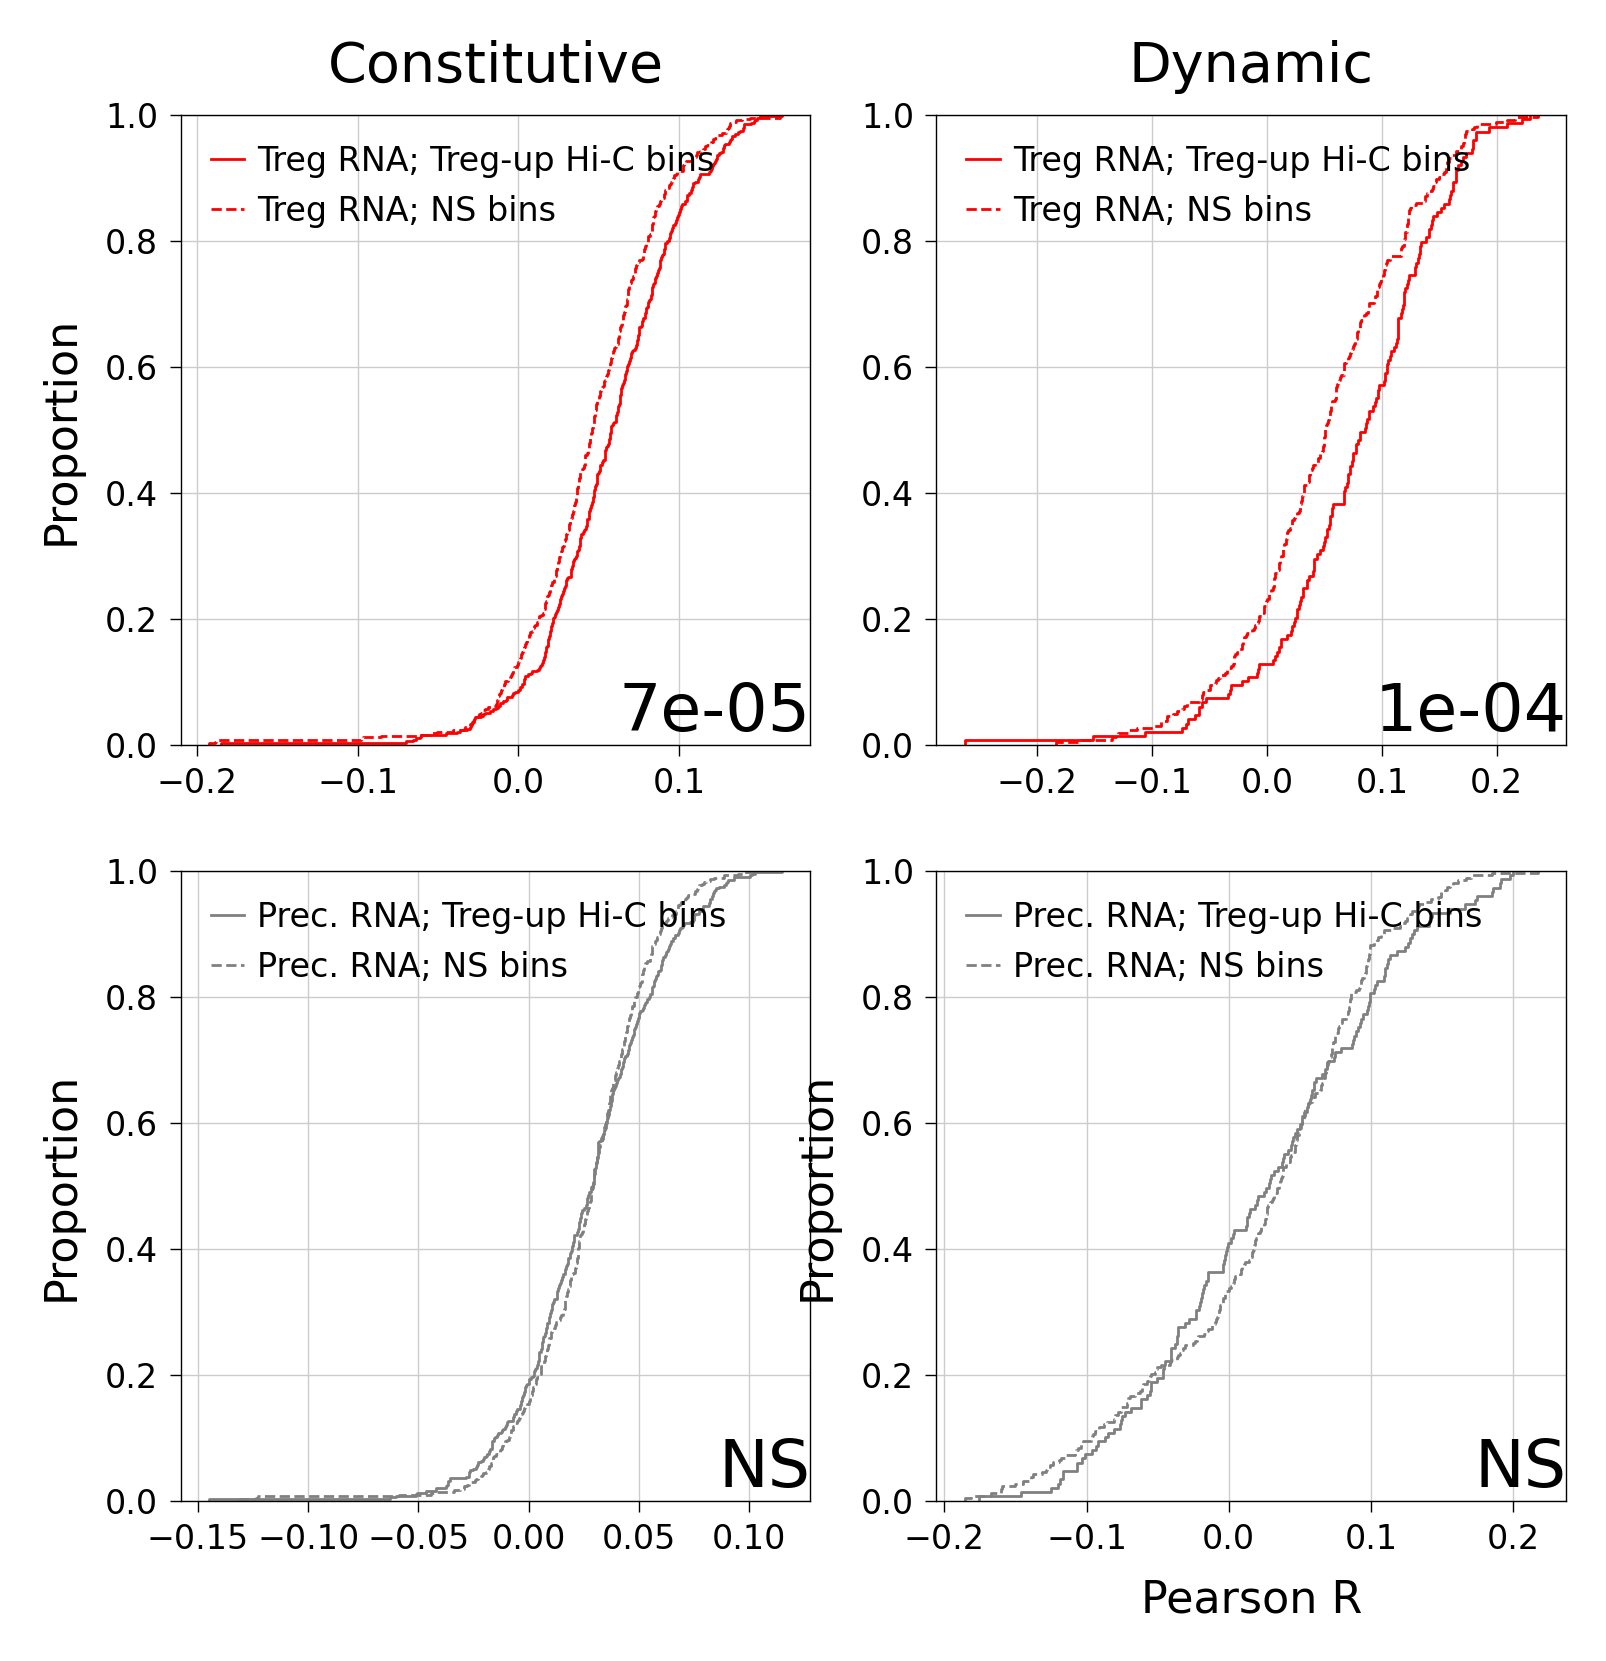

In [227]:
from supp_figures_plotting_functions import differential_scrna_correlation

fig = differential_scrna_correlation(gene_dict, ind_to_gene, self, tregs_rna_corr, treg_precursor_rna_corr, 
                                     hub_pileup_pval_df_250kb, hub_pileup_stat_df_250kb, columns_to_names,
                                    HIC_PCO, HIC_STATCO)
fig.savefig('./plots/paper/s22/scrna_treg_precursor_correlation.pdf', bbox_inches='tight', dpi=200)    

C-E. Pileups shown in Pileup_Liu2023, Pileup_Kawakami2021, and Pileup_Active_resting

#### Figure S17

A.

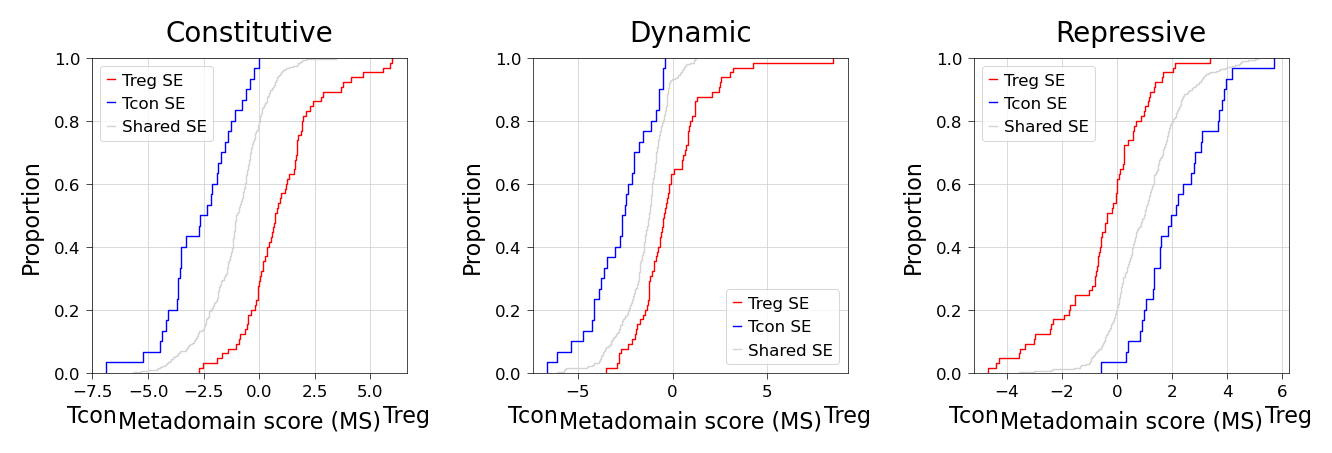

In [228]:
from supp_figures_plotting_functions import superenhancer_metadomain_score_cdf_plot

fig = superenhancer_metadomain_score_cdf_plot(hub_pileup_stat_df_250kb, SE_treg_count, SE_tcon_count, SE_common_count, columns_to_names)
# fig.savefig('./plots/paper/s24/superenhancer_metadomain_plot.pdf', bbox_inches='tight')

B. Pileups shown in Pileup_Individual Bins

C-E. Pileup shown in Pileup_Active_Resting 

#### Figure S18

Shown in plot_coolbox/Final_plot_coolbox notebook.

#### Figure S19

A-C. Shown in "hic_compendium_analysis/Final_Metaloops_Refine" Notebook

D.

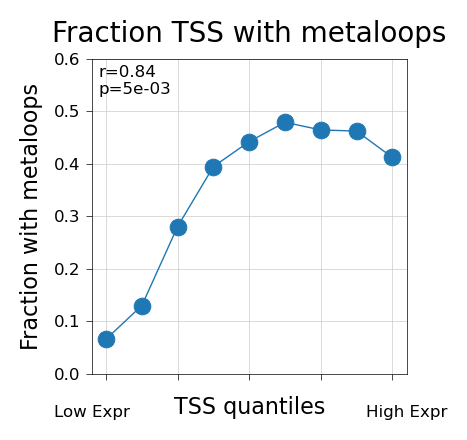

In [229]:
from supp_figures_plotting_functions import fraction_tss_with_metaloops

fraction_tss_with_metaloops(my_tss_df, metaloop_anchors, gene_dict)


E. 

/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


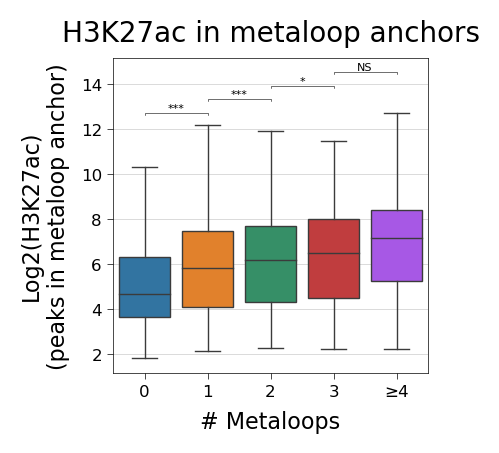

In [232]:
from supp_figures_plotting_functions import metaloop_h3k27ac_boxplot

metaloop_h3k27ac_boxplot(all_h3k27ac_peaks, metaloop_anchors)

#### Figure S20

Shown in "hic_compendium_analysis/Final_Metaloops_Refine" Notebook

#### Figure S21

A.

21514


/Genomics/pritykinlab/gabe/jupys/tregs/./code/volcano_plot.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(x, y, zorder = 3, c = colors, linewidth=0, s = s, rasterized=rasterized, vmin=vmin, vmax=vmax, alpha=alpha)


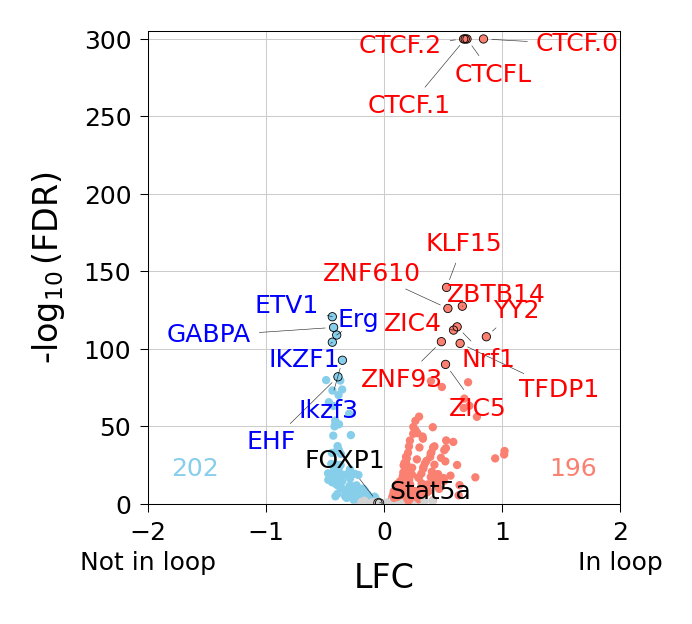

In [233]:
from supp_figures_plotting_functions import loop_vs_nonloop_motif_enrichment

df = loop_vs_nonloop_motif_enrichment(meme_motif_df, add_chr_to_bedtool(anchordict['All']))

B. 

/Genomics/pritykinlab/gabe/jupys/tregs/./code/volcano_plot.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(x, y, zorder = 3, c = colors, linewidth=0, s = s, rasterized=rasterized, vmin=vmin, vmax=vmax, alpha=alpha)


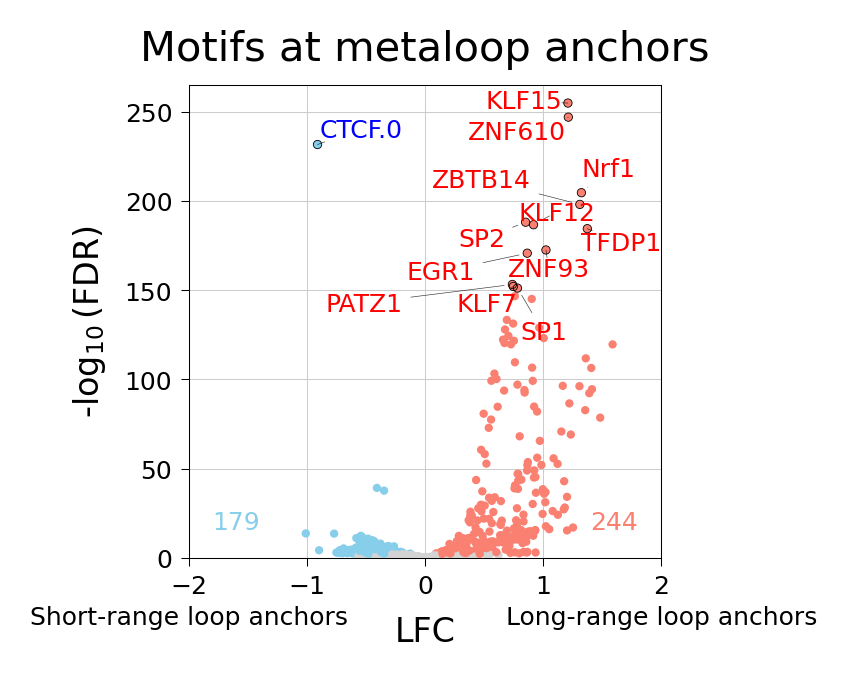

In [234]:
from supp_figures_plotting_functions import metaloop_vs_shortrange_loop_motif_enrichment

metaloop_vs_shortrange_loop_motif_df = metaloop_vs_shortrange_loop_motif_enrichment(meme_motif_df, anchordict, metaloop_anchors)

C.

Imported plotting functions
Treg    0.101825
Tcon    0.087242
NS      0.090762
Name: Stat5a, dtype: float64


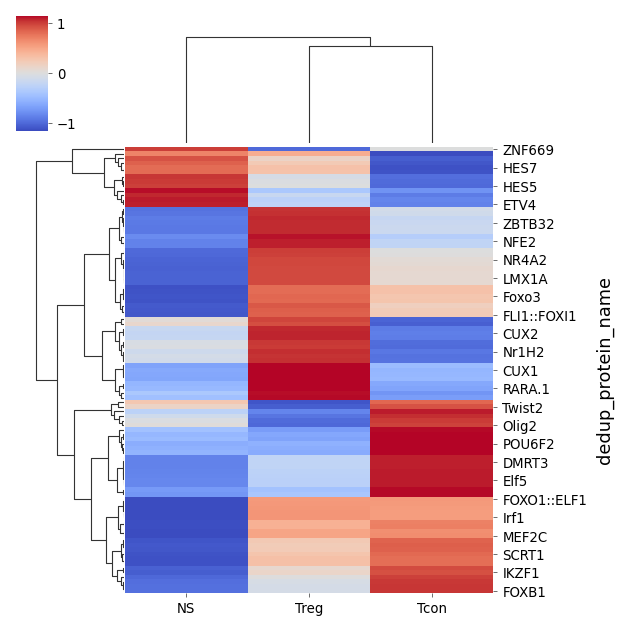

In [251]:
from supp_figures_plotting_functions import treg_vs_tcon_loop_motif_enrichment

data = treg_vs_tcon_loop_motif_enrichment(meme_motif_df, anchordict)

D. 

/Genomics/pritykinlab/gabe/jupys/tregs/./code/volcano_plot.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(x, y, zorder = 3, c = colors, linewidth=0, s = s, rasterized=rasterized, vmin=vmin, vmax=vmax, alpha=alpha)


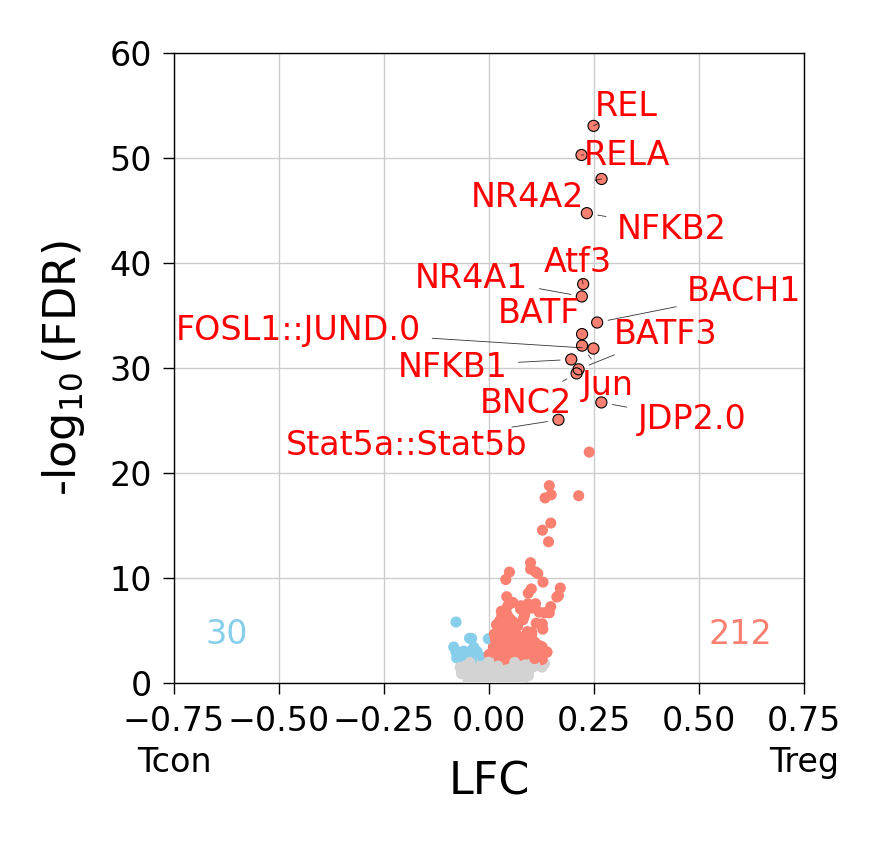

In [252]:
from supp_figures_plotting_functions import make_h3k27ac_motif_enrichment_plot

motif_data = make_h3k27ac_motif_enrichment_plot(h3k27ac_motif_df)

E. Looping ChIP enrichment

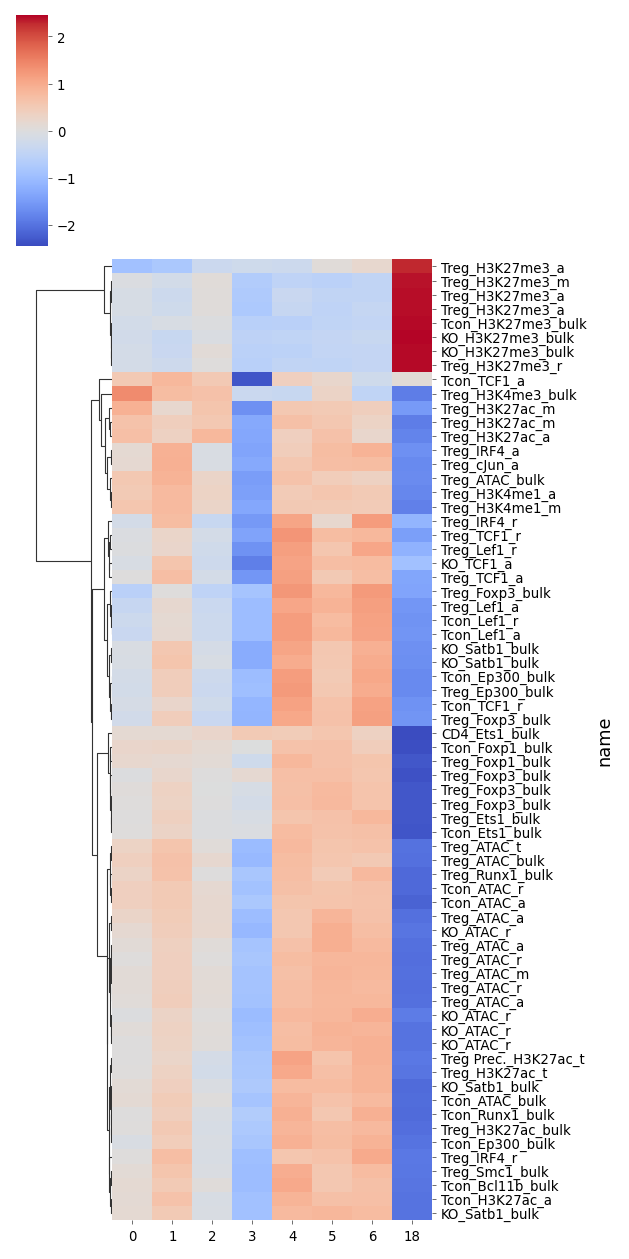

In [253]:
val_df = pd.DataFrame()
cldict = {}
for i in self.cluster_to_subset_for_further_clustering:
    cl0 = pd.Series(list(bedtool_to_grange_set(metaloop_anchors.intersect(add_chr_to_bedtool([all_ind_to_region[x] 
                                                                                              for x in self.goodinds[self.clustdict['all']==i]]),
                          u=True))))
    cl0 = cl0[cl0.isin(adata.obs.index)]
    cldict[i] = cl0
    val_df[i] = adata[cl0].X.mean(axis=0)
val_df.index = adata.var['name']

g = sns.clustermap(val_df.iloc[::3], cmap='coolwarm', z_score=0,  col_cluster=False,  yticklabels=True,  figsize=(4, 8), method='ward')
g.fig.savefig('./plots/paper/s31/chip_at_metaloop_anchors.pdf', bbox_inches='tight')

F. Found in  Final_ChIP_Compendium_Analysis

G. 

In [254]:
loop_adata = sc.read_h5ad('./final_chipseq_adata/FINAL_loop_adata')

oe_df = pd.read_csv('./data_for_enhancer_umap/oe_df.csv', sep='\t', index_col=0)
with open('./full_pileup_dict', 'rb') as f:
    full_pileup_dict = pickle.load(f)

/Genomics/pritykinlab/gabe/jupys/tregs/./code/supp_figures_plotting_functions.py:3323: UserWarning: The figure layout has changed to tight
  plt.savefig(f'./plots/paper/s31/baseline_loops_{key}.pdf')
/Genomics/pritykinlab/gabe/jupys/tregs/./code/supp_figures_plotting_functions.py:3309: RuntimeWarning: Mean of empty slice
  delta_mat = m1[5:-5, 5:-5]


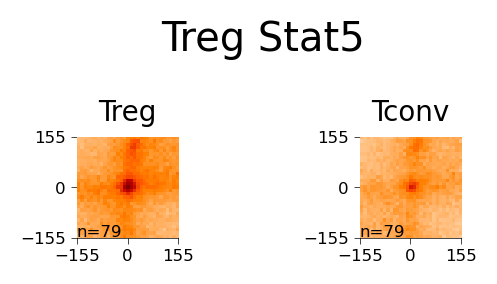

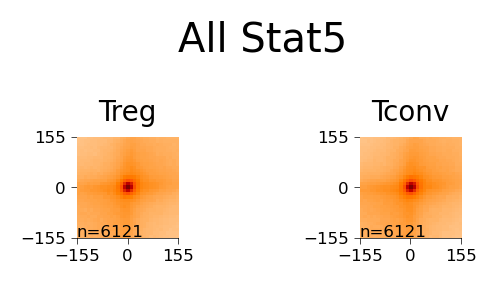

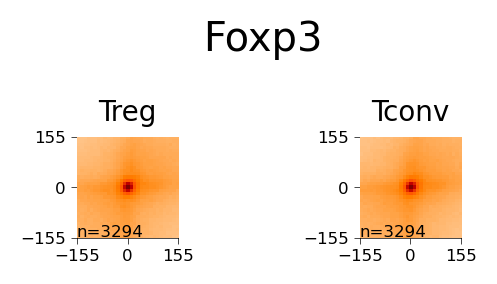

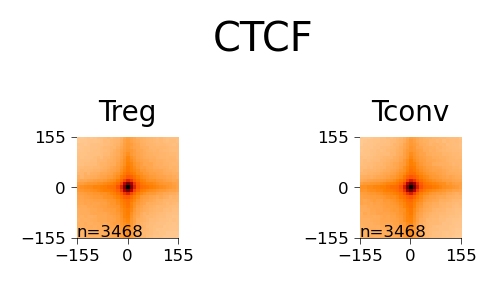

In [255]:
import math
from supp_figures_plotting_functions import loop_apa_pileup

plt.rcParams['pdf.fonttype'] = 42

loop_apa_pileup(loop_adata, full_pileup_dict, oe_df)

H. Found in Final_ChIP_Compendium_Analysis notebook

I. 

/tmp/ipykernel_2161003/3221240399.py:27: RuntimeWarning: Mean of empty slice
  v1 = np.nanmean(pileup_1[:, n-d:n+d+1, n-d:n+d+1], axis=(1, 2))


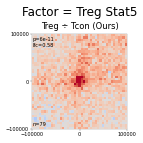

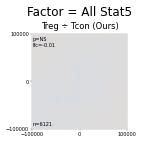

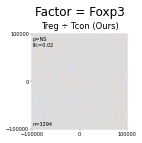

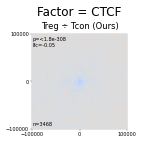

In [256]:
import math
from plotting_functions import *

indsoi_dict = {
    'Treg Stat5' : (loop_adata.obs['new_treg_stat'] > 0), 
    'All Stat5' : (loop_adata.obs['new_ns_stat'] > 0), 
    'Foxp3' : (loop_adata.obs['foxp3_peaks_yuri'] > 0), 
    'CTCF' : (loop_adata.obs['ctcf_p=1e-05'] > 1), 
}

for key, indsoi in indsoi_dict.items():
    comparisons = {
        'Treg ÷ Tcon (Ours)' : ['Rename_Treg_all_no_chrM', 'Rename_Tconv_all_no_chrM'],
    }
    rows = 1
    cols = math.ceil(len(comparisons)/rows)
    fig, axs = init_subplots_exact(1, 1, fgsz=(40*mm, 40*mm), as_list=True)
    for c, (label, (comp1, comp2)) in enumerate(comparisons.items()):
        ax = axs[c]
        pileup_1 = full_pileup_dict[comp1][oe_df.index.isin(loop_adata.obs.index)][indsoi].copy()
        pileup_2 = full_pileup_dict[comp2][oe_df.index.isin(loop_adata.obs.index)][indsoi].copy()
        m1 = np.nanmean(pileup_1, axis=0)
        m2 = np.nanmean(pileup_2, axis=0)

        n = len(m1)//2
        d = 2
        v1 = np.nanmean(pileup_1[:, n-d:n+d+1, n-d:n+d+1], axis=(1, 2))
        v2 = np.nanmean(pileup_2[:, n-d:n+d+1, n-d:n+d+1], axis=(1, 2))
        pval = samesize_nonan_test(v1, v2)[1]
        lfc = np.log2(np.nanmean(v1)/np.nanmean(v2))
        delta_mat = m1-m2
        ax.matshow(delta_mat, vmin=-2, vmax=2, cmap='coolwarm',
                   extent = [-res*n, res*n, -res*n, res*n], zorder=3
                  )
        ax.set_xticks([-res*n, 0, res*n])
        ax.set_yticks([-res*n, 0, res*n])
        ax.tick_params(bottom=True, labelbottom=True, top=False, labeltop=False, left=True, labelleft=True)

        p = format_pvalue(pval)
        plt.title(label)
        if np.abs(lfc) < .02:
            p = 'NS'
        ax.text(-res*n, res*(n-1), f'p={p}\nlfc={lfc.round(2)}', fontsize=6,
               va='top')
        
        ax.text(-res*n, -res*(n-1), f'n={len(v1)}', fontsize=6)
        fig.suptitle(f'Factor = {key}', y=1.3)
    fig.savefig(f'./plots/paper/s31/differential_apa_{key}.pdf', bbox_inches = 'tight')